# MODELO ARIMA PARA PRONOSTICO DE LA DEMANDA

1. CARGA Y AJUSTE DE DATOS
2. ANALISIS EXPLORATORIO DE DATOS (EDA)
3. IDENTIFICACION DEL MODELO
4. ESTIMACION DEL MODELO
5. EVALUACION DEL MODELO
6. FORECAST DEL MODELO
7. AJUSTE DEL MODELO

                     fecha       valor
count                   90   85.000000
mean   2025-02-14 12:00:00   50.666579
min    2025-01-01 00:00:00   23.802549
25%    2025-01-23 06:00:00   43.982934
50%    2025-02-14 12:00:00   48.843517
75%    2025-03-08 18:00:00   55.132674
max    2025-03-31 00:00:00  200.000000
std                    NaN   18.927653


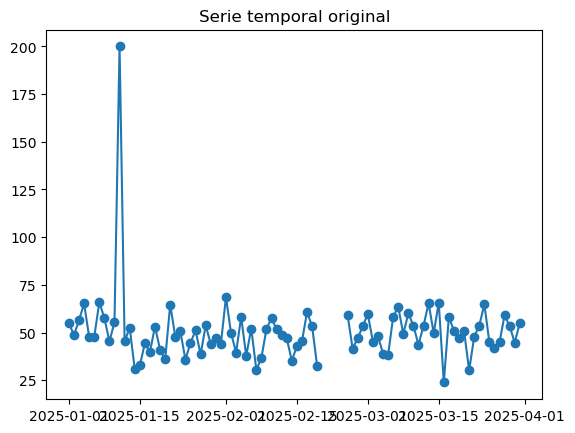

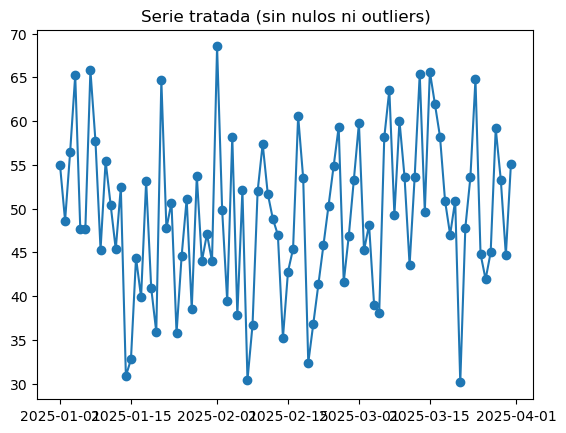

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulación de datos
np.random.seed(42)
fechas = pd.date_range('2025-01-01', '2025-03-31', freq='D')
valores = np.random.normal(50, 10, size=len(fechas))
valores[10] = 200   # Outlier
valores[50:55] = np.nan  # Valores faltantes

df = pd.DataFrame({'fecha': fechas, 'valor': valores})

# EDA Básico
print(df.describe())
plt.plot(df['fecha'], df['valor'], marker='o')
plt.title("Serie temporal original")
plt.show()

# Tratamiento de nulos
df['valor'] = df['valor'].interpolate(method='linear')

# Detección y tratamiento de outliers (IQR)
Q1 = df['valor'].quantile(0.25)
Q3 = df['valor'].quantile(0.75)
IQR = Q3 - Q1
outliers = (df['valor'] < (Q1 - 1.5 * IQR)) | (df['valor'] > (Q3 + 1.5 * IQR))
df.loc[outliers, 'valor'] = np.nan  # Marcar outliers como nulos
df['valor'] = df['valor'].interpolate(method='linear')  # Imputar outliers

plt.plot(df['fecha'], df['valor'], marker='o')
plt.title("Serie tratada (sin nulos ni outliers)")
plt.show()

In [2]:
# LIBRERIAS

# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
from numpy import log

import scipy.stats as stats
from scipy.stats import skew
from scipy.stats import shapiro, jarque_bera, kstest

# StatsForecast
# ==============================================================================
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


# Hide warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")
from tqdm.autonotebook import tqdm

# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
#plt.rcParams['lines.linewidth'] = 1.5

# Define the plot size
# ==============================================================================
plt.rcParams['figure.figsize'] = (18,7)

# Hide warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

# EXTRAS 
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# AJUSTES DE LOS GRAFICOS
# ==============================================================================
plt.style.use('classic') # fivethirtyeight  grayscale  classic
dark_style = {
    'axes.facecolor': "#FFFFFF"}  # '#484366'  '#008080' "#abc9ea","#98daa7" ,"#f3aba8"  ,"#d3c3f7","#f3f3af","#c0ebe9"
plt.rcParams.update(dark_style)

## 1. CARGA Y AJUSTE DE DATOS

In [3]:


#df = spark.read.parquet("abfss://SKU_2024@onelake.dfs.fabric.microsoft.com/Ventas.Lakehouse/Files/Plata/Experimentos_demanda/clasificacion_demanda/*.parquet")
# df now is a Spark DataFrame containing parquet data from "abfss://SKU_2024@onelake.dfs.fabric.microsoft.com/Ventas.Lakehouse/Files/Plata/Experimentos_demanda/clasificacion_demanda/part-00000-708d39a9-f645-4a40-9b3e-94cfdd146c7a-c000.snappy.parquet".
#df=df.toPandas()
#df.info()

In [4]:
# CARGA DE DATOS Y COMBINACION EN UN SOLO DATAFRAME
df = pd.read_excel("../DB/combinado2.xlsx")
df.head(25)

FECHA       MARCA               GRUPO             ITEM  \
0  2018-08-08  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
1  2018-08-09  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
2  2018-08-10  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
3  2018-08-11  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
4  2018-08-13  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
5  2018-08-14  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
6  2018-08-15  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
7  2018-08-17  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
8  2018-08-18  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
9  2018-08-20  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
10 2018-08-21  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
11 2018-08-22  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
12 2018-08-23  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
13 2018-08-24  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
14 2018-08-25  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
15 2018-08-27  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
16 2018-08-28  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
17 2018-08-29  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
18 2018-08-30  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
19 2018-08-31  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
20 2018-09-04  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
21 2018-09-05  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
22 2018-09-06  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
23 2018-09-07  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
24 2018-09-08  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   

    Total Cantidad  Total Ventas  
0               10      114.4750  
1               20      231.3600  
2               10      113.8725  
3              105     1153.7875  
4               14      162.1930  
5               41      457.2975  
6                5       59.8885  
7               43      478.3850  
8                2       23.6180  
9              125     1420.9360  
10              20      226.5400  
11              37      403.6750  
12               5       58.6835  
13              14      162.1930  
14              18      209.4290  
15              10      115.0775  
16              74      792.6490  
17               6       69.4080  
18              20      233.2880  
19              97     1073.0525  
20              37      426.0880  
21              47      508.1485  
22              16      186.7750  
23             359     3872.5085  
24              20      228.9500

In [5]:
import pandas as pd
import numpy as np


# 1. Valores faltantes
df.dropna()  # Eliminar filas con cualquier valor faltante
df.fillna(df.mean())  # Imputar con la media
df["col_nueva"] = df["col"].isna().astype(int)  # Indicador de NA

# 2. Outliers por IQR
Q1 = df["col"].quantile(0.25)
Q3 = df["col"].quantile(0.75)
IQR = Q3 - Q1
outliers = (df["col"] < (Q1 - 1.5 * IQR)) | (df["col"] > (Q3 + 1.5 * IQR))
df = df[~outliers]  # Eliminar outliers

# 3. Duplicados
df = df.drop_duplicates()  # Eliminar duplicados exactos

TypeError: Could not convert ['MITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHIMITSUBOSHINGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKNGKSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENSSUPRENS'
 'MBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBMBL CORREA DISTRIBNGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIANGK BR BUJIASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERASP ABRAZADERA'
 'MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27MB-DIS-163S8M27NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR5EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11NGK-BKR6EKB-11SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024SP-14P-024'] to numeric

## 2. ANALISIS EXPLORATORIO DE DATOS (EDA)

In [ ]:
# FILTRADO DE DATOS PARA ANALISIS DE UN SOLO PRODUCTO
df_filtered = df[df['ITEM'] == 'MB-DIS-163S8M27']
df_filtered

FECHA       MARCA               GRUPO             ITEM  \
0    2018-08-08  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
1    2018-08-09  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
2    2018-08-10  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
3    2018-08-11  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
4    2018-08-13  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
...         ...         ...                 ...              ...   
1750 2025-05-04  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
1751 2025-05-05  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
1752 2025-05-06  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
1753 2025-05-07  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   
1754 2025-05-08  MITSUBOSHI  MBL CORREA DISTRIB  MB-DIS-163S8M27   

      Total Cantidad  Total Ventas  
0                 10      114.4750  
1                 20      231.3600  
2                 10      113.8725  
3                105     1153.7875  
4                 14      162.1930  
...              ...           ...  
1750              30      525.9672  
1751              39      680.5811  
1752               2       37.0605  
1753             523     8792.6610  
1754              21      356.4198  

[1755 rows x 6 columns]

In [ ]:
# FILTRADO DE DATOS Y AGRUPACION POR MES

# columnas relevantes para la operación
df_filtered["FECHA"] = pd.to_datetime(df_filtered["FECHA"])
df_agrupado = df_filtered.set_index("FECHA")

# Seleccion solo las columnas numéricas antes de agrupar
df_agrupado = df_agrupado.select_dtypes(include=["number"]).resample("M").sum().reset_index()

fecha="2025-01-01"
df_test= df_agrupado[df_agrupado["FECHA"] > fecha]
# filtar por fecha <= 2024-01-01
df_agrupado = df_agrupado[df_agrupado["FECHA"] <= fecha]


df_agrupado.head(25)

FECHA  Total Cantidad  Total Ventas
0  2018-08-31             676    7559.80850
1  2018-09-30            1566   17346.45700
2  2018-10-31            3598   35382.72600
3  2018-11-30             813    9059.19000
4  2018-12-31            1128   12424.15250
5  2019-01-31            1286   14486.51000
6  2019-02-28            1597   17776.40100
7  2019-03-31             798    8972.06850
8  2019-04-30            3618   38937.16500
9  2019-05-31            2415   26649.53900
10 2019-06-30             998   11137.81500
11 2019-07-31            1295   14597.50978
12 2019-08-31            2330   25222.45750
13 2019-09-30            3309   32742.86250
14 2019-10-31            1297   14228.15800
15 2019-11-30             571    6398.18850
16 2019-12-31            1397   15351.82050
17 2020-01-31            2334   25405.01500
18 2020-02-29            1888   20810.38100
19 2020-03-31            2971   32702.15430
20 2020-04-30               0       0.00000
21 2020-05-31             710    7958.17680
22 2020-06-30            1328   14667.35480
23 2020-07-31            1639   18228.70300
24 2020-08-31             802    9012.66040

In [ ]:
# ASIGNACION DE LAS VARIABLES
# Definición de la variable dependiente y la variable independiente

y = df_agrupado['Total Cantidad']
x = df_agrupado['FECHA']

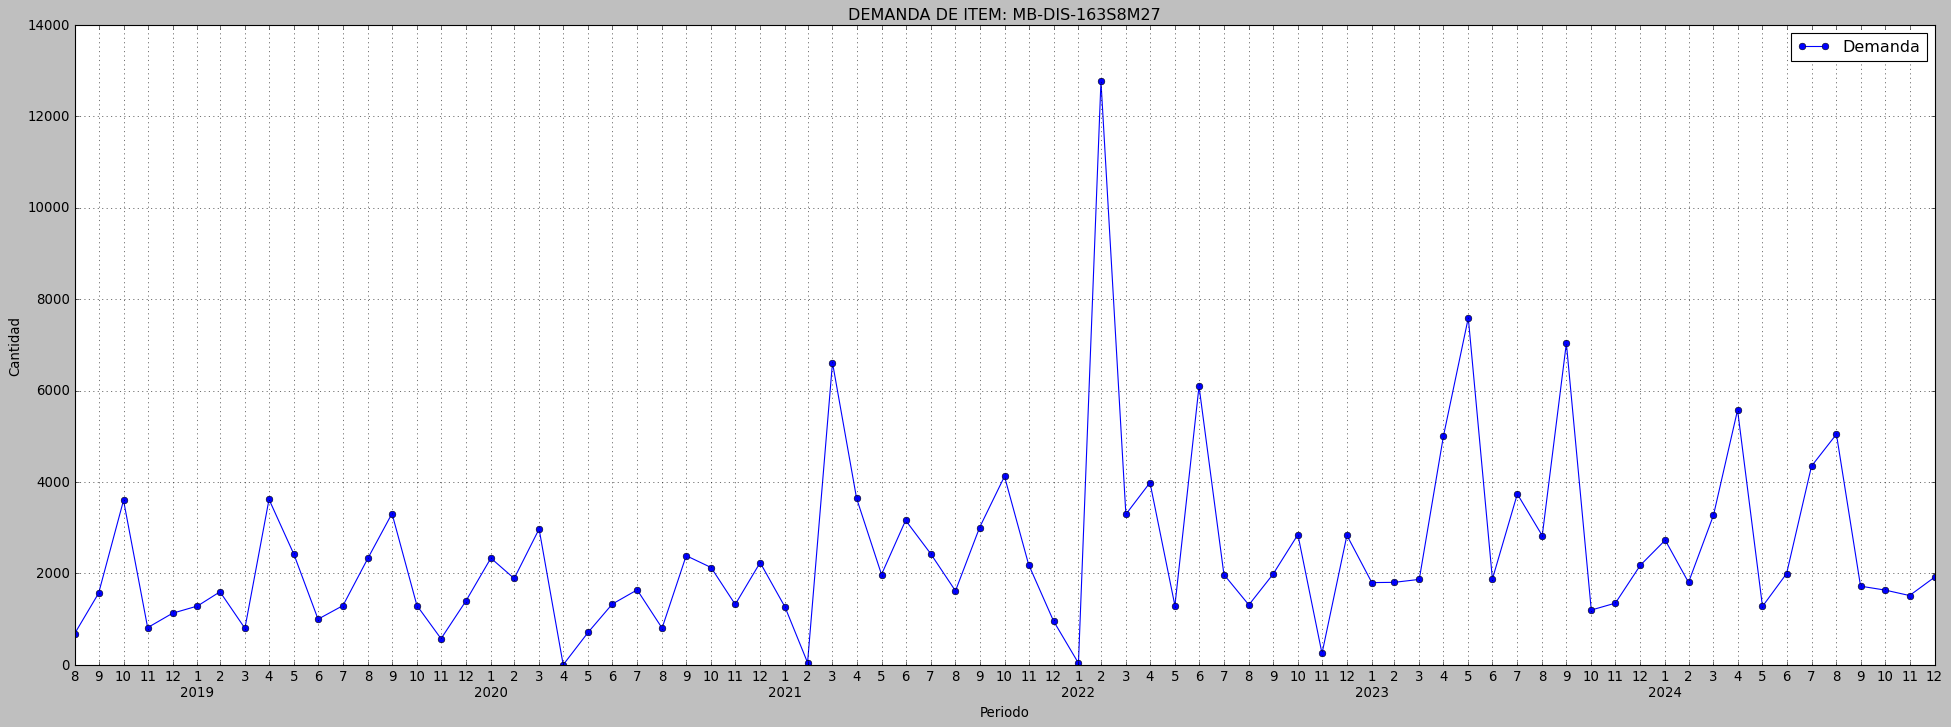

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Demanda", marker='o')
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

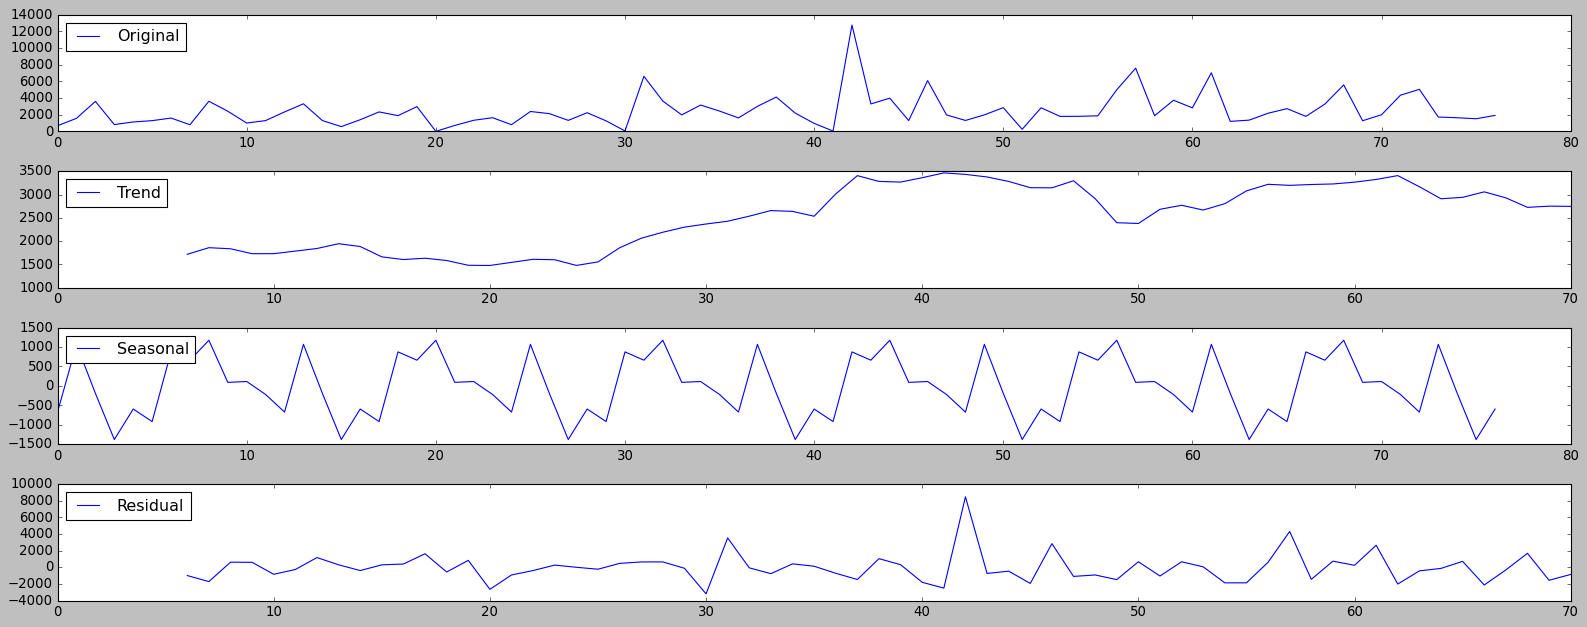

In [ ]:
# DESCOMPOSICION DE LA SERIE DE TIEMPO

result = seasonal_decompose(y, 
                            model='additive', 
                            period=12)  # Cambia el periodo según la frecuencia de tus datos

# Graficar los componentes
plt.figure(figsize=(20, 8))
plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# ESTADISTICOS DESCRIPTIVOS

df.describe()

FECHA  Total Cantidad  Total Ventas
count                           3903     3903.000000   3903.000000
mean   2022-01-20 14:53:13.235972352      412.747118   1222.526151
min              2018-08-08 00:00:00        1.000000      3.660000
25%              2019-12-13 00:00:00       30.000000    130.802750
50%              2022-04-28 00:00:00       82.000000    389.470700
75%              2024-01-25 00:00:00      260.000000   1039.985500
max              2025-05-08 00:00:00    25180.000000  40075.902000
std                              NaN     1447.853044   2978.755273

### 2.1 CLASIFICACION SEGUN PATRON DE DEMANDA

In [ ]:
# COEFICIENTE DE VARIABILIDAD
cv = y.std()/y.mean()
print(f"Coeficiente de variabilidad: {cv:.4f}")

# INTERVALO PROMEDIO ENTRE DEMANDAS (Average Inter Demand Interval (ADI))
total_periods = len(df_agrupado)
periods_with_demand = len(df_agrupado[df_agrupado['Total Cantidad'] > 0])
adi = total_periods / periods_with_demand
print(f"Intervalo Promedio entre Demandas (ADI): {adi:.2f}")

# COEFICIENTE DE VARIACION AL CUADRADO CV2
# Filtrar los períodos con demanda > 0
periods_with_demand = df_agrupado[df_agrupado['Total Cantidad'] > 0]

# Calcular la demanda promedio (μ) y la desviación estándar (σ)
mu = periods_with_demand['Total Cantidad'].mean()
sigma = periods_with_demand['Total Cantidad'].std()

# Asegurarse de que μ no sea 0 y calcular el Coeficiente de Variación (CV)
if mu != 0:
    cv = sigma / mu
    cv_squared = cv ** 2
    print(f"CV² (Coeficiente de Variación al Cuadrado): {cv_squared:.4f}")
else:
    print("La demanda promedio (μ) es 0, no se puede calcular el CV².")

# CLASIFICACION DE TS POR PATRON DE DEMANDA

if adi <= 1.32 and cv_squared <= 0.49:
    print("Suavizada (Smooth): SMA, SES, WMA, ARIMA")
elif adi > 1.32 and cv_squared <= 0.49:
    print("Intermitente: Croston, Syntetos-Boylan Approximation (SBA), TSB")
elif adi <= 1.32 and cv_squared > 0.49:
    print("Erratica (Erratic): SES")
else:
    print("Irregular: Croston, Syntetos-Boylan Approximation (SBA), TSB")

Coeficiente de variabilidad: 0.8039
Intervalo Promedio entre Demandas (ADI): 1.01
CV² (Coeficiente de Variación al Cuadrado): 0.6249
Erratica (Erratic): SES


### 2.2 ANALISIS DE DISTRIBUCION NORMAL

#### 2.2.1 Serie original

In [ ]:
# PRUEBA DE DISTRIBUCION NORMAL
# Prueba de Shapiro-Wilk
print("PRUEBA DE SHAPIRO-WILK")
stat, p = shapiro(y.dropna())
print("Estadístico de Shapiro-Wilk:", stat)
print("p-value:", p)
# Interpretación
# Ho: Los datos tienen una distribución normal
# H1: Los datos no tienen una distribución normal
if p > 0.05:
    print("Los datos siguen una distribución normal (no se rechaza H0).\n")
else:
    print("Los datos no siguen una distribución normal (se rechaza H0).\n")

# Prueba de Jarque-Bera
print("PRUEBA DE JARQUE-BERA")
stat, p = jarque_bera(y.dropna())
print("Estadístico de Jarque-Bera:", stat)
print("p-value:", p)
# Interpretación
if p > 0.05:
    print("Los datos siguen una distribución normal (no se rechaza H0).\n")
else:
    print("Los datos no siguen una distribución normal (se rechaza H0).\n")

# Prueba de Kolmogorov-Smirnov
print("PRUEBA DE KS")
stat, p = kstest(y.dropna(), 'norm', 
                 args=(y.mean(), 
                       y.std()))
print("Estadístico de Kolmogorov-Smirnov:", stat)
print("p-value:", p)
# Interpretación
if p > 0.05:
    print("Los datos siguen una distribución normal (no se rechaza H0).\n")
else:
    print("Los datos no siguen una distribución normal (se rechaza H0).\n")

PRUEBA DE SHAPIRO-WILK
Estadístico de Shapiro-Wilk: 0.7898513101684301
p-value: 4.038069846428774e-09
Los datos no siguen una distribución normal (se rechaza H0).

PRUEBA DE JARQUE-BERA
Estadístico de Jarque-Bera: 317.8325777079786
p-value: 9.627924282558119e-70
Los datos no siguen una distribución normal (se rechaza H0).

PRUEBA DE KS
Estadístico de Kolmogorov-Smirnov: 0.17995165604119606
p-value: 0.01183555874948039
Los datos no siguen una distribución normal (se rechaza H0).



In [ ]:
#CALCULO DE SKEWNESS
# Cálculo del sesgo
# Si >0 = sesgado a la derecha
# Si <0 = sesgado a la izquierda
# Si = 0 = simétrico
sesgo = skew(y.dropna())
print("Sesgo", sesgo)

if sesgo > 0:
    print("Distribución sesgada a la derecha.")
elif sesgo < 0:
    print("Distribución sesgada a la izquierda.")
else:
    print("Distribución simétrica.")

Sesgo 2.433323589872779
Distribución sesgada a la derecha.


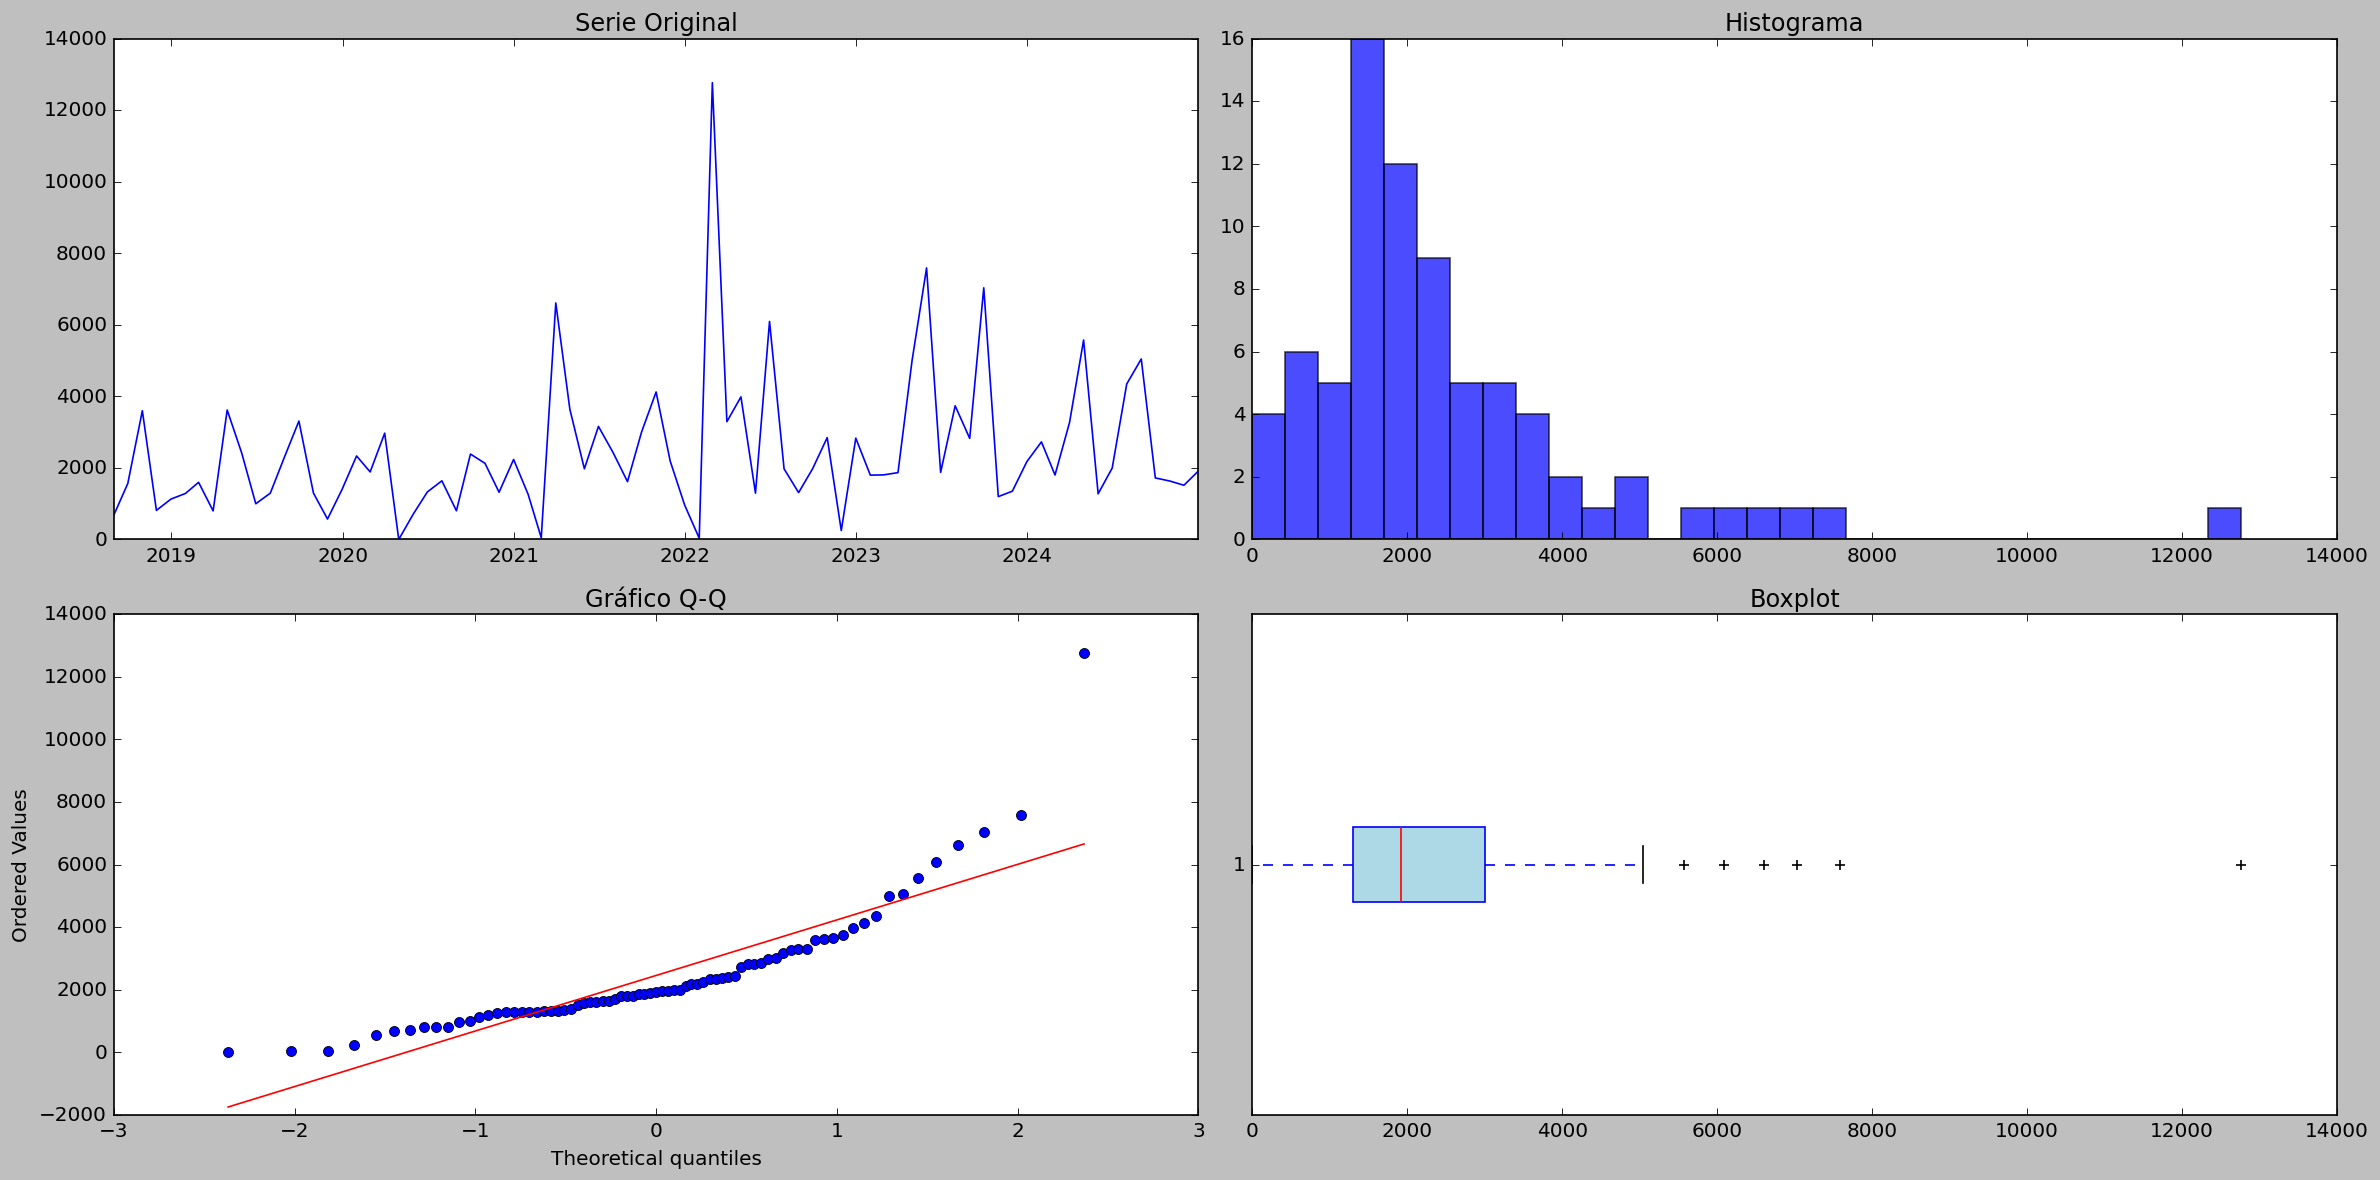

In [ ]:
# GRAFICO DE PLOTS

plt.rcParams.update({'figure.figsize': (20, 10), 
                     'figure.dpi': 120})
fig, axes = plt.subplots(2, 
                         2, 
                         sharex=False)

# Serie original
axes[0, 0].plot(x, 
                y)
axes[0, 0].set_title("Serie Original")

# Histograma
axes[0, 1].hist(y.dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].set_title("Histograma")

# Gráfico Q-Q
stats.probplot(y.dropna(), dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("Gráfico Q-Q")

# Grafico Box plot
axes[1, 1].boxplot(y.dropna(), vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
axes[1, 1].set_title("Boxplot")

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# Calculo del IQR
Q1 = np.percentile(y.dropna(), 25)
Q3 = np.percentile(y.dropna(), 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
# Filtrar los valores atípicos
outliers_IQR = y[(y < lower_bound) | (y > upper_bound)]
print("Valores atípicos:\n", outliers_IQR)

# A que meses corresonden los valores atípicos
outlier_dates_IQR = df_agrupado.loc[(df_agrupado['Total Cantidad'] < lower_bound) | 
                                  (df_agrupado['Total Cantidad'] > upper_bound), 'FECHA']
print("Meses con valores atípicos:\n", outlier_dates_IQR)

Q1: 1297.0, Q3: 3003.0, IQR: 1706.0
Lower Bound: -1262.0, Upper Bound: 5562.0
Valores atípicos:
 31     6610
42    12766
46     6093
57     7589
61     7034
68     5574
Name: Total Cantidad, dtype: int64
Meses con valores atípicos:
 31   2021-03-31
42   2022-02-28
46   2022-06-30
57   2023-05-31
61   2023-09-30
68   2024-04-30
Name: FECHA, dtype: datetime64[ns]


In [ ]:
# Calculo del Z-score

z_scores = (y - y.mean()) / y.std()
# Filtrar los valores atípicos
outliers_z = y[np.abs(z_scores) > 3]
print("Valores atípicos (Z-score):\n", outliers_z)
# A que meses corresonden los valores atípicos
outlier_dates_z = df_agrupado.loc[np.abs(z_scores) > 3, 'FECHA']
print("Meses con valores atípicos (Z-score):\n", outlier_dates_z)

Valores atípicos (Z-score):
 42    12766
Name: Total Cantidad, dtype: int64
Meses con valores atípicos (Z-score):
 42   2022-02-28
Name: FECHA, dtype: datetime64[ns]


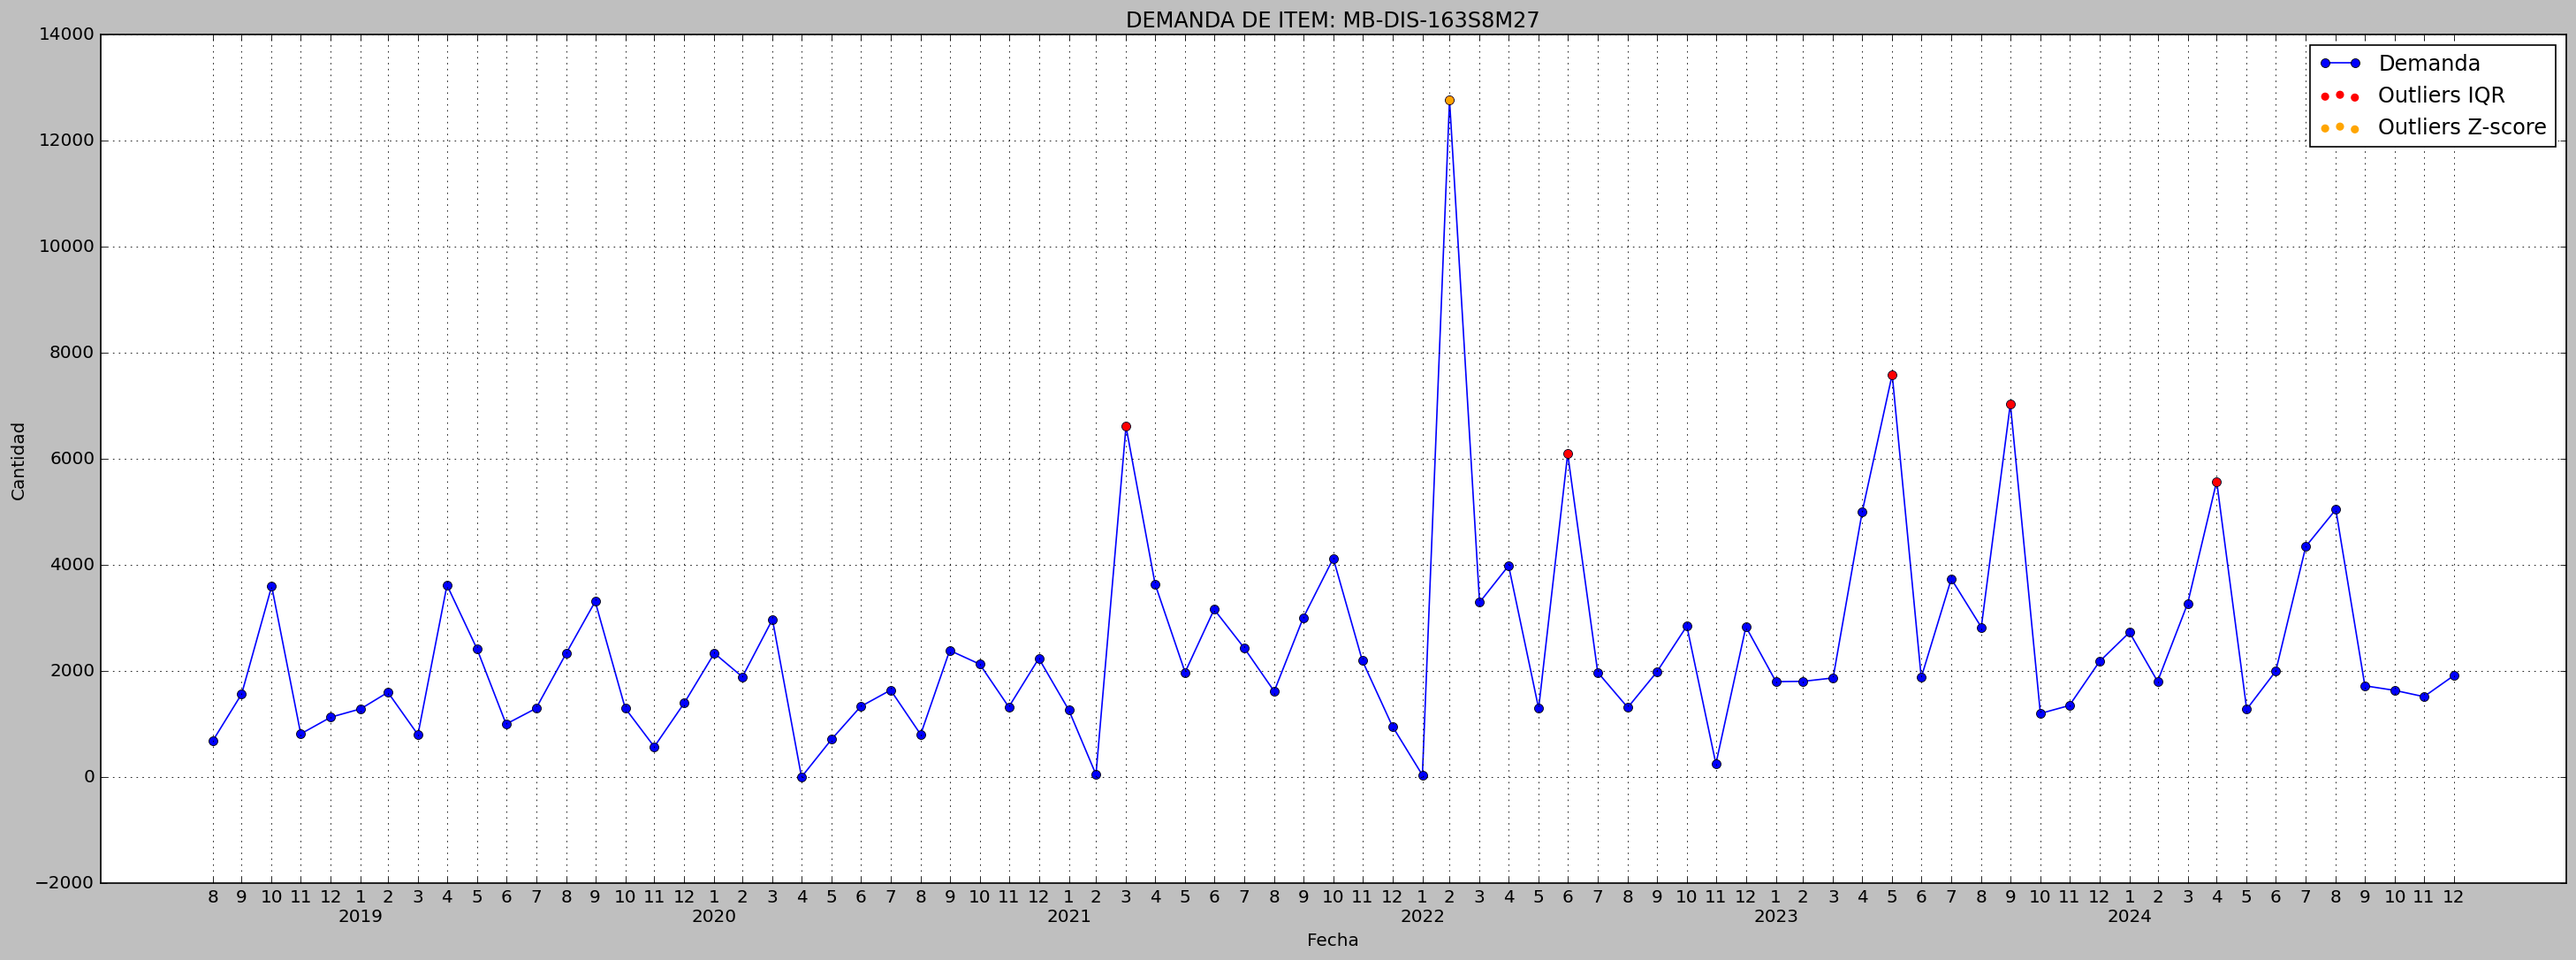

In [ ]:
# GRAFICO DE SERIE DE TIEMPO CON VALORES ATIPICOS

plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Demanda", marker='o')
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

# Resaltar los valores atípicos
plt.scatter(outlier_dates_IQR, outliers_IQR, color='red', label='Outliers IQR', zorder=5)
plt.scatter(outlier_dates_z, outliers_z, color='orange', label='Outliers Z-score', zorder=5)
plt.legend()
plt.show()
plt.close()

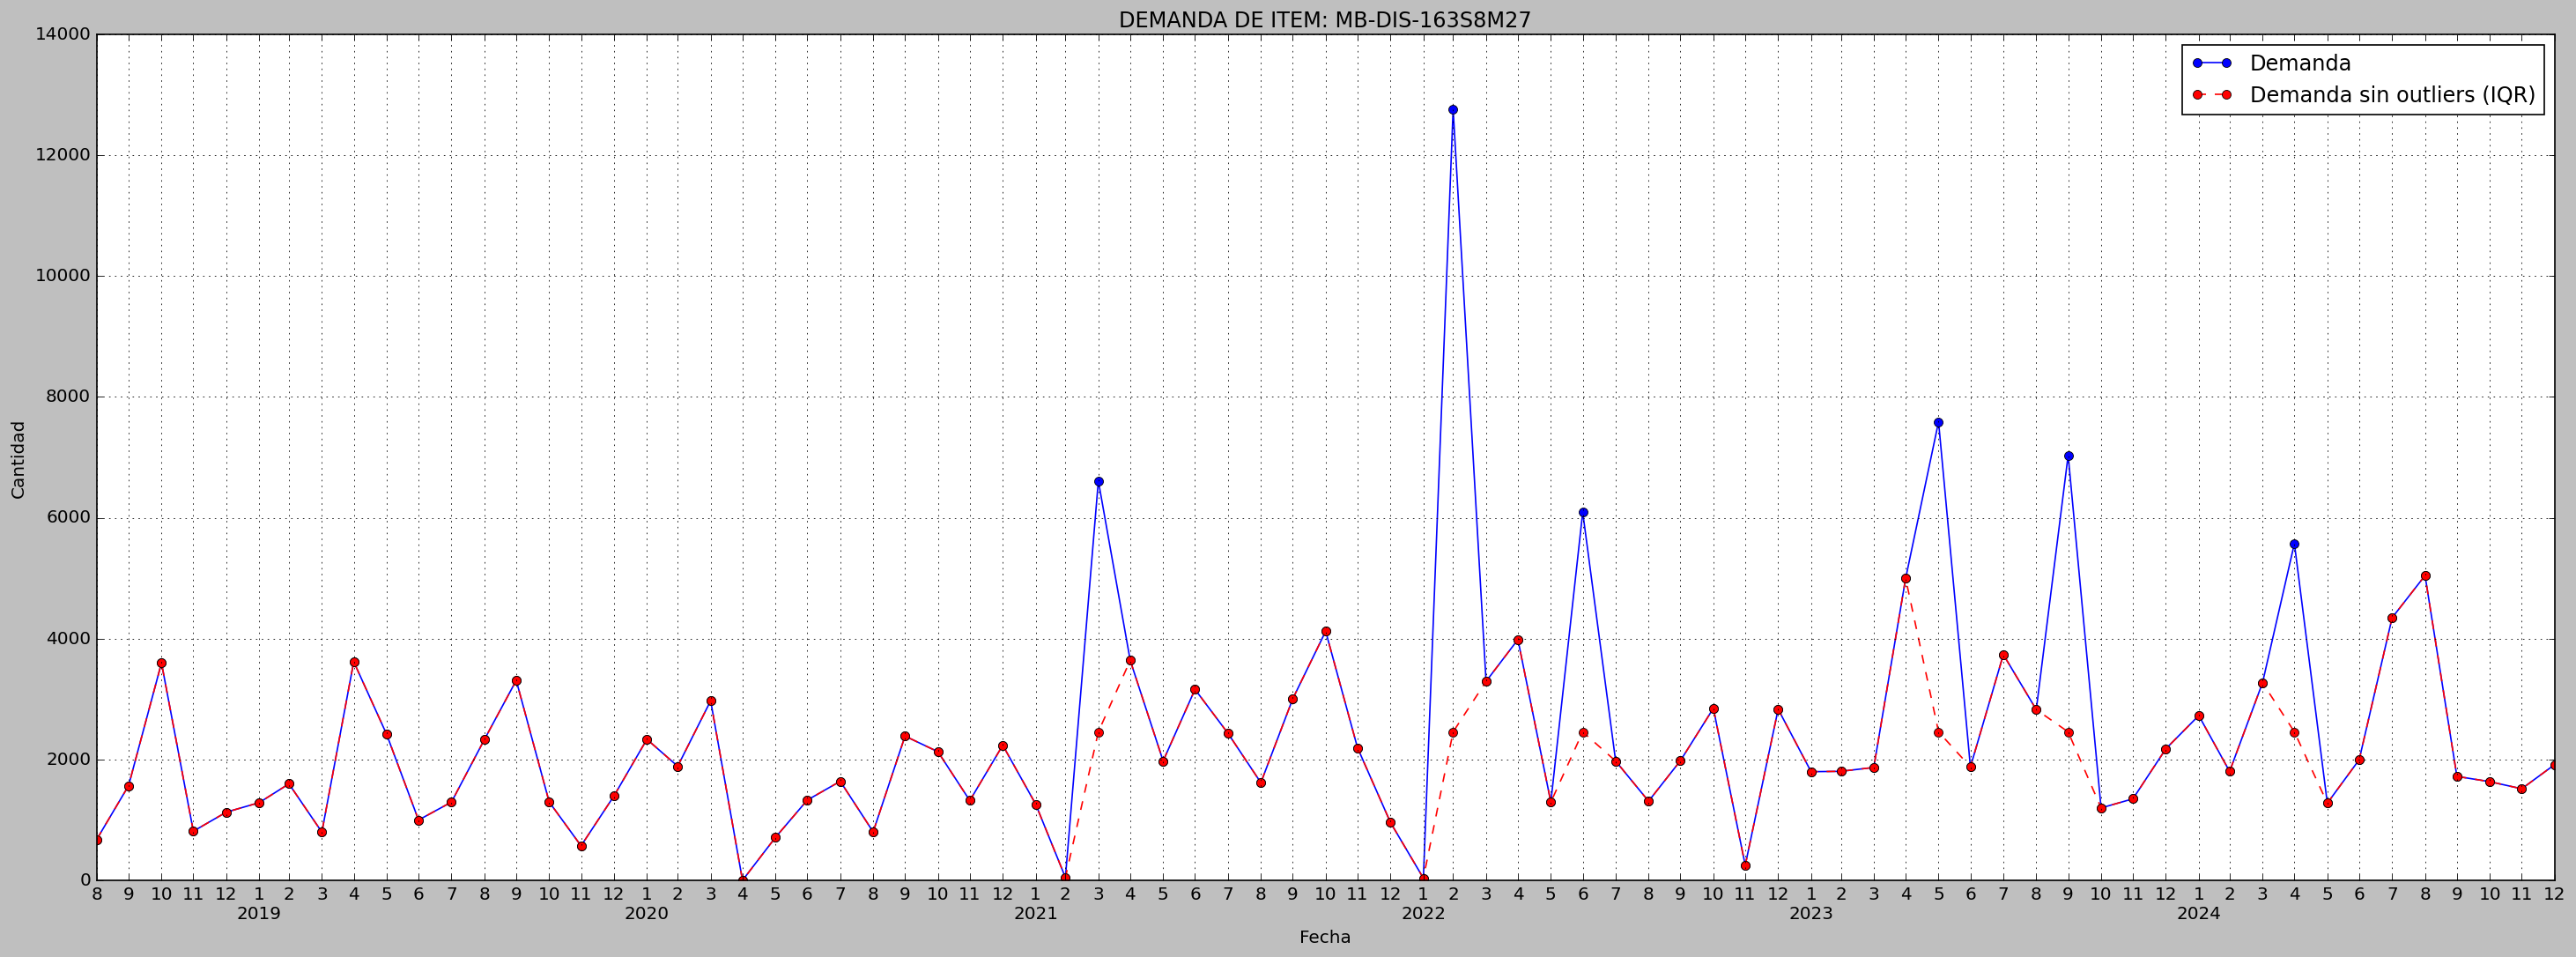

In [ ]:
# TRATAMIENTO DE VALORES ATIPICOS
# Reemplazar los valores atípicos por la media
y_no_outliers = y.copy()
y_no_outliers[(y < lower_bound) | (y > upper_bound)] = y.mean()
y_no_outliers_z = y.copy()
y_no_outliers_z[np.abs(z_scores) > 3] = y.mean()

# GRAFICO DE SERIE DE TIEMPO SIN VALORES ATIPICOS
plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Demanda", marker='o', linestyle='-')
plt.plot(x, y_no_outliers, label="Demanda sin outliers (IQR)", marker='o',linestyle='--', color='red')
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.grid()
# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero
# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)
plt.legend()
plt.show()
plt.close()

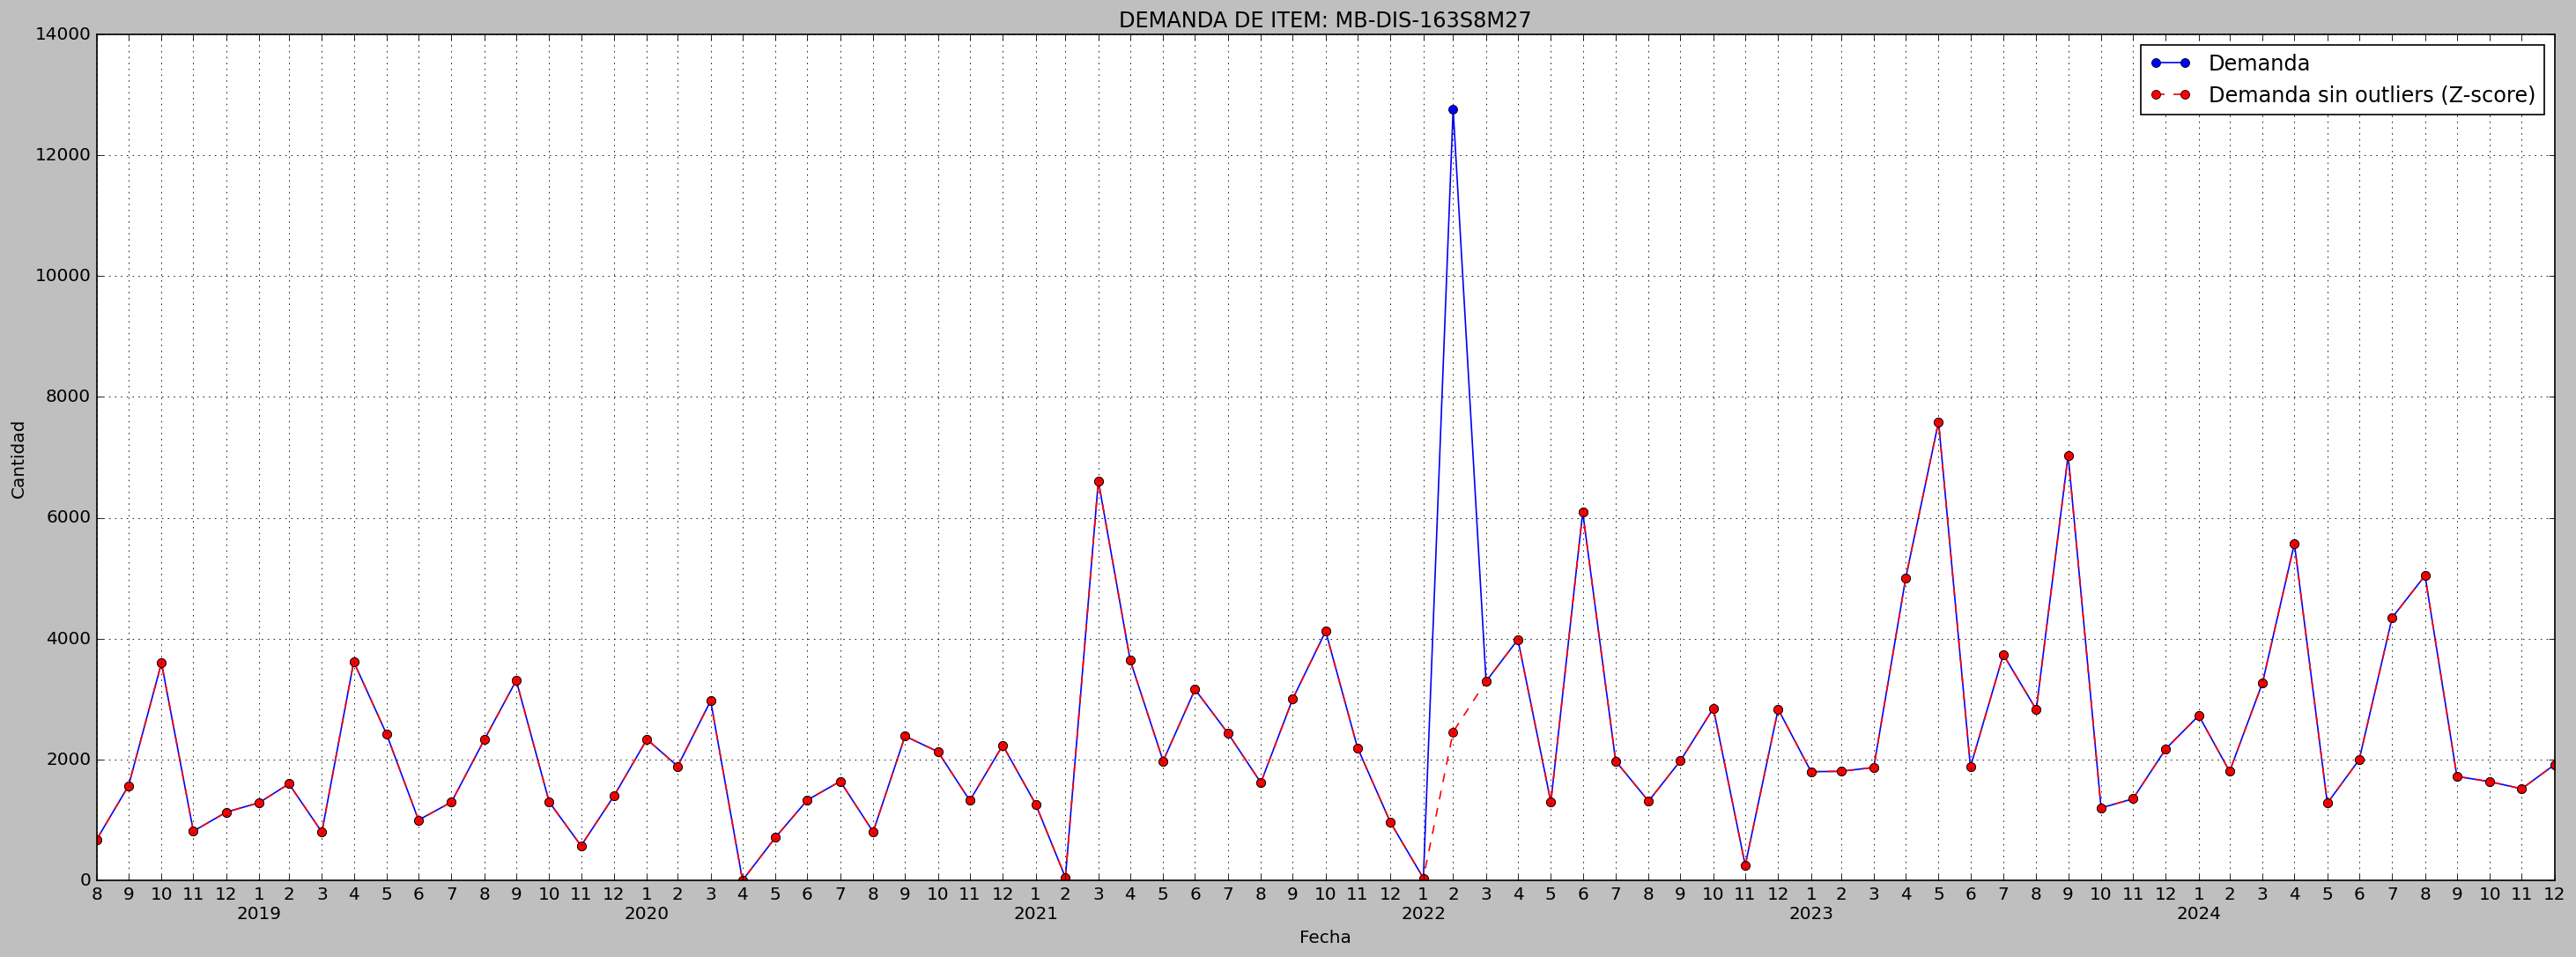

In [ ]:
# TRATAMIENTO DE VALORES ATIPICOS
# Reemplazar los valores atípicos por la media
y_no_outliers = y.copy()
y_no_outliers[(y < lower_bound) | (y > upper_bound)] = y.mean()
y_no_outliers_z = y.copy()
y_no_outliers_z[np.abs(z_scores) > 3] = y.mean()

# GRAFICO DE SERIE DE TIEMPO SIN VALORES ATIPICOS
plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Demanda", marker='o', linestyle='-')
plt.plot(x, y_no_outliers_z, label="Demanda sin outliers (Z-score)", marker='o',linestyle='--',color='red')
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.grid()
# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero
# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)
plt.legend()
plt.show()
plt.close()

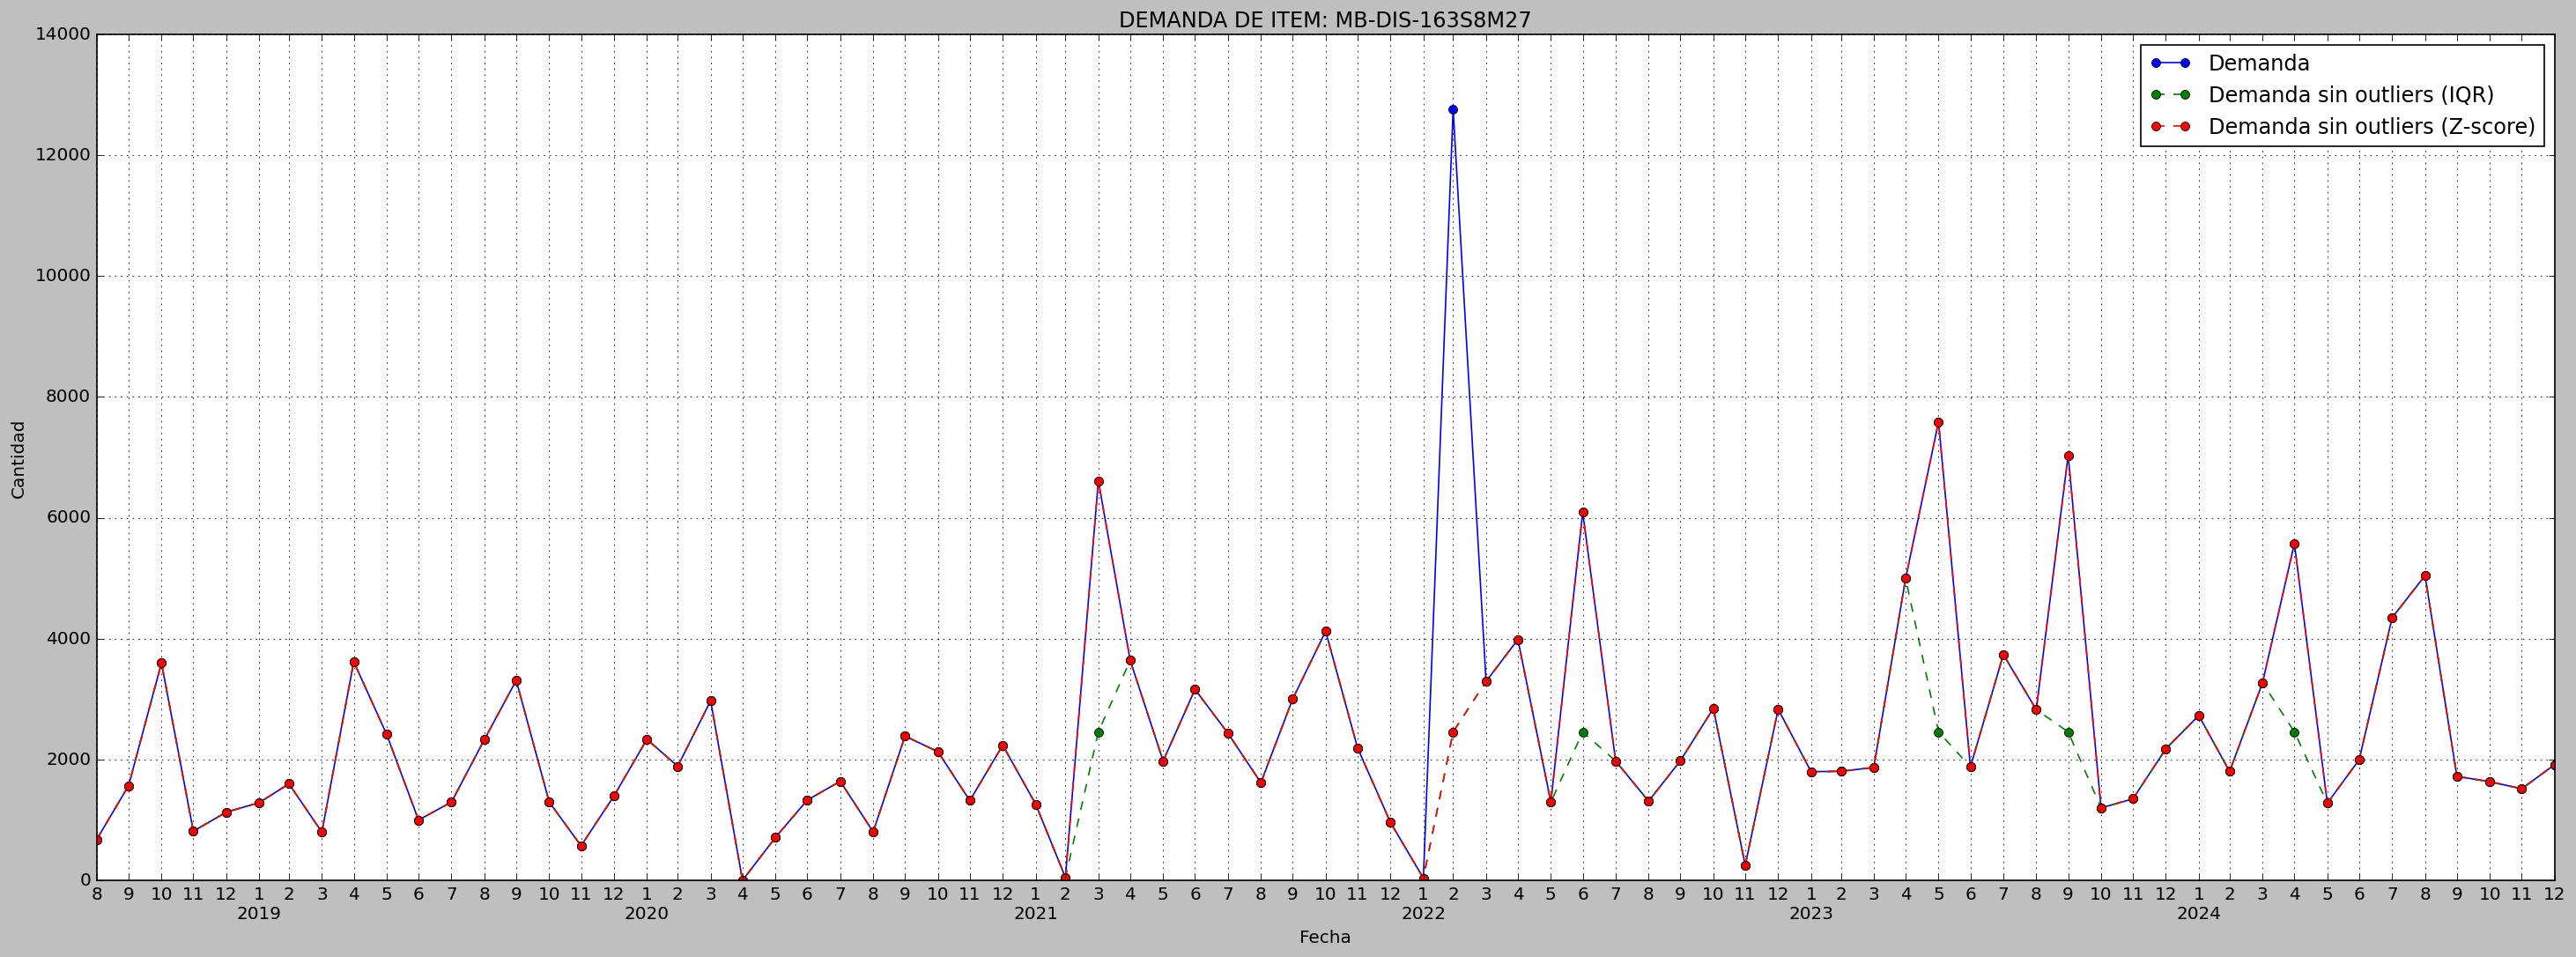

In [ ]:
# TRATAMIENTO DE VALORES ATIPICOS
# Reemplazar los valores atípicos por la media
y_no_outliers = y.copy()
y_no_outliers[(y < lower_bound) | (y > upper_bound)] = y.mean()
y_no_outliers_z = y.copy()
y_no_outliers_z[np.abs(z_scores) > 3] = y.mean()

# GRAFICO DE SERIE DE TIEMPO SIN VALORES ATIPICOS
plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Demanda", marker='o', linestyle='-')
plt.plot(x, y_no_outliers, label="Demanda sin outliers (IQR)", marker='o',linestyle='--')
plt.plot(x, y_no_outliers_z, label="Demanda sin outliers (Z-score)", marker='o',linestyle='--')
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.grid()
# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero
# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)
plt.legend()
plt.show()
plt.close()

In [ ]:
y = y_no_outliers

In [ ]:
# COEFICIENTE DE VARIABILIDAD
cv = y.std() / y.mean()
print(f"Coeficiente de variabilidad: {cv:.4f}")

# INTERVALO PROMEDIO ENTRE DEMANDAS (Average Inter Demand Interval (ADI))
total_periods = len(y)
periods_with_demand = len(y[y > 0])
adi = total_periods / periods_with_demand
print(f"Average Inter Demand Interval (ADI): {adi:.2f}")

# COEFICIENTE DE VARIACION AL CUADRADO CV2
# Filtrar los períodos con demanda > 0
periods_with_demand = y[y > 0]

# Calcular la demanda promedio (μ) y la desviación estándar (σ)
mu = periods_with_demand.mean()
sigma = periods_with_demand.std()

# Asegurarse de que μ no sea 0 y calcular el Coeficiente de Variación (CV)
if mu != 0:
    cv = sigma / mu
    cv_squared = cv ** 2
    print(f"CV² (Coeficiente de Variación al Cuadrado): {cv_squared:.4f}")
else:
    print("La demanda promedio (μ) es 0, no se puede calcular el CV².")

# MODELO MAS ADECUADO PARA ESTE TIPO DE DEMANDA
if adi <= 1.32 and cv_squared <= 0.49:
    print("Suavizada (Smooth): SMA, SES, WMA, ARIMA")
elif adi > 1.32 and cv_squared <= 0.49:
    print("Intermitente: Croston, Syntetos-Boylan Approximation (SBA), TSB")
elif adi <= 1.32 and cv_squared > 0.49:
    print("Erratica (Erratic): SES")
else:
    print("Irregular: Croston, Syntetos-Boylan Approximation (SBA), TSB")

Coeficiente de variabilidad: 0.5305
Average Inter Demand Interval (ADI): 1.01
CV² (Coeficiente de Variación al Cuadrado): 0.2646
Suavizada (Smooth): SMA, SES, WMA, ARIMA


## 3. IDENTIFICACION DEL MODELO

### 3.1 Analisis de estacionariedad (d)

In [ ]:
# PRUEBA DE RAIZ UNIDAD DE LA SERIE ORIGINAL (DICKEY-FULLER AUMENTADO)

results = adfuller(y)
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

# Interpretación 
# Ho: The time series is non-stationary. RAIZ UNITARIA 
# H1: The time series is stationary. NO RAIZ UNITARIA
if results[1] > 0.05:
    print("La serie es no estacionaria (no se rechaza H0).")
else:
    print("La serie es estacionaria (se rechaza H0).")

ADF Statistic: -7.021720
p-value: 0.000000
La serie es estacionaria (se rechaza H0).


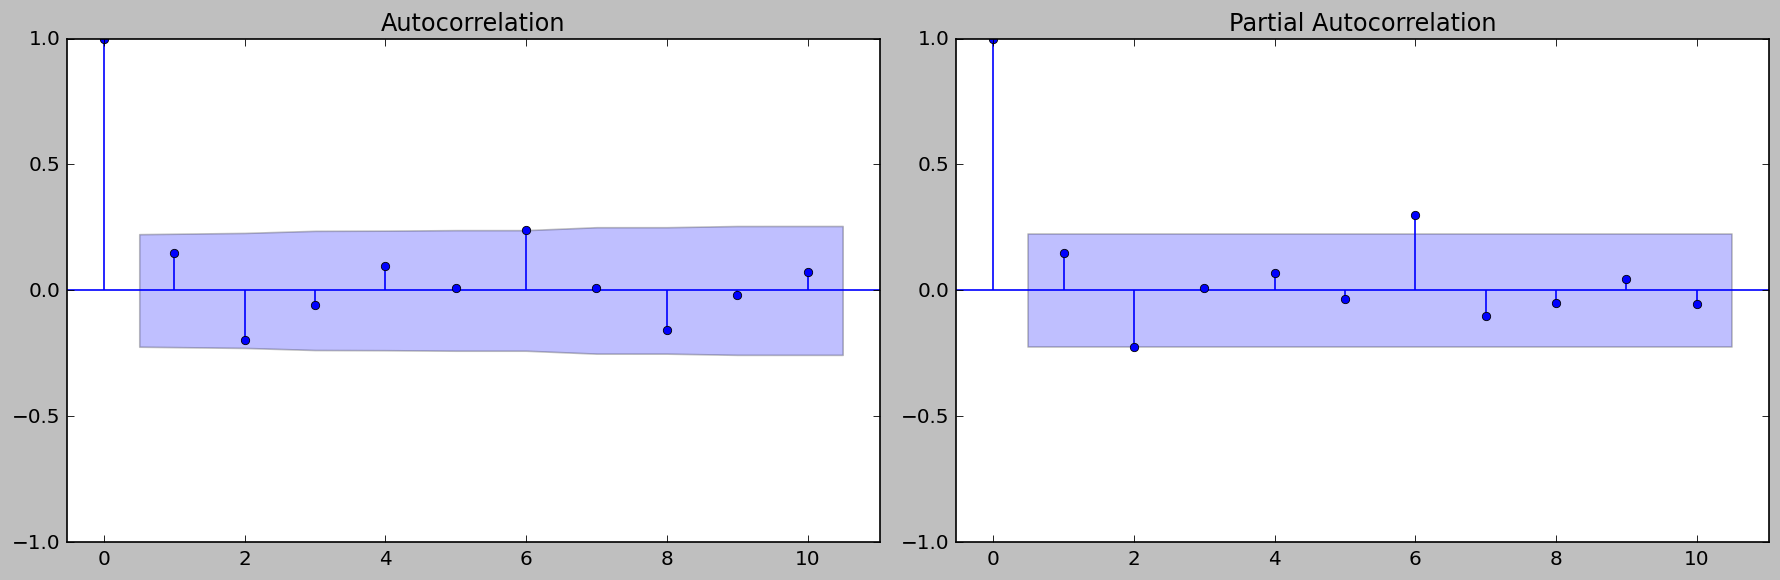

In [ ]:
# AUTOCORRELOGRAMA Y AUTOCORRELOGRAMA PARCIAL DE LA SERIE EN NIVELES
# Si la ACF tiene caida suave y la PACF tiene caida abrupta es no estacionario

plt.rcParams.update({'figure.figsize': (15, 5), 
                     'figure.dpi': 120})
fig, axes = plt.subplots(1, 
                         2, 
                         sharex=False)

# Autocorrelación en niveles
axes[0].set_title("Autocorrelación en niveles")
plot_acf(y.dropna(), 
         lags=10, 
         ax=axes[0])

# Autocorrelación parcial en niveles
axes[1].set_title("Autocorrelación Parcial en niveles") 
plot_pacf(y.dropna(), 
         lags=10, 
         ax=axes[1])

plt.tight_layout()
plt.show()
plt.close()

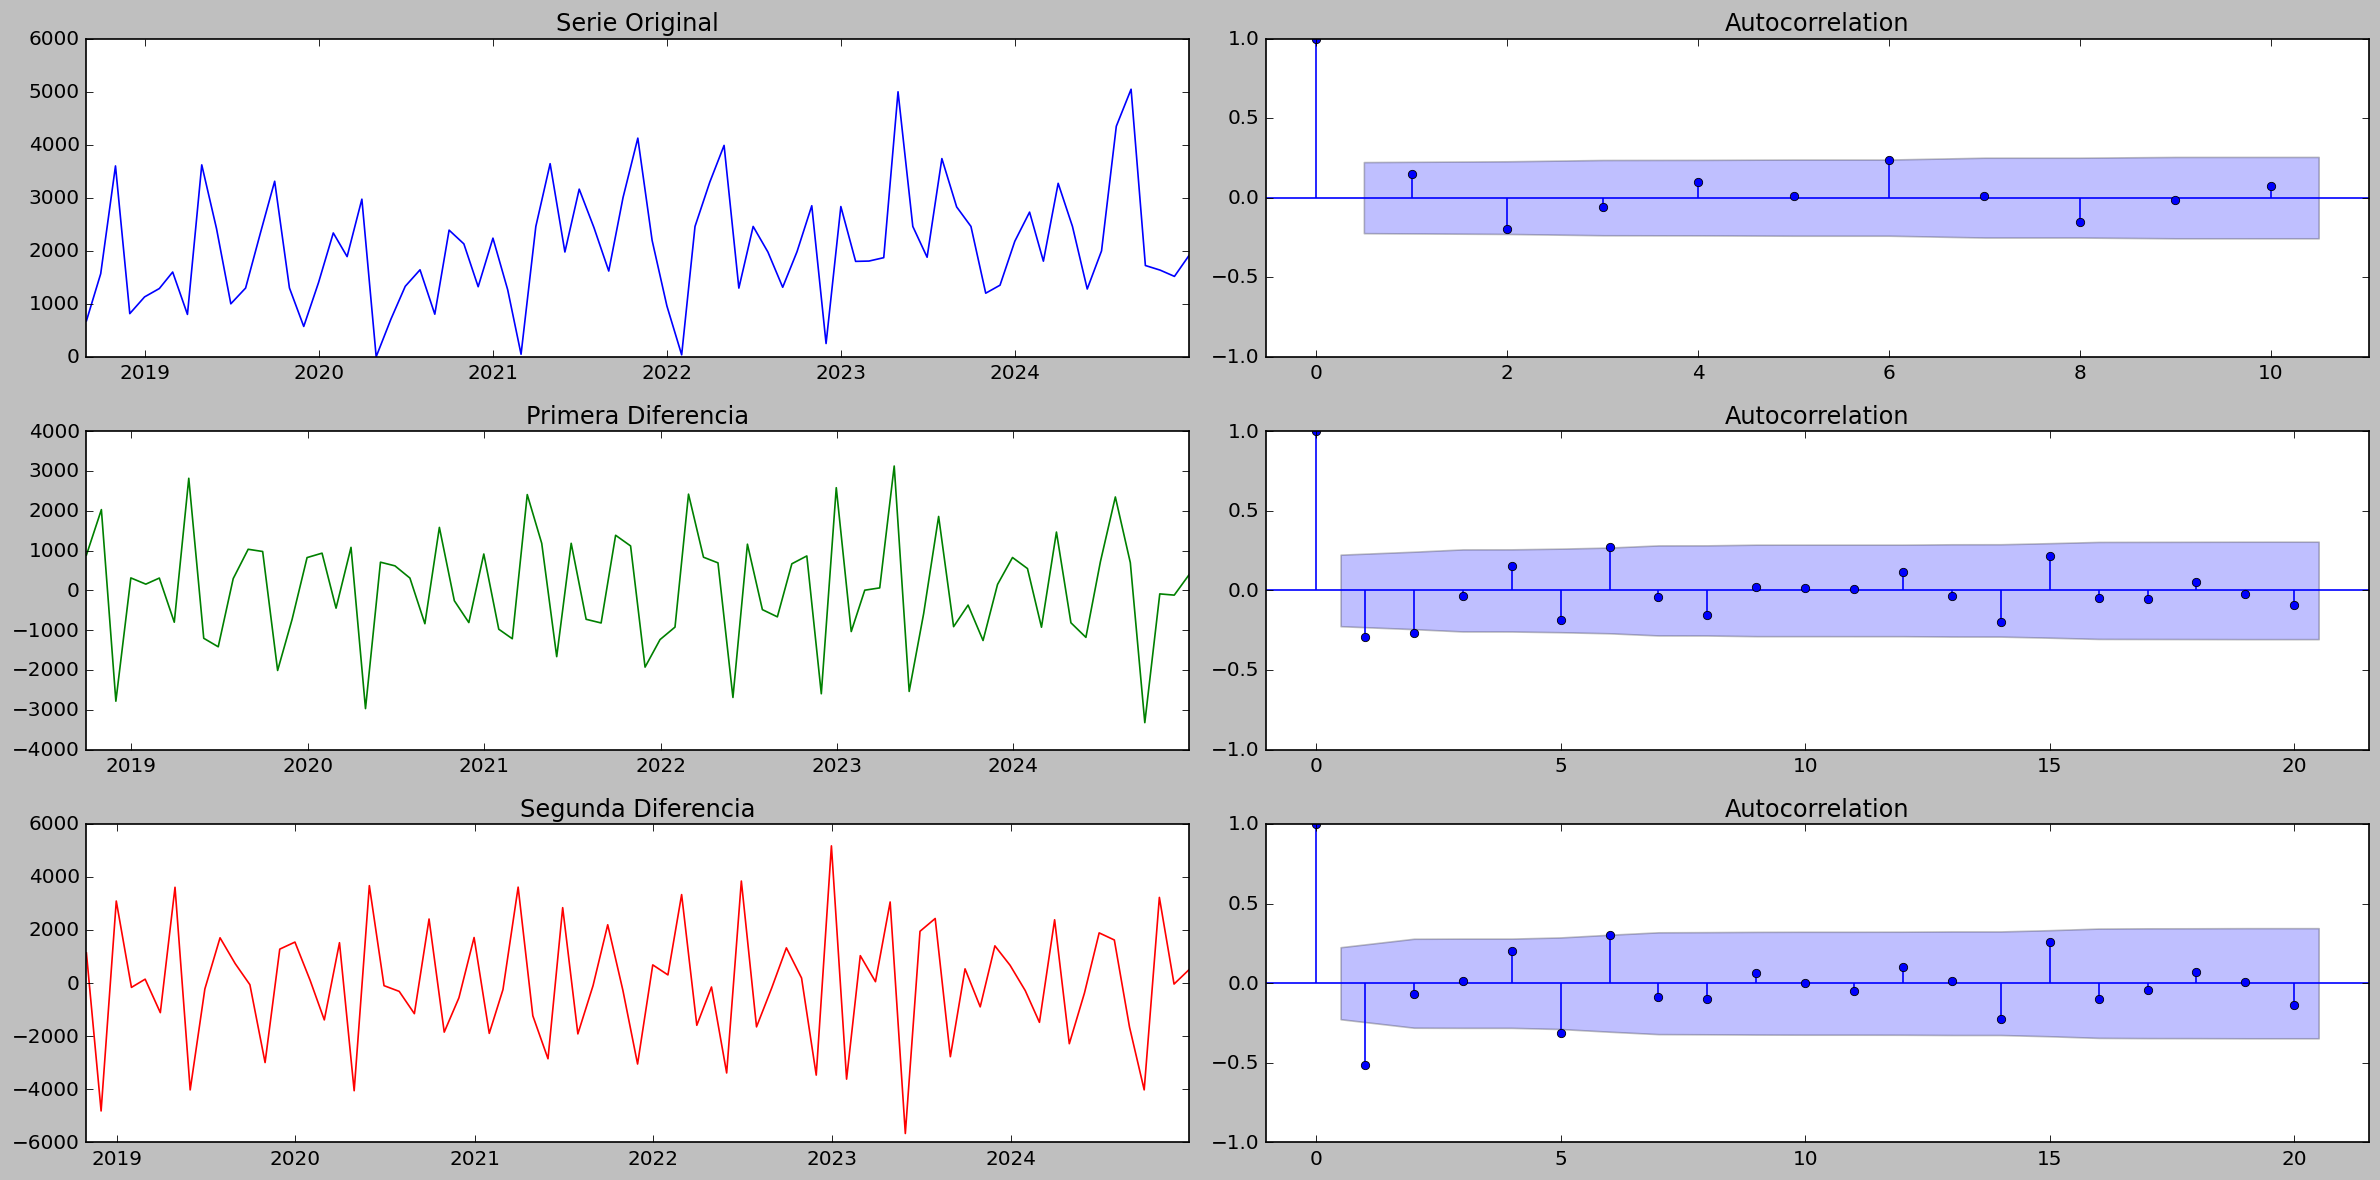

In [ ]:
# GRAFICO DE SERIE ORIGINAL Y SUS DIFERENCIAS

plt.rcParams.update({'figure.figsize': (20, 10), 
                     'figure.dpi': 120})
fig, axes = plt.subplots(3, 
                         2, 
                         sharex=False)

# Serie original
axes[0, 0].plot(x, 
                y)
axes[0, 0].set_title("Serie Original")
plot_acf(y, 
         lags=10, 
         ax=axes[0, 1])

# Primera diferencia
axes[1, 0].plot(x, 
                y.diff(), 
                color='g')
axes[1, 0].set_title("Primera Diferencia")
plot_acf(y.diff().dropna(), 
         lags=20, 
         ax=axes[1, 1])

# Segunda diferencia
axes[2, 0].plot(x, 
                y.diff().diff(), 
                color='r')
axes[2, 0].set_title("Segunda Diferencia")
plot_acf(y.diff().diff().dropna(), 
         lags=20, 
         ax=axes[2, 1])

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
#PRUEBA DE ESTACINOARIEDAD DE LA PRIMERA DIFERENCIA

results = adfuller(y.diff().dropna())
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

# Interpretación
# Ho: The time series is non-stationary.
# H1: The time series is stationary.
if results[1] > 0.05:
    print("La serie es no estacionaria (no se rechaza H0).")
else:
    print("La serie es estacionaria (se rechaza H0).")

ADF Statistic: -8.588701
p-value: 0.000000
La serie es estacionaria (se rechaza H0).


In [ ]:
#PRUEBA DE ESTACINOARIEDAD DE LA SEGUNDA DIFERENCIA

results = adfuller(y.diff().diff().dropna())
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

# Interpretación
# Ho: The time series is non-stationary.
# H1: The time series is stationary.
if results[1] > 0.05:
    print("La serie es no estacionaria (no se rechaza H0).")
else:
    print("La serie es estacionaria (se rechaza H0).")

ADF Statistic: -6.257282
p-value: 0.000000
La serie es estacionaria (se rechaza H0).


### 3.2 Analisis de proceso Autoregresivo (p)

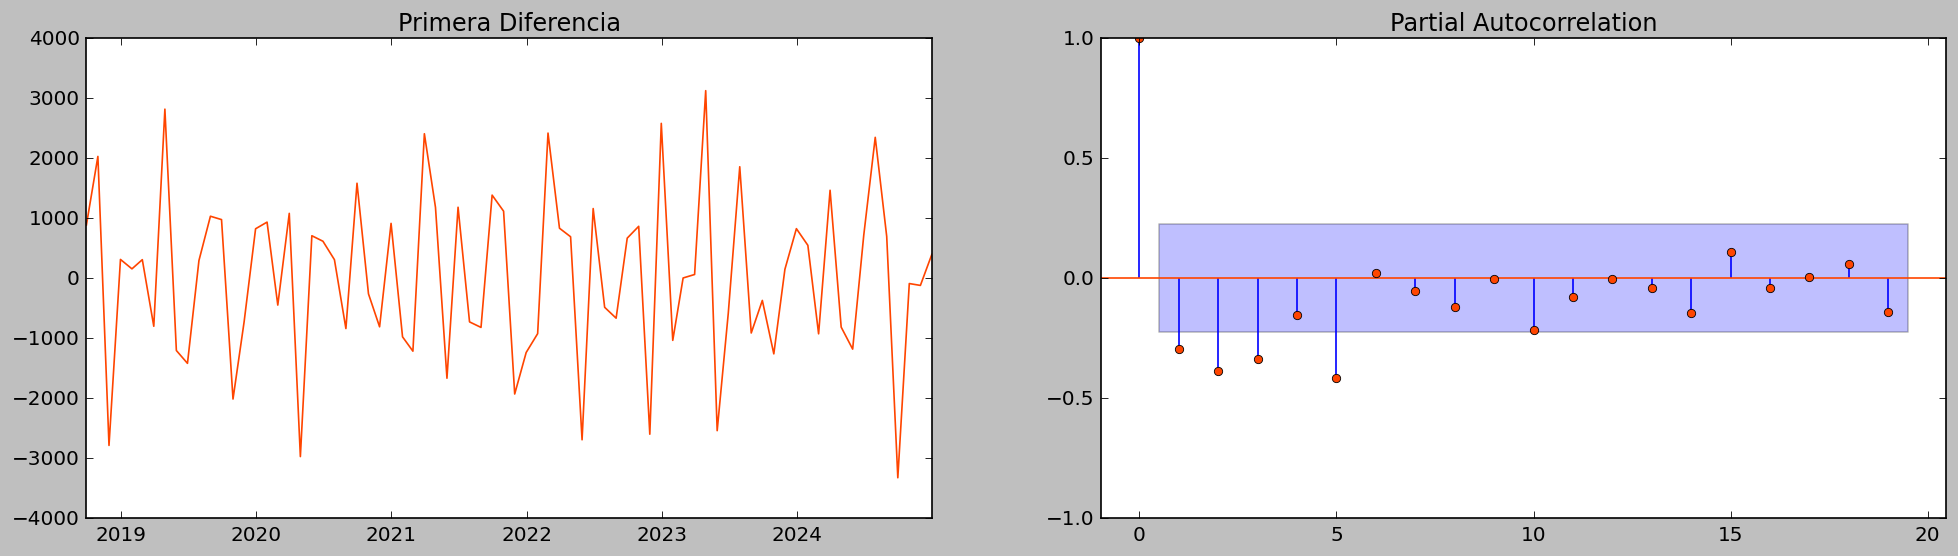

In [ ]:
# HALLAMOS EL ORDEN DE AR

#PACF plot de la primera diferencia
plt.rcParams.update({'figure.figsize': (20, 5),
                     'figure.dpi': 120})

fig, axes=plt.subplots(1, 2, sharex=False)
axes[0].plot(x,
                y.diff(), 
                color='orangered'); axes[0].set_title("Primera Diferencia")
axes[1].set(ylim=(-1, 4))
plot_pacf(y.diff().dropna(), ax= axes[1], color= "orangered")
plt.show()   

DETERMINAMOS QUE EL ORDEN DE AR p es 1, 2, 9

### 3.2 Analisis de proceso de Medias Moviles (q)

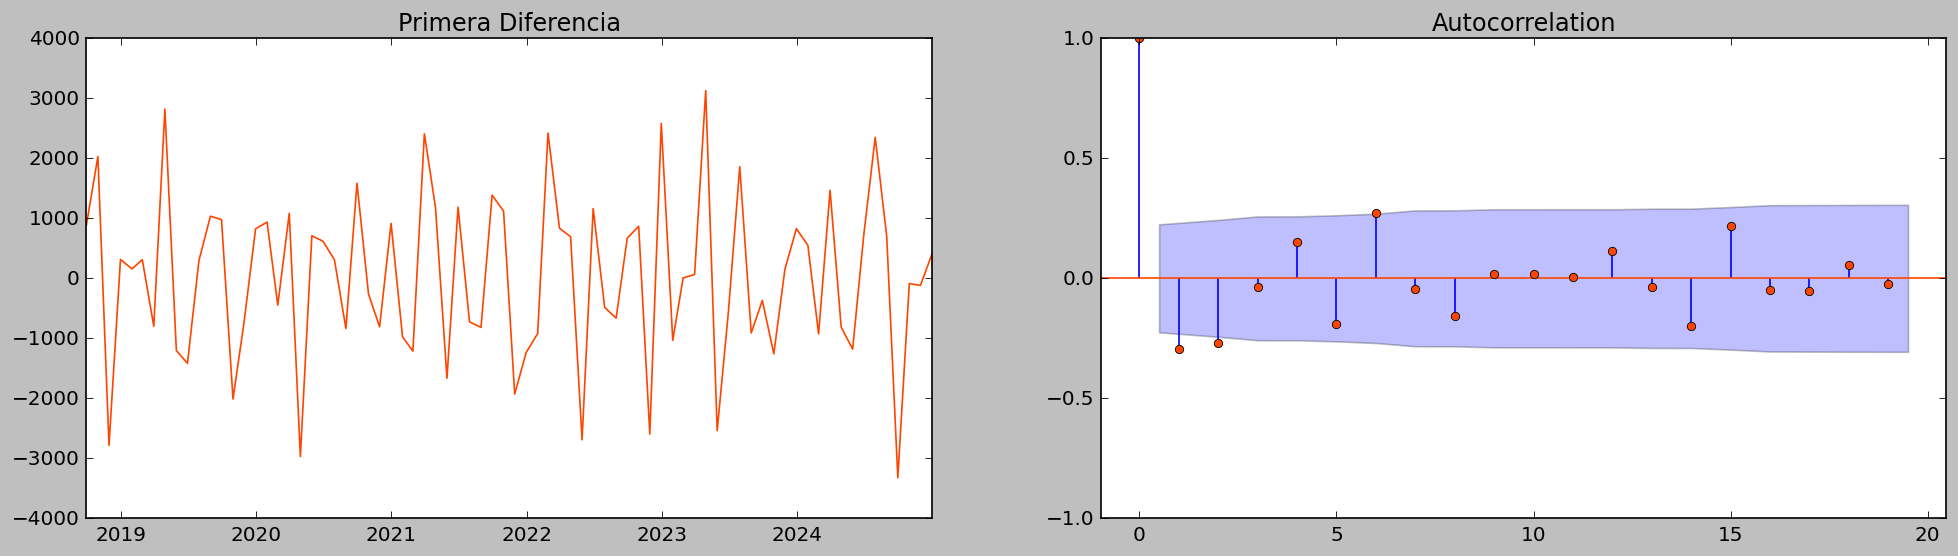

In [ ]:
# HALLAMOS EL ORDEN DE MA

#ACF plot de la primera diferencia
plt.rcParams.update({'figure.figsize': (20, 5),
                     'figure.dpi': 120})

fig, axes=plt.subplots(1, 2, sharex=False)
axes[0].plot(x,
            y.diff(), 
            color='orangered'); axes[0].set_title("Primera Diferencia")
axes[1].set(ylim=(-1, 4))
plot_acf(y.diff().dropna(), ax= axes[1], color= "orangered")
plt.show()   

SE DETERMINA QUE EL ORDEN MA de q es 1

SE CONCLUYE QUE LOS MEJORES MODELOS ARIMA(p,d,q) POSIBLES SON:
- modelo1 = ARIMA(1,0,1)
- modelo2 = ARIMA(2,0,1)
- modelo3 = ARIMA(9,0,1)
- modelo4 = autoarima

Por otro lado se hara tambien la prueba de dichos modelos con la primera diferencia.

## 4. ESTIMACION DEL MODELO

### 4.1 Modelo1

In [ ]:
# ARIMA model1

model1 = ARIMA(y,
               order=(1, 0, 1))

model1_fit = model1.fit()

print(model1_fit.summary())

# Ho: X=0
# H1: X!=0
# Si p-value < 0.05, se rechaza H0 , lo que indica que el coeficiente es significativo.
# Si p-value > 0.05, no se rechaza H0, lo que indica que el coeficiente no es significativo.

                               SARIMAX Results                                
Dep. Variable:         Total Cantidad   No. Observations:                   77
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -645.557
Date:                Fri, 16 May 2025   AIC                           1299.114
Time:                        11:40:19   BIC                           1308.489
Sample:                             0   HQIC                          1302.864
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2055.2916    147.913     13.895      0.000    1765.387    2345.196
ar.L1         -0.2237      0.591     -0.378      0.705      -1.382       0.935
ma.L1          0.4337      0.568      0.764      0.4

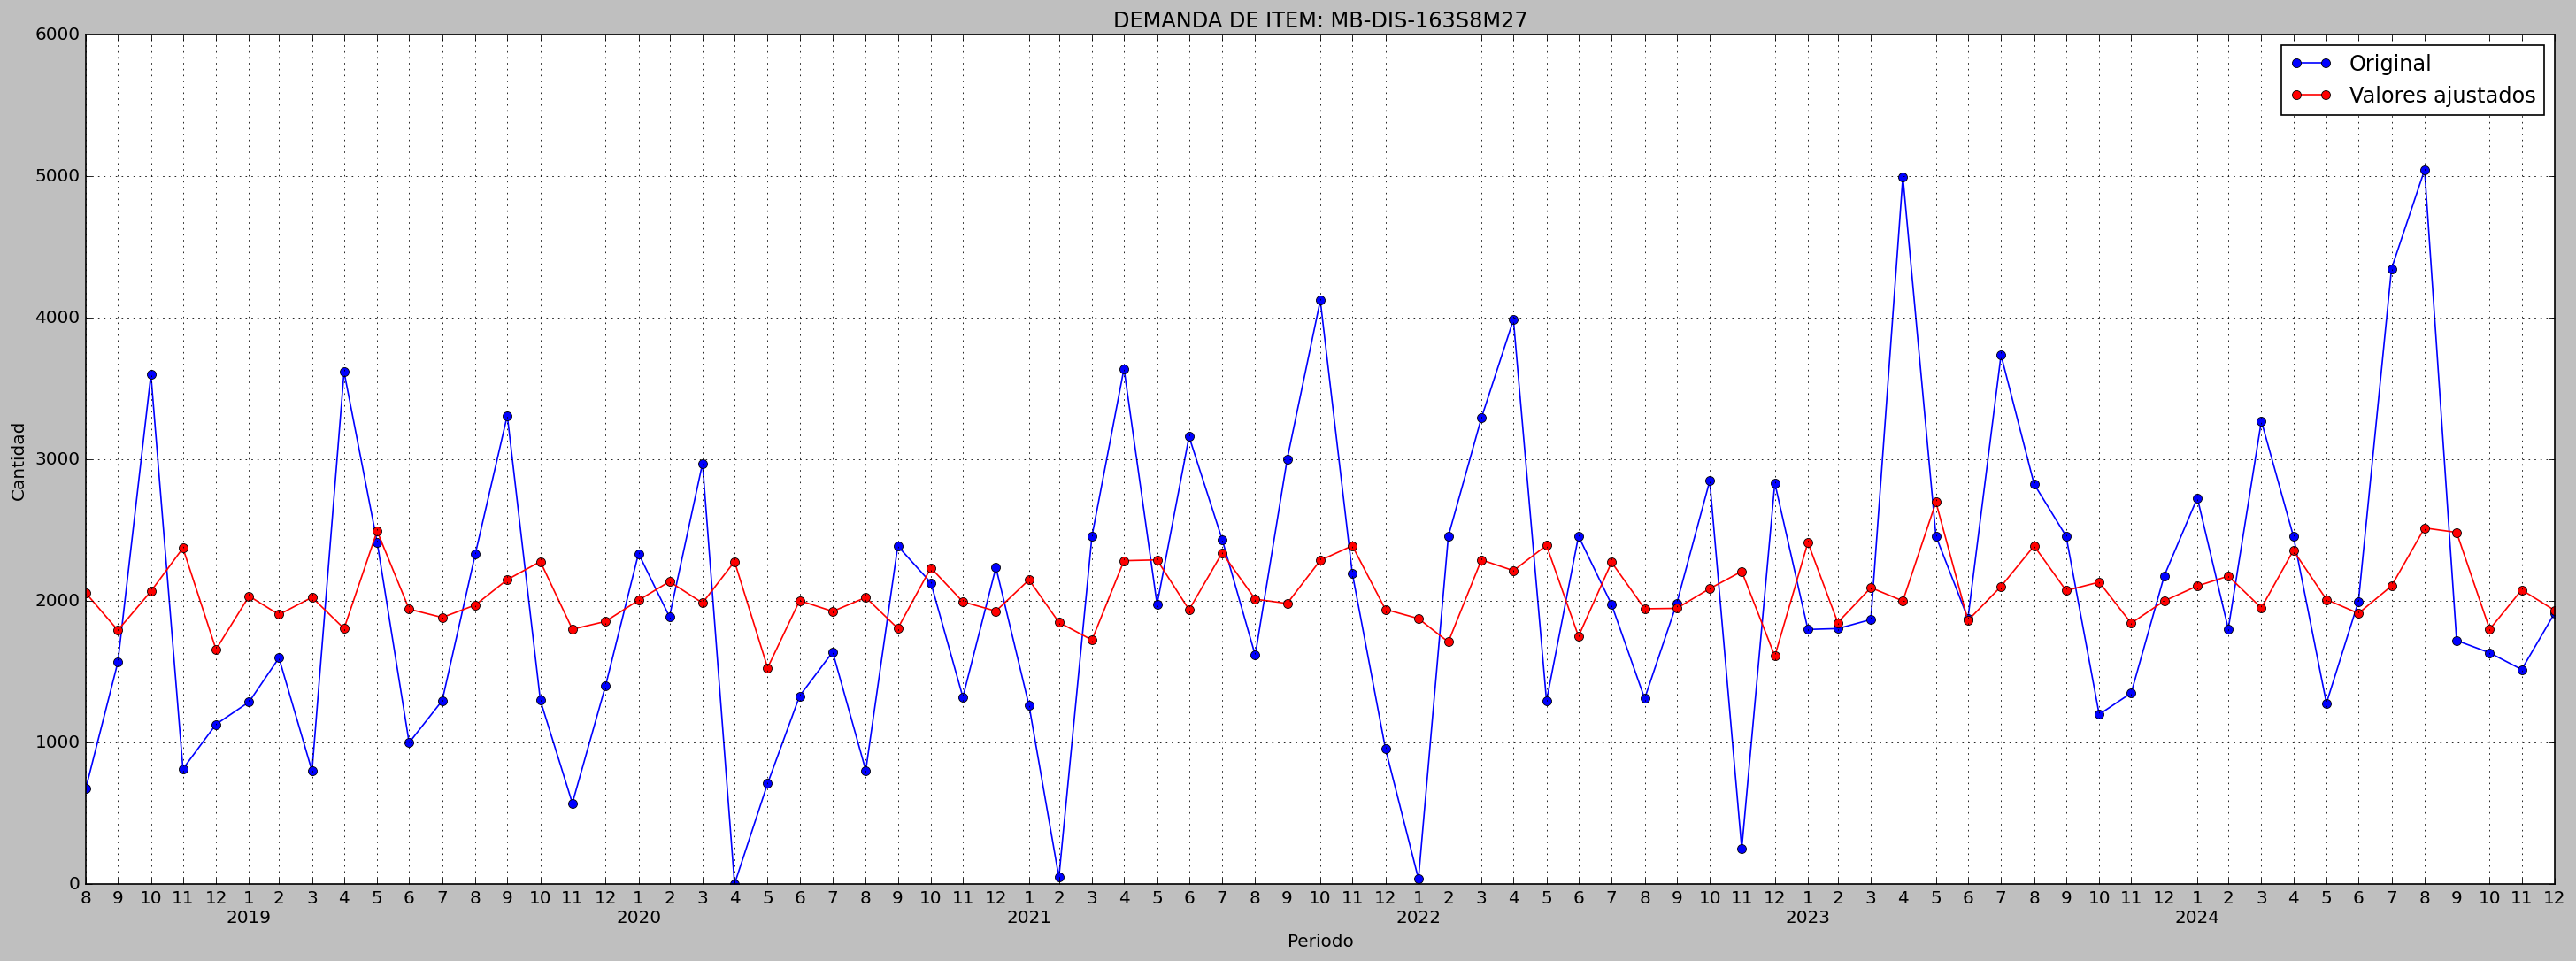

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Original", color="blue", marker="o")
plt.plot(x, model1_fit.fittedvalues, label='Valores ajustados', color='red',marker="o")
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

### 4.2 Modelo2

In [ ]:
# ARIMA model2

from statsmodels.tsa.arima.model import ARIMA

model2 = ARIMA(y,
               order=(2, 0, 1))

model2_fit = model2.fit()

print(model2_fit.summary())

# Ho: X=0
# H1: X!=0
# Si p-value < 0.05, se rechaza H0 , lo que indica que el coeficiente es significativo.
# Si p-value > 0.05, no se rechaza H0, lo que indica que el coeficiente no es significativo.

                               SARIMAX Results                                
Dep. Variable:         Total Cantidad   No. Observations:                   77
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -644.480
Date:                Fri, 16 May 2025   AIC                           1298.961
Time:                        11:40:20   BIC                           1310.680
Sample:                             0   HQIC                          1303.648
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2055.2918    119.195     17.243      0.000    1821.673    2288.910
ar.L1          0.1650      0.493      0.335      0.738      -0.801       1.131
ar.L2         -0.2204      0.164     -1.341      0.1

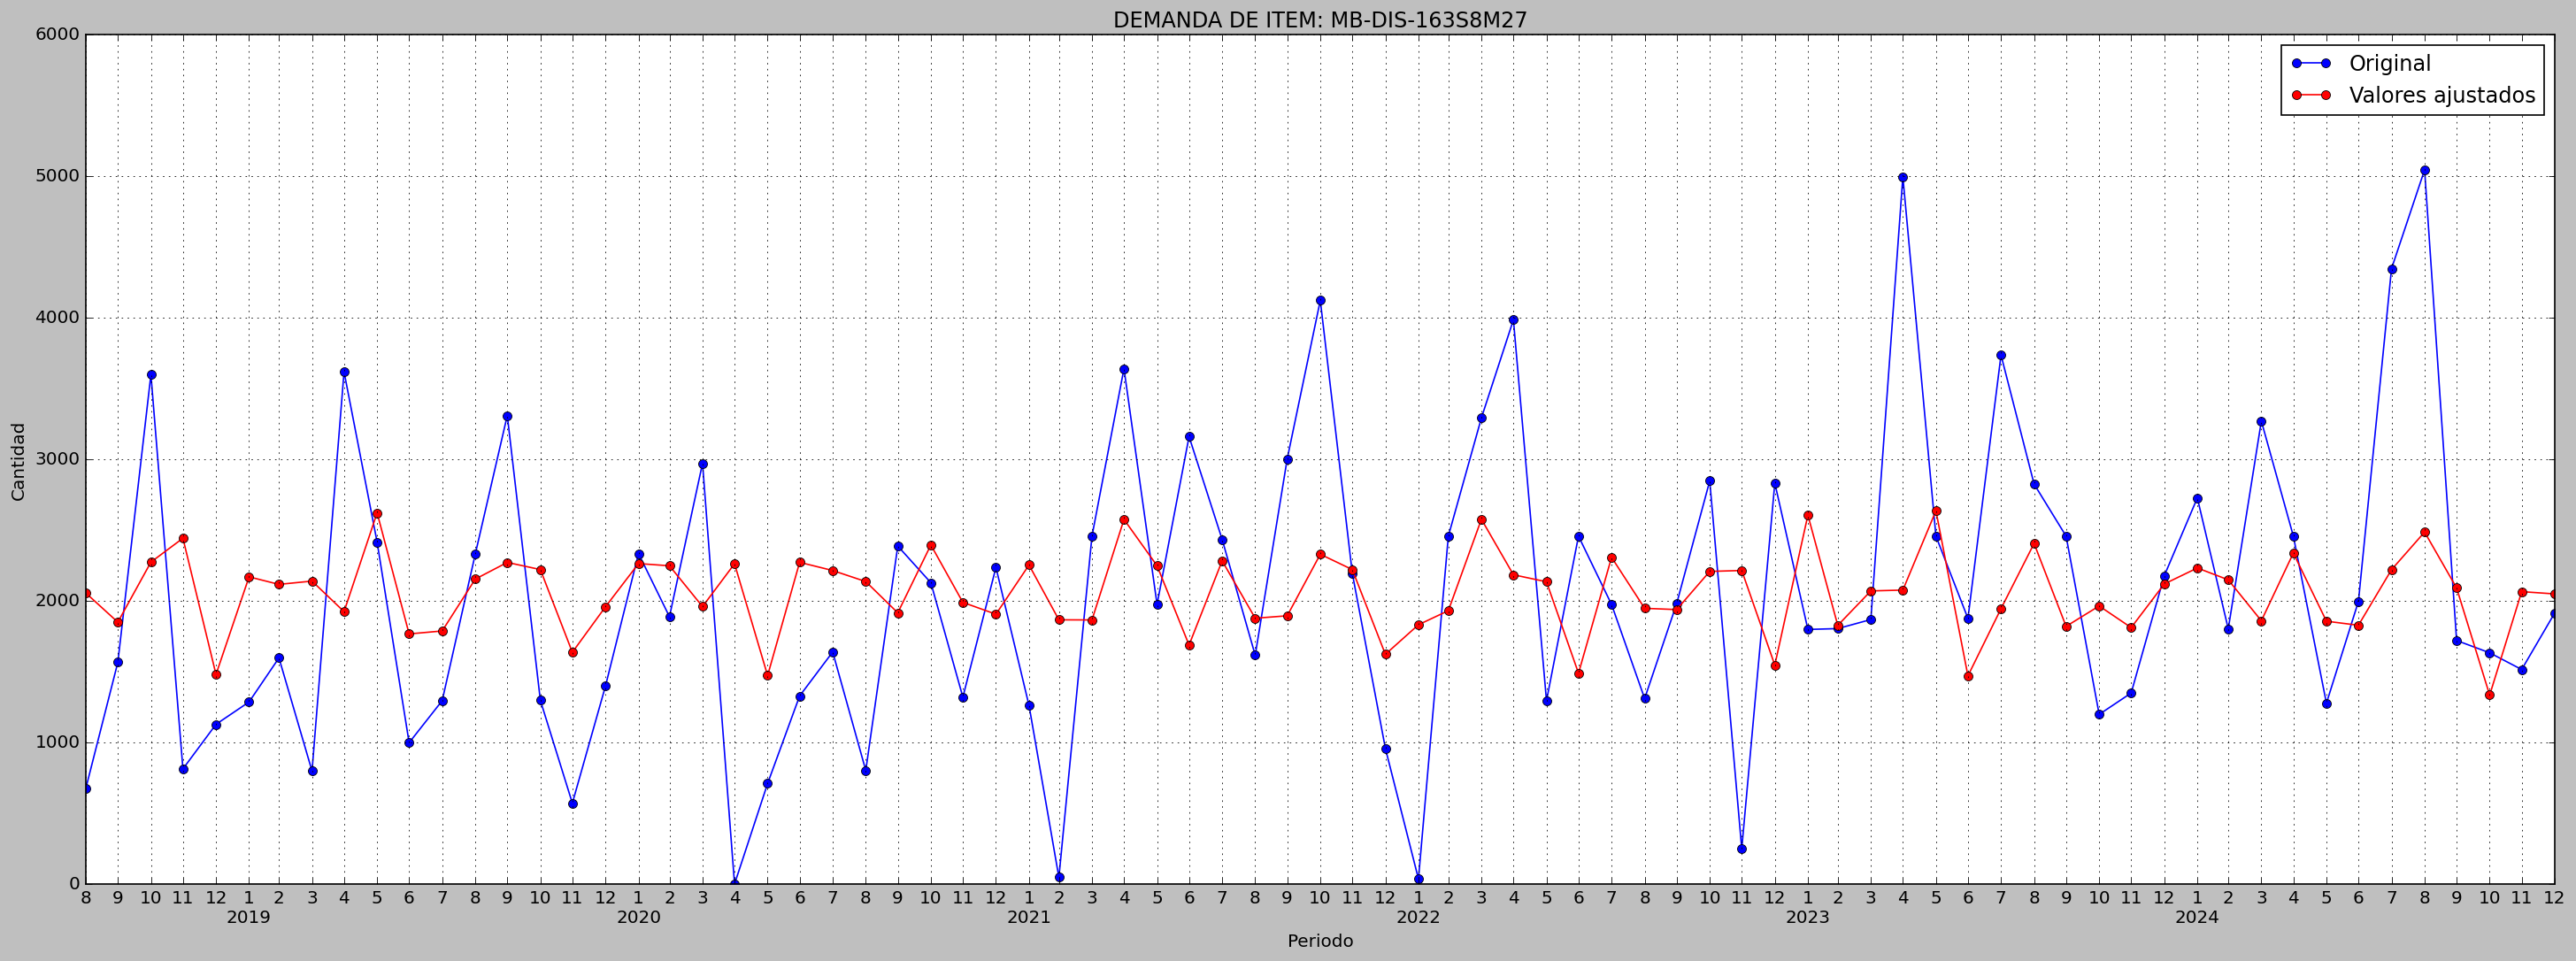

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Original", color="blue", marker="o")
plt.plot(x, model2_fit.fittedvalues, label='Valores ajustados', color='red',marker="o")
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

### 4.3 Modelo 3

In [ ]:
# ARIMA model3

from statsmodels.tsa.arima.model import ARIMA

model3 = ARIMA(y,
               order=(9,0, 1))

model3_fit = model3.fit()

print(model3_fit.summary())

# Ho: X=0
# H1: X!=0
# Si p-value < 0.05, se rechaza H0 , lo que indica que el coeficiente es significativo.
# Si p-value > 0.05, no se rechaza H0, lo que indica que el coeficiente no es significativo.

                               SARIMAX Results                                
Dep. Variable:         Total Cantidad   No. Observations:                   77
Model:                 ARIMA(9, 0, 1)   Log Likelihood                -638.631
Date:                Fri, 16 May 2025   AIC                           1301.263
Time:                        11:40:20   BIC                           1329.388
Sample:                             0   HQIC                          1312.513
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2055.2937    164.092     12.525      0.000    1733.679    2376.908
ar.L1         -0.6026      0.323     -1.865      0.062      -1.236       0.031
ar.L2         -0.0255      0.195     -0.130      0.8

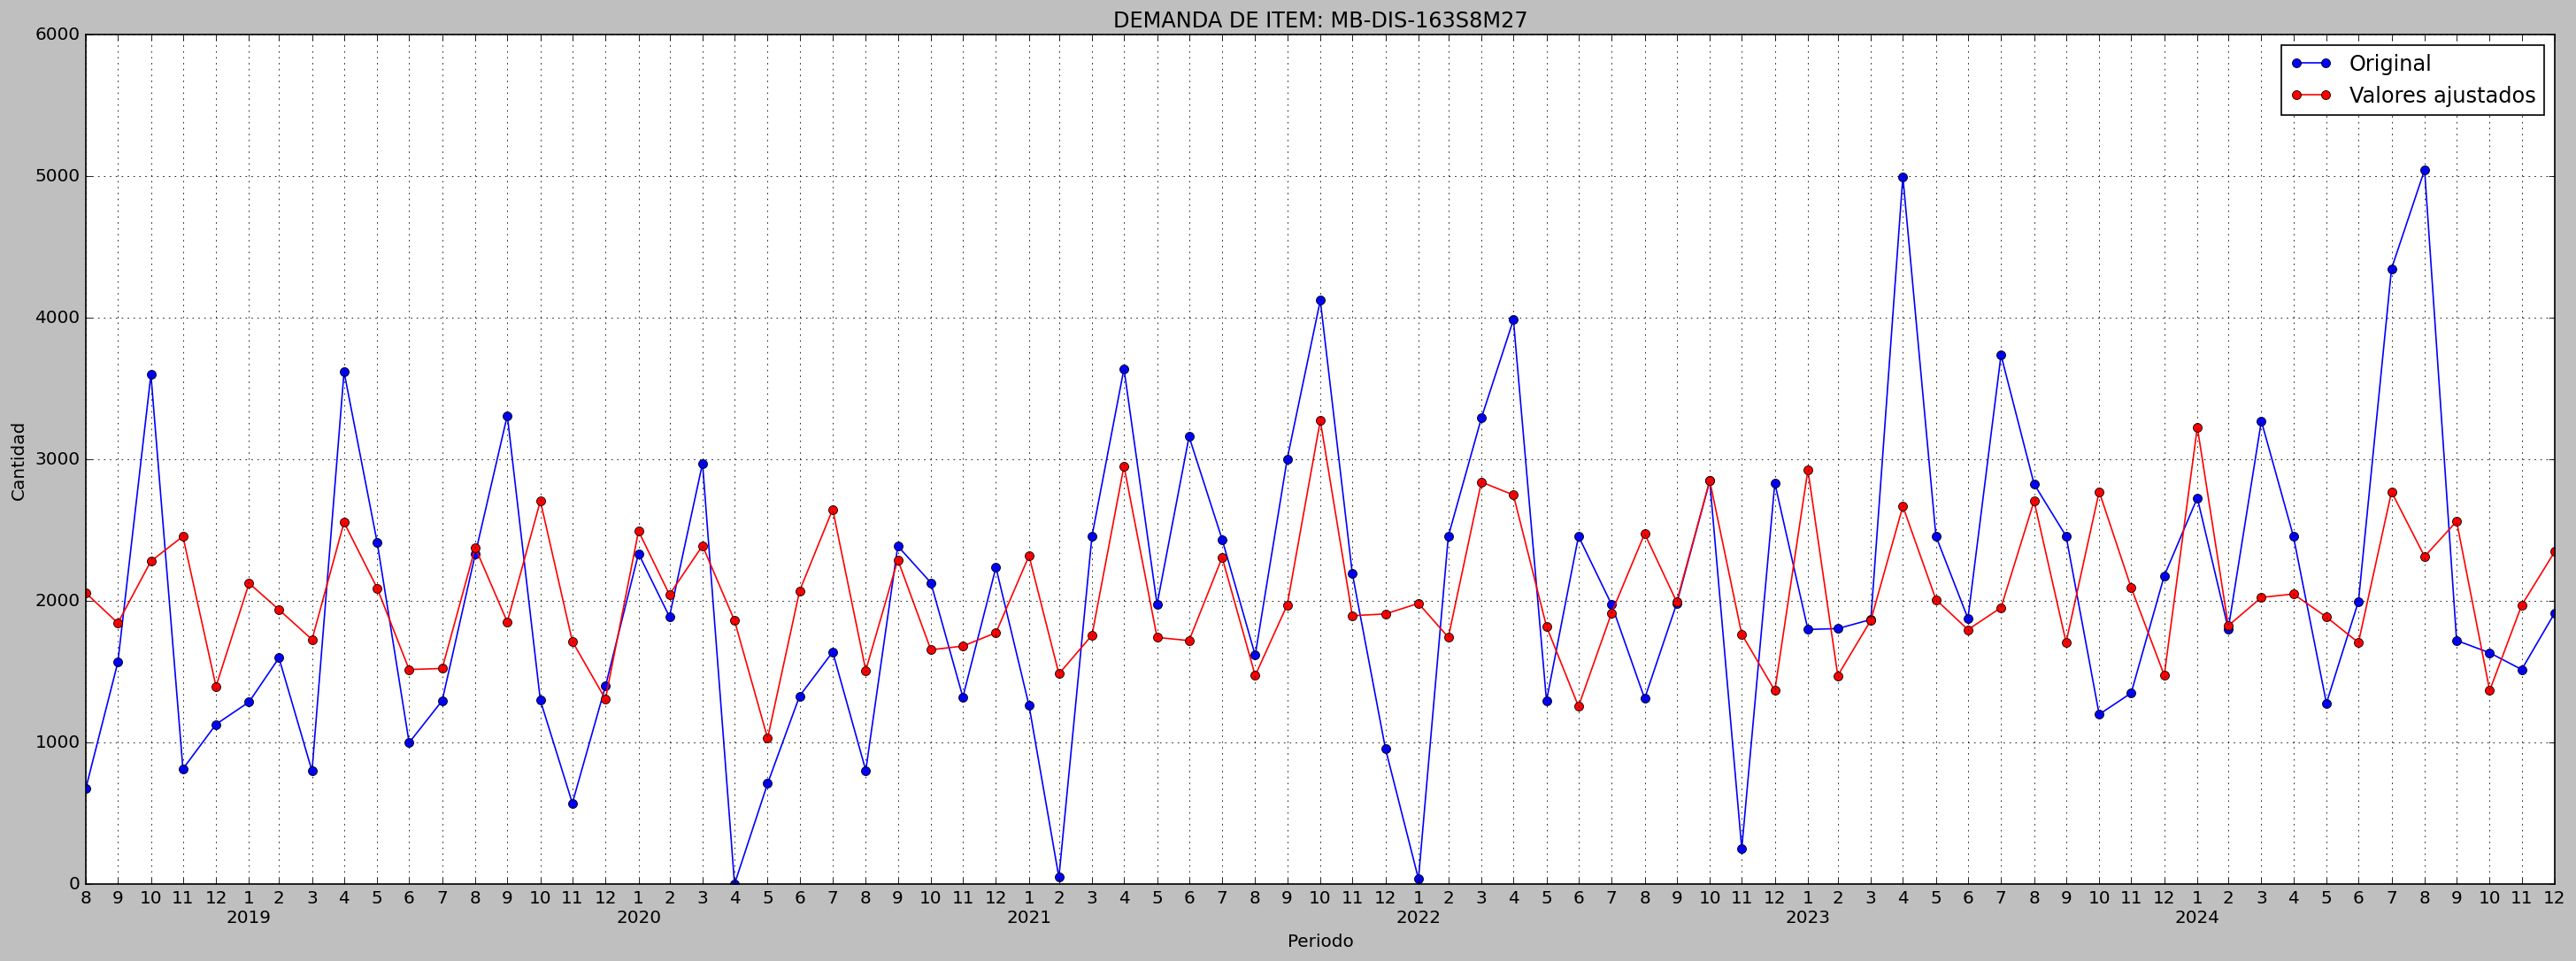

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Original", color="blue", marker="o")
plt.plot(x, model3_fit.fittedvalues, label='Valores ajustados', color='red',marker="o")
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

In [ ]:
# ARIMA model4

import pmdarima as pm

# AUTOARIMA
model4=pm.auto_arima(
    y, 
    star_p=0,      # initial p value to test
    stat_q=0,      # initial q value to test
    test='adf',    # use adftest to find optimal 'd'
    max_p=10,       # maximum p value
    max_q=10,       # maximum q value       
    d=None,        # let model determine 'd'
    seasonal=False,# False for non-seasonal data 
    star_P=0,      # initial seasonal P value to test   
    D=0,           # seasonal difference order (default = 0)
    trace=True,    # show trace output
    error_action='warn', # don't want to know if an order does not work
    suppress_warnings=False, # warnings are ignored     
    stepwise=True
) # stepwise model selection

print(model4.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1306.279, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1414.127, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1332.658, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1372.209, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1305.023, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1355.793, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1305.062, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1303.964, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1355.042, Time=0.05 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1308.472, Time=0.10 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1302.784, Time=0.10 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1342.686, Time=0.05 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=1299.716, Time=0.13 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=1302.869, Time=0.15 sec
 ARIMA(2,0,5)(0,0,0)[0]          

In [ ]:
# ARIMA model4

from statsmodels.tsa.arima.model import ARIMA

model4 = ARIMA(y,
               order=(2, 0, 0))

model4_fit = model4.fit()

print(model4_fit.summary())

# Ho: X=0
# H1: X!=0
# Si p-value < 0.05, se rechaza H0 , lo que indica que el coeficiente es significativo.
# Si p-value > 0.05, no se rechaza H0, lo que indica que el coeficiente no es significativo.

                               SARIMAX Results                                
Dep. Variable:         Total Cantidad   No. Observations:                   77
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -644.470
Date:                Fri, 16 May 2025   AIC                           1296.941
Time:                        11:40:23   BIC                           1306.316
Sample:                             0   HQIC                          1300.691
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2055.2916    122.132     16.828      0.000    1815.917    2294.667
ar.L1          0.1827      0.117      1.566      0.117      -0.046       0.411
ar.L2         -0.2229      0.152     -1.471      0.1

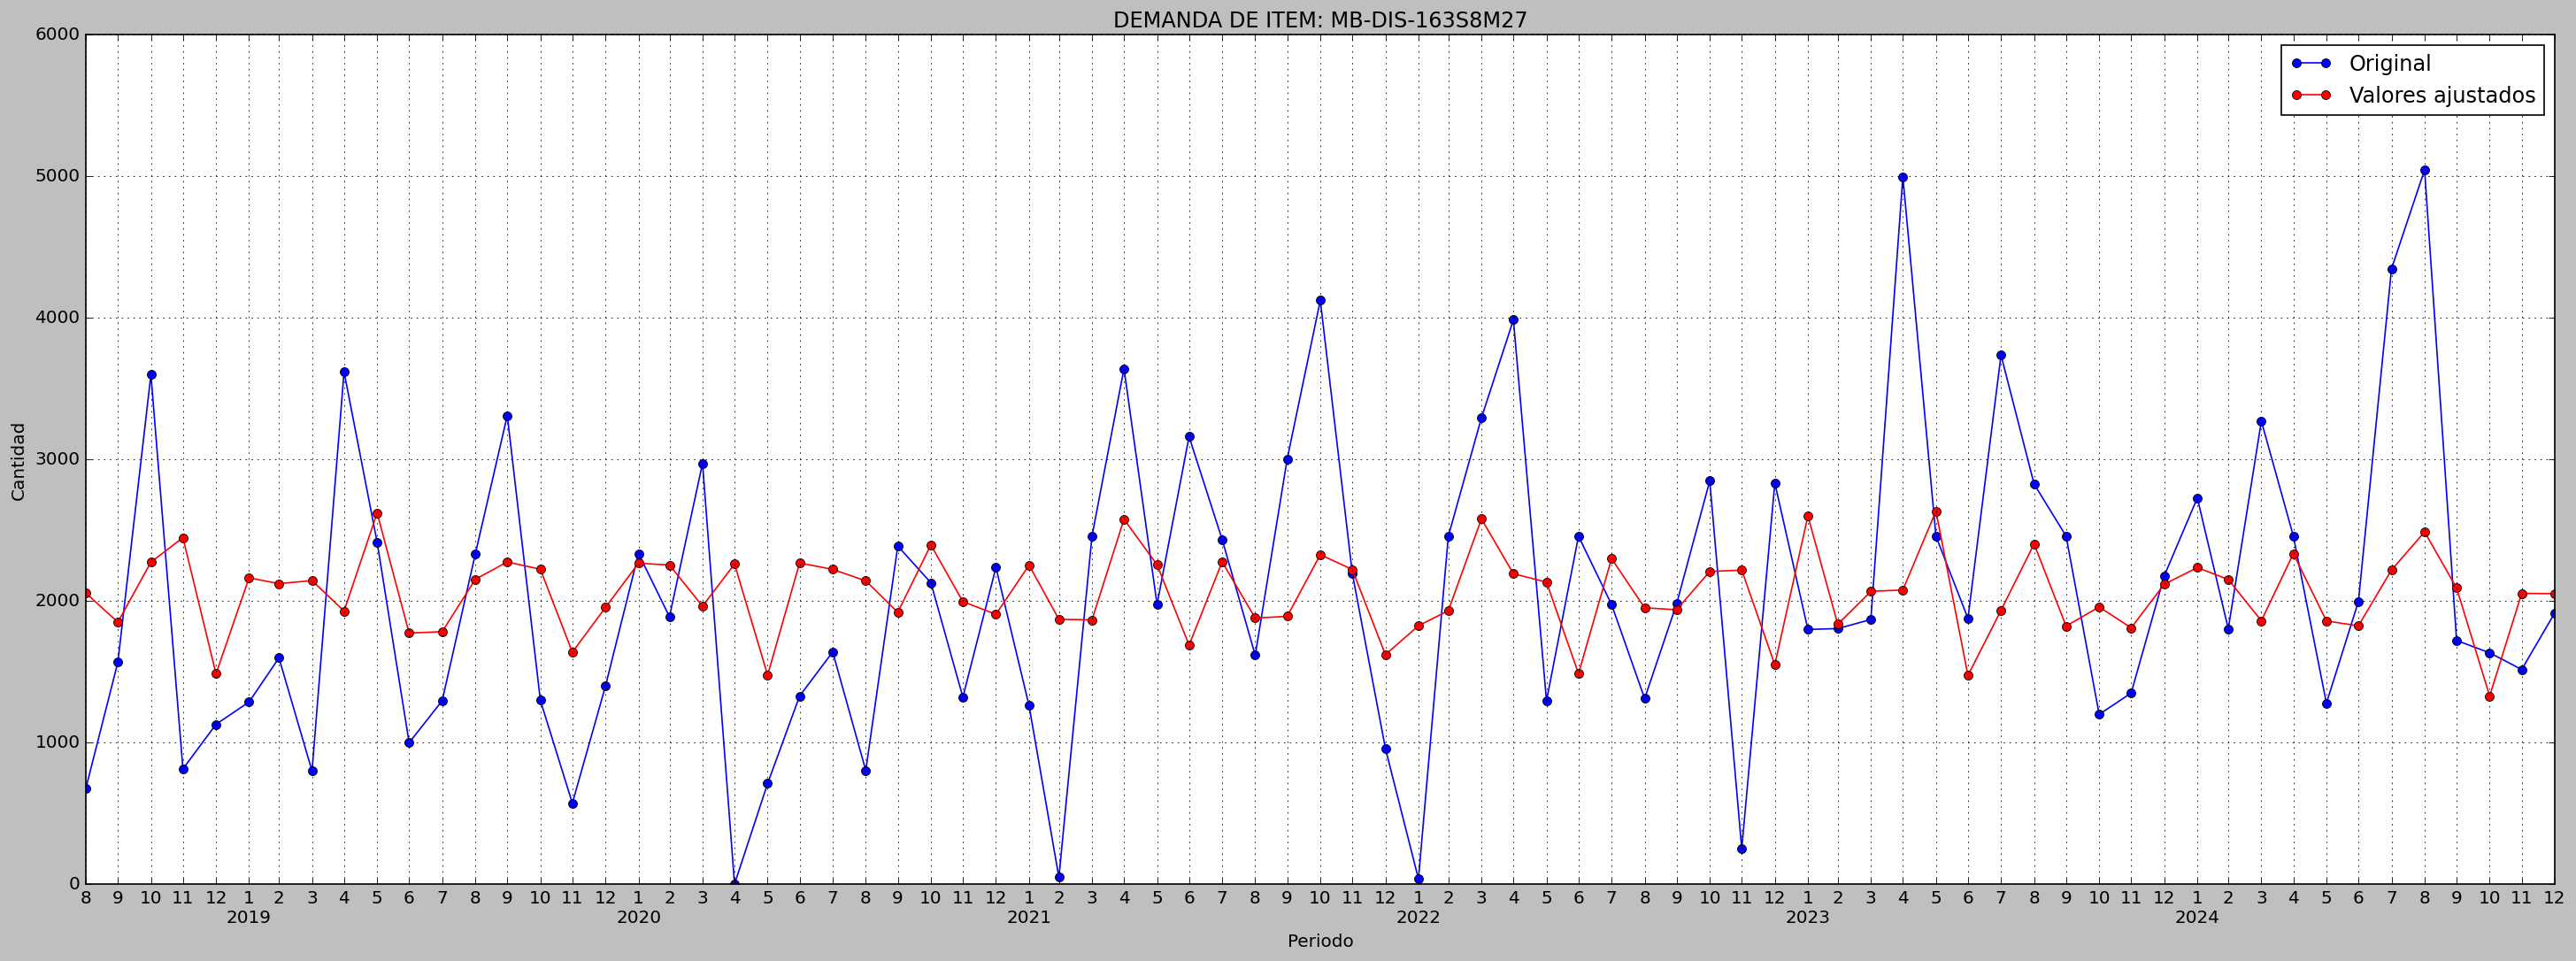

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(x, y, label="Original", color="blue", marker="o")
plt.plot(x, model4_fit.fittedvalues, label='Valores ajustados', color='red',marker="o")
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=x.max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

In [ ]:
# COMPARACION DE LOS AIKAKE INFO CRITERION (AIC) DE LOS 4 MODELOS ESTIMADOS
print(f"AIC del Modelo 1: {model1_fit.aic}")
print(f"AIC del Modelo 2: {model2_fit.aic}")
print(f"AIC del Modelo 3: {model3_fit.aic}")
print(f"AIC del Modelo 4: {model4_fit.aic}\n")

# CALCULO DEL ERROR CUADRATICO MEDIO (RMSE) DE LOS 4 MODELOS ESTIMADOS
from sklearn.metrics import mean_squared_error
from math import sqrt
# Calcular el RMSE para cada modelo
mse_model1 = mean_squared_error(y, model1_fit.fittedvalues)
mse_model2 = mean_squared_error(y, model2_fit.fittedvalues)
mse_model3 = mean_squared_error(y, model3_fit.fittedvalues)
mse_model4 = mean_squared_error(y, model4_fit.fittedvalues)
print(f"MSE del Modelo 1: {mse_model1}")
print(f"MSE del Modelo 2: {mse_model2}")
print(f"MSE del Modelo 3: {mse_model3}")
print(f"MSE del Modelo 4: {mse_model4}\n")

# Imprime el mejor modelo segun el AIC
if model1_fit.aic < model2_fit.aic and model1_fit.aic < model3_fit.aic and model1_fit.aic < model4_fit.aic:
    print("El mejor modelo segun el AIC es el Modelo 1")
elif model2_fit.aic < model1_fit.aic and model2_fit.aic < model3_fit.aic and model2_fit.aic < model4_fit.aic:
    print("El mejor modelo segun el AIC es el Modelo 2")
elif model3_fit.aic < model1_fit.aic and model3_fit.aic < model2_fit.aic and model3_fit.aic < model4_fit.aic:
    print("El mejor modelo segun el AIC es el Modelo 3")
else:
    print("El mejor modelo segun el AIC es el Modelo 4")

# Imprimir el mejor modelo segun el MSE
if mse_model1 < mse_model2 and mse_model1 < mse_model3 and mse_model1 < mse_model4:
    print("El mejor modelo segun el MSE es el Modelo 1")
elif mse_model2 < mse_model1 and mse_model2 < mse_model3 and mse_model2 < mse_model4:
    print("El mejor modelo segun el MSE es el Modelo 2")
elif mse_model3 < mse_model1 and mse_model3 < mse_model2 and mse_model3 < mse_model4:
    print("El mejor modelo segun el MSE es el Modelo 3")
else:
    print("El mejor modelo segun el MSE es el Modelo 4")

AIC del Modelo 1: 1299.1139965614964
AIC del Modelo 2: 1298.9606953293057
AIC del Modelo 3: 1301.2628185435333
AIC del Modelo 4: 1296.9409203553448

MSE del Modelo 1: 1121343.779693675
MSE del Modelo 2: 1089922.2926043826
MSE del Modelo 3: 937860.6678981314
MSE del Modelo 4: 1089954.351481962

El mejor modelo segun el AIC es el Modelo 4
El mejor modelo segun el MSE es el Modelo 3


## 5. EVALUACION DEL MODELO

### 5.2 Evaluacion del modelo 1

In [ ]:
# TEST DE RUDIO BLANCO DE LOS RESIDUOS

import statsmodels.api as sm

sm.stats.acorr_ljungbox(model1_fit.resid, 
                        lags=[1], 
                        return_df=True)
# Ho: No hay autocorrelación en los residuos. RUIDO BLANCO
# H1: Hay autocorrelación en los residuos. NO RUIDO BLANCO
# Si el p-value es menor que 0.05, se rechaza la hipótesis nula de no autocorrelación. RUIDO BLANCO  
# Si el p-value es mayor que 0.05, no se rechaza la hipótesis nula de no autocorrelación. NO RUIDO BLANCO

print(sm.stats.acorr_ljungbox(model1_fit.resid, 
                        lags=[1], 
                        return_df=True))

if sm.stats.acorr_ljungbox(model1_fit.resid, lags=[1], return_df=True).iloc[0, 1] < 0.05:
    print("Se rechaza la hipótesis nula de no autocorrelación (No  es ruido blanco).")
else:
    print("No se rechaza la hipótesis nula de no autocorrelación (Es ruido blanco).")

    lb_stat  lb_pvalue
1  0.039729   0.842012
No se rechaza la hipótesis nula de no autocorrelación (Es ruido blanco).


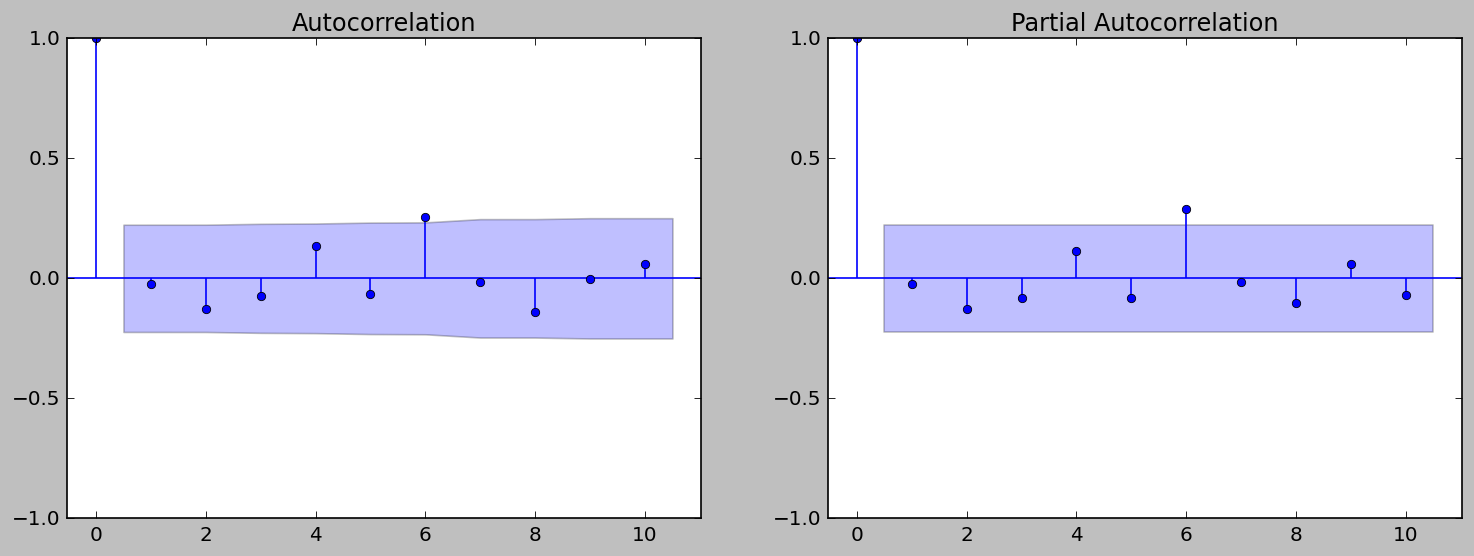

In [ ]:
# DIAGNOSTICO DE LOS RESIDUOS

plt.rcParams.update({'figure.figsize': (15, 5), 
                     'figure.dpi': 120})
fig, axes = plt.subplots(1, 
                         2, 
                         sharex=False)

plot_acf(model1_fit.resid, lags=10, ax=axes[0])
plot_pacf(model1_fit.resid, lags=10, ax=axes[1])

plt.show()
plt.close()

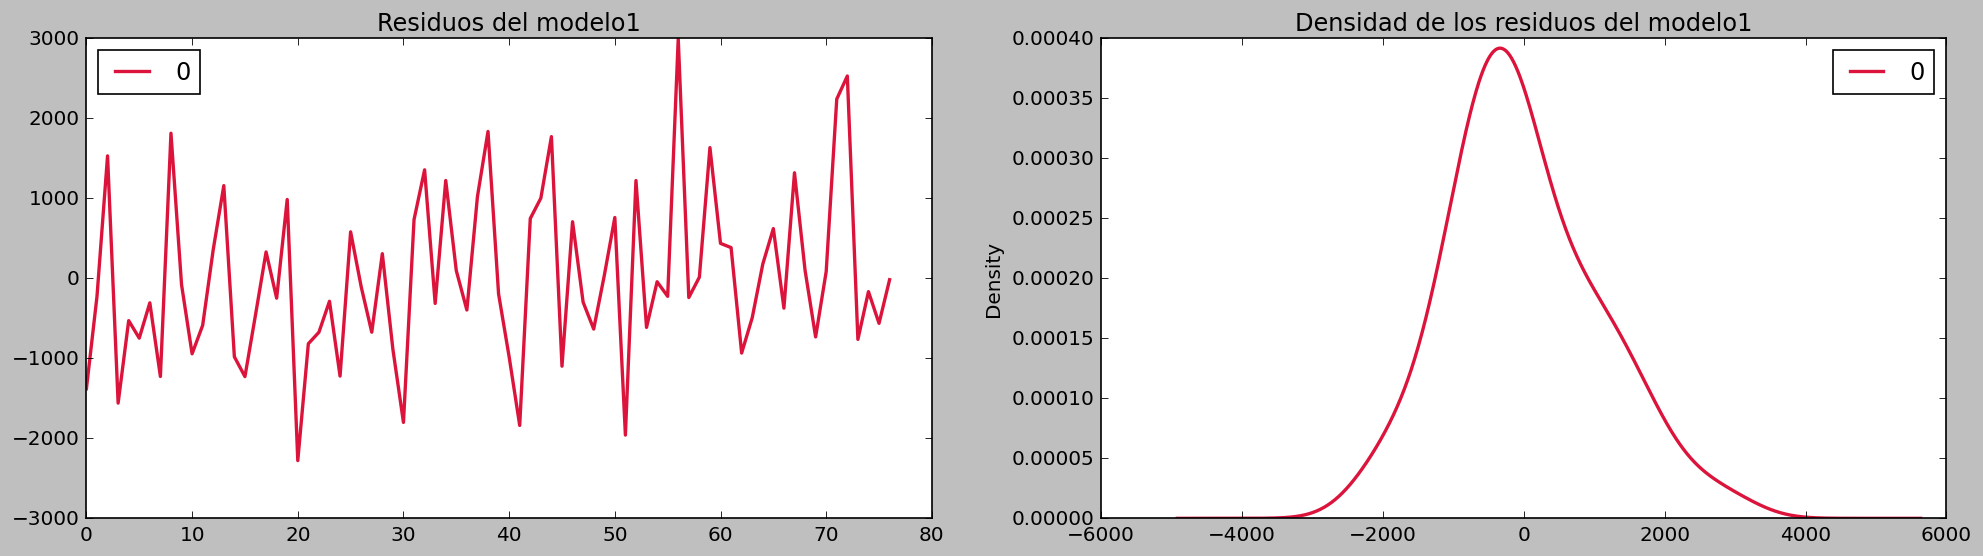

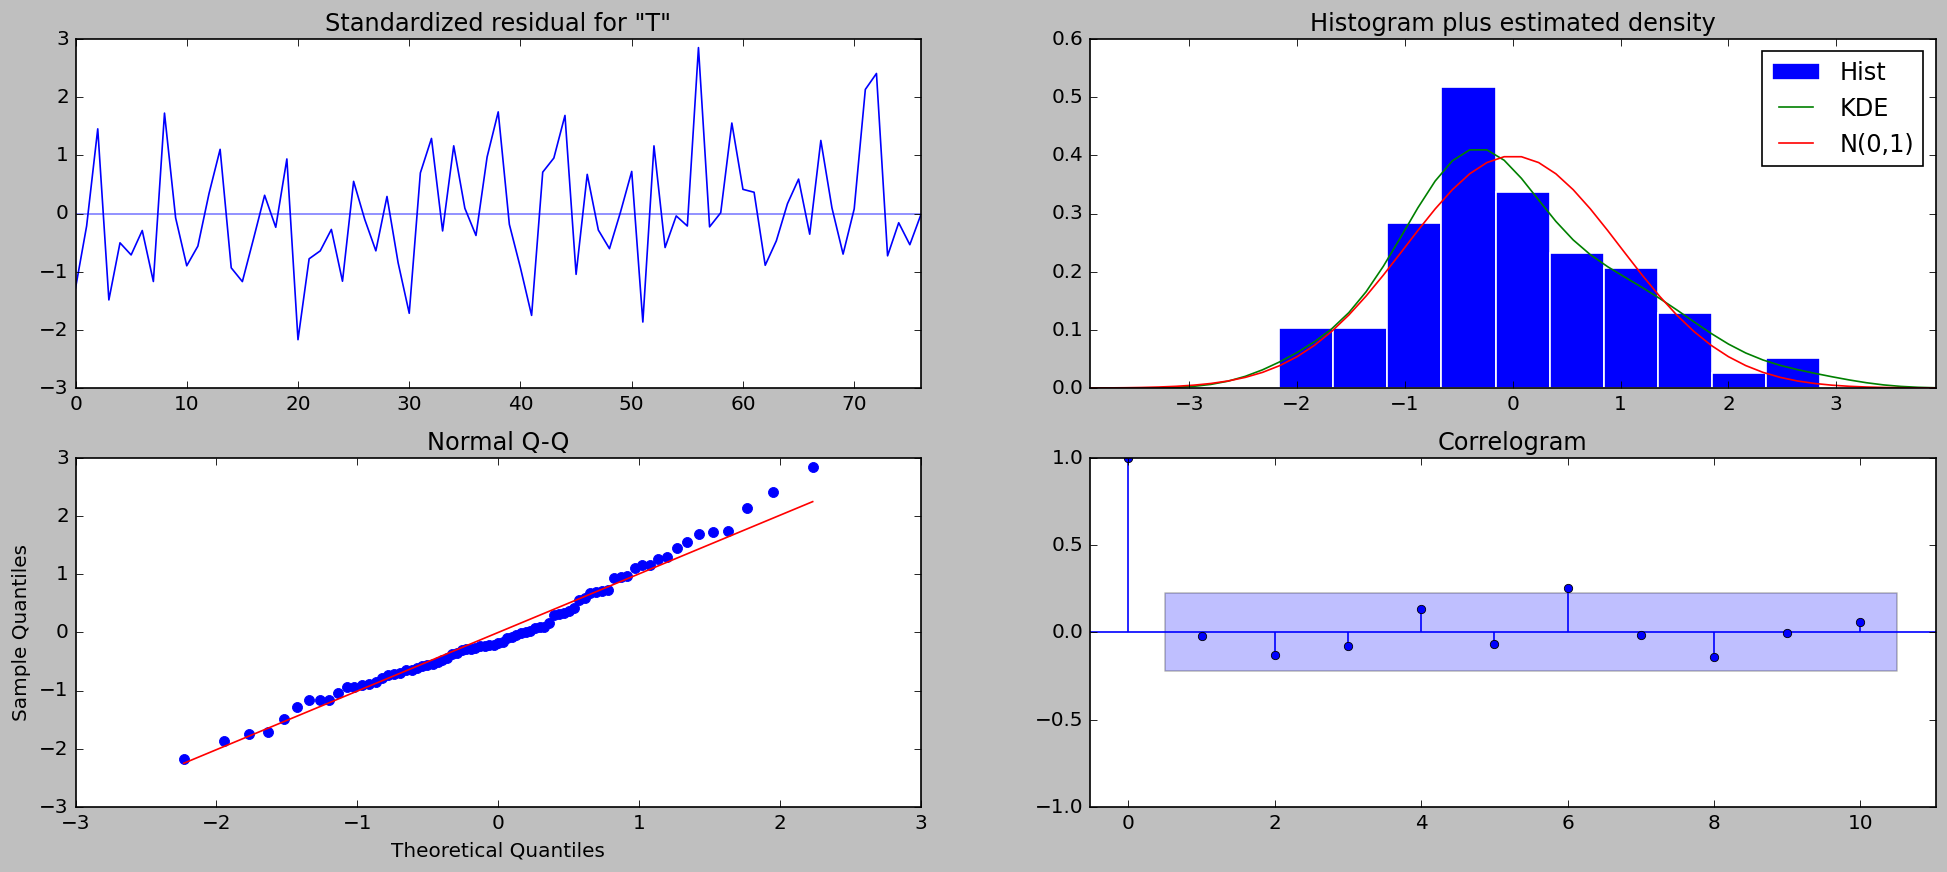

In [ ]:
#PLOT DE RESIDUOS DEL MODELO1

plt.rcParams.update({'figure.figsize': (20, 5),
                     'figure.dpi': 120})

residuals=pd.DataFrame(model1_fit.resid)
fig,ax=plt.subplots(1,2,figsize=(20,5))
residuals.plot(title= "Residuos del modelo1",ax=ax[0],color="crimson", lw=2)
residuals.plot(kind="kde",title= "Densidad de los residuos del modelo1",ax=ax[1],color="crimson", lw=2)
plt.show()

model1_fit.plot_diagnostics(figsize=(20, 8))
plt.show()
#los errores residuales parecen estar bien con una media igual a 0 y una varianza constante.

### 5.2 Evaluacion del modelo 2

In [ ]:
# TEST DE RUDIO BLANCO DE LOS RESIDUOS

import statsmodels.api as sm

sm.stats.acorr_ljungbox(model2_fit.resid, 
                        lags=[1], 
                        return_df=True)
# Ho: No hay autocorrelación en los residuos. RUIDO BLANCO
# H1: Hay autocorrelación en los residuos. NO RUIDO BLANCO
# Si el p-value es menor que 0.05, se rechaza la hipótesis nula de no autocorrelación. RUIDO BLANCO  
# Si el p-value es mayor que 0.05, no se rechaza la hipótesis nula de no autocorrelación. NO RUIDO BLANCO

print(sm.stats.acorr_ljungbox(model2_fit.resid, 
                        lags=[1], 
                        return_df=True))

if sm.stats.acorr_ljungbox(model2_fit.resid, lags=[1], return_df=True).iloc[0, 1] < 0.05:
    print("Se rechaza la hipótesis nula de no autocorrelación (No es ruido blanco).")
else:
    print("No se rechaza la hipótesis nula de no autocorrelación (Es ruido blanco).")

    lb_stat  lb_pvalue
1  0.000028   0.995803
No se rechaza la hipótesis nula de no autocorrelación (Es ruido blanco).


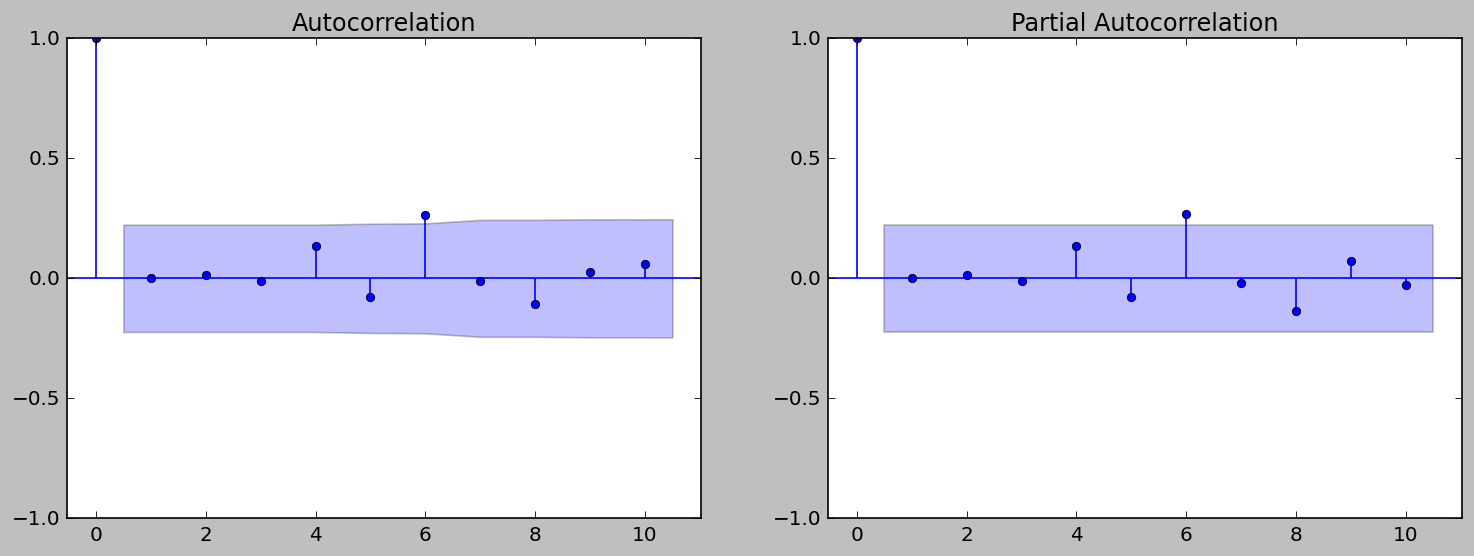

In [ ]:
# DIAGNOSTICO DE LOS RESIDUOS

plt.rcParams.update({'figure.figsize': (15, 5), 
                     'figure.dpi': 120})
fig, axes = plt.subplots(1, 
                         2, 
                         sharex=False)

plot_acf(model2_fit.resid, lags=10, ax=axes[0])
plot_pacf(model2_fit.resid, lags=10, ax=axes[1])

plt.show()
plt.close()

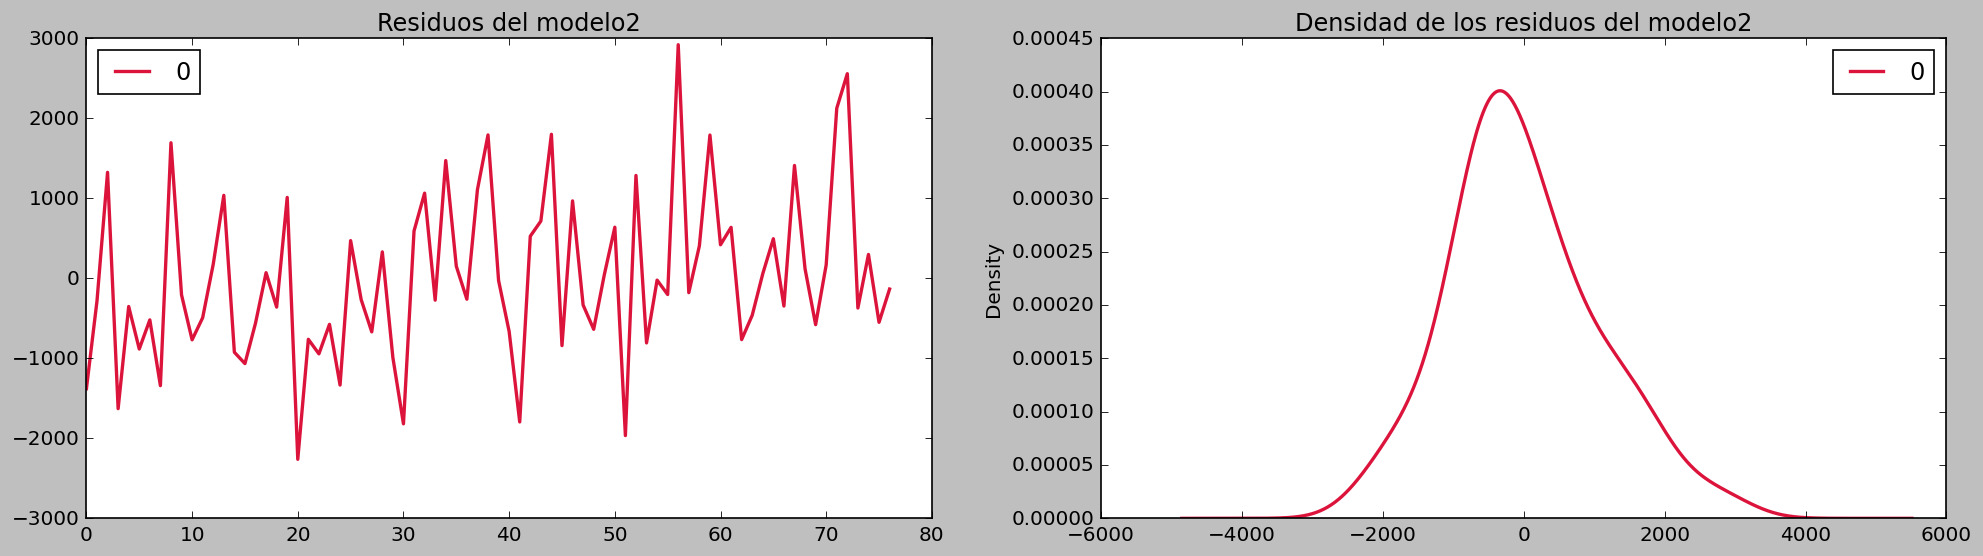

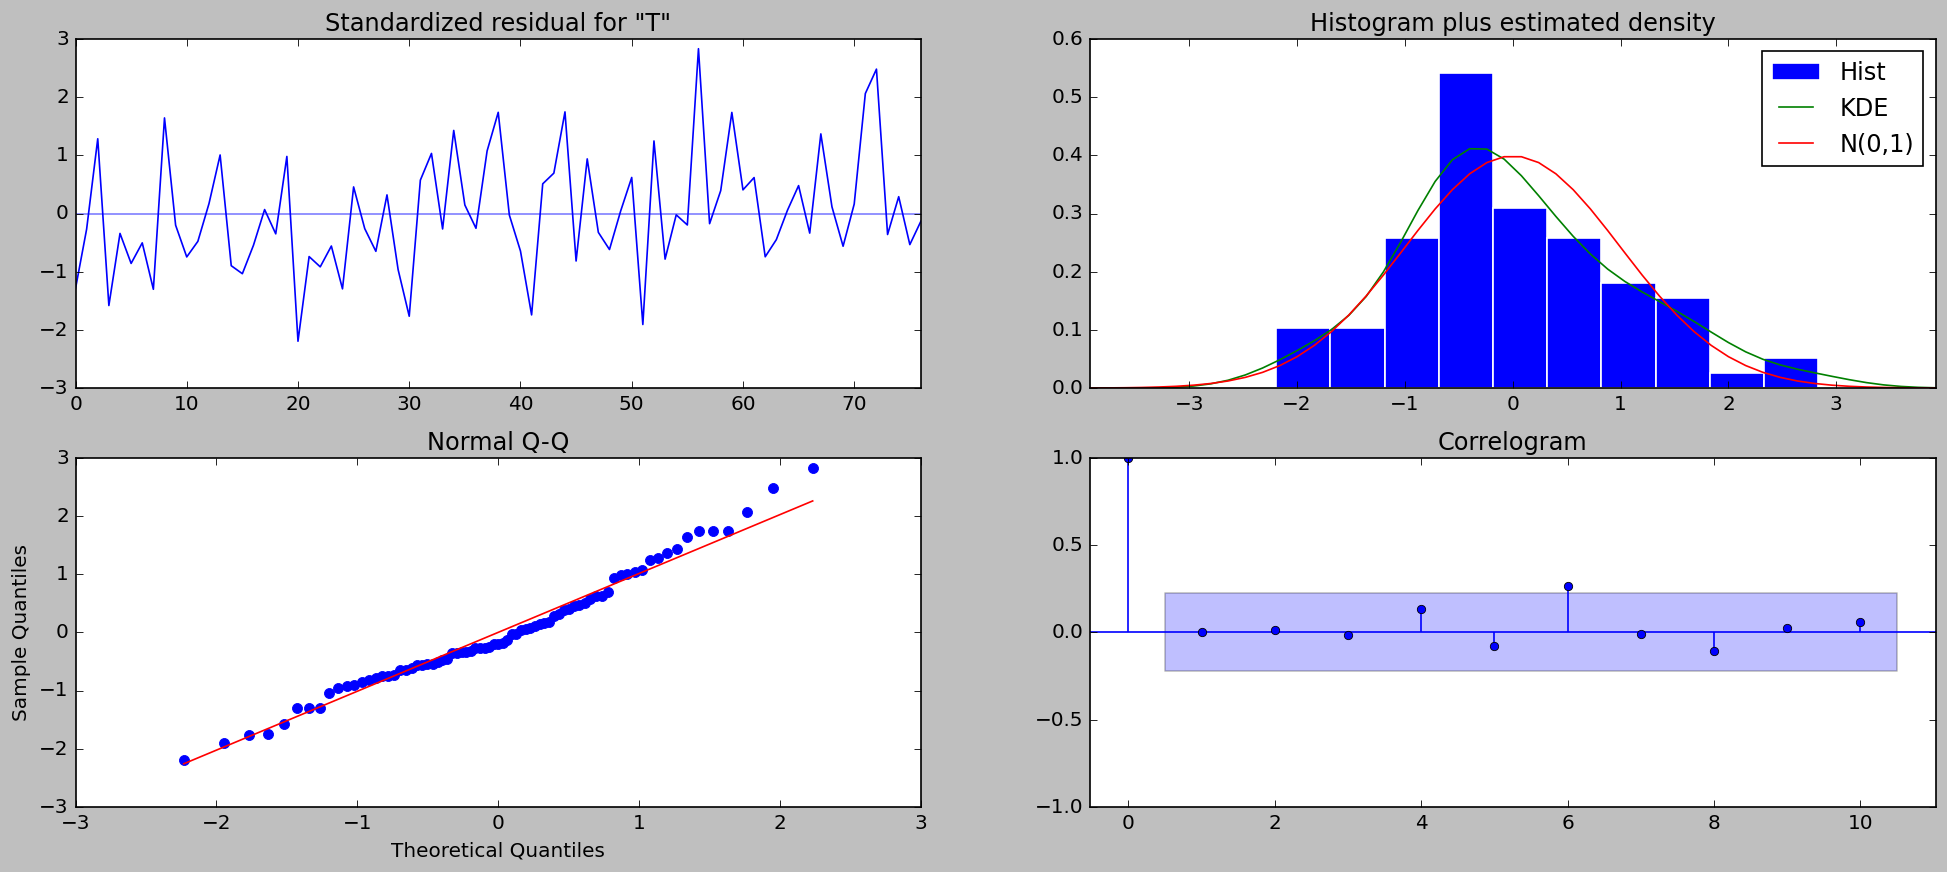

In [ ]:
#PLOT DE RESIDUOS DEL MODELO2

plt.rcParams.update({'figure.figsize': (20, 5),
                     'figure.dpi': 120})

residuals=pd.DataFrame(model2_fit.resid)
fig,ax=plt.subplots(1,2,figsize=(20,5))
residuals.plot(title= "Residuos del modelo2",ax=ax[0],color="crimson", lw=2)
residuals.plot(kind="kde",title= "Densidad de los residuos del modelo2",ax=ax[1],color="crimson", lw=2)
plt.show()

model2_fit.plot_diagnostics(figsize=(20, 8))
plt.show()
#los errores residuales parecen estar bien con una media igual a 0 y una varianza constante.

### 3.3 Evaluacion del modelo 3

In [ ]:
# TEST DE RUDIO BLANCO DE LOS RESIDUOS

import statsmodels.api as sm

sm.stats.acorr_ljungbox(model3_fit.resid, 
                        lags=[1], 
                        return_df=True)
# Ho: No hay autocorrelación en los residuos. RUIDO BLANCO
# H1: Hay autocorrelación en los residuos. NO RUIDO BLANCO
# Si el p-value es menor que 0.05, se rechaza la hipótesis nula de no autocorrelación. RUIDO BLANCO  
# Si el p-value es mayor que 0.05, no se rechaza la hipótesis nula de no autocorrelación. NO RUIDO BLANCO

print(sm.stats.acorr_ljungbox(model3_fit.resid, 
                        lags=[1], 
                        return_df=True))

if sm.stats.acorr_ljungbox(model3_fit.resid, lags=[1], return_df=True).iloc[0, 1] < 0.05:
    print("Se rechaza la hipótesis nula de no autocorrelación (No es ruido blanco).")
else:
    print("No se rechaza la hipótesis nula de no autocorrelación (Es ruido blanco).")

    lb_stat  lb_pvalue
1  0.001892   0.965306
No se rechaza la hipótesis nula de no autocorrelación (Es ruido blanco).


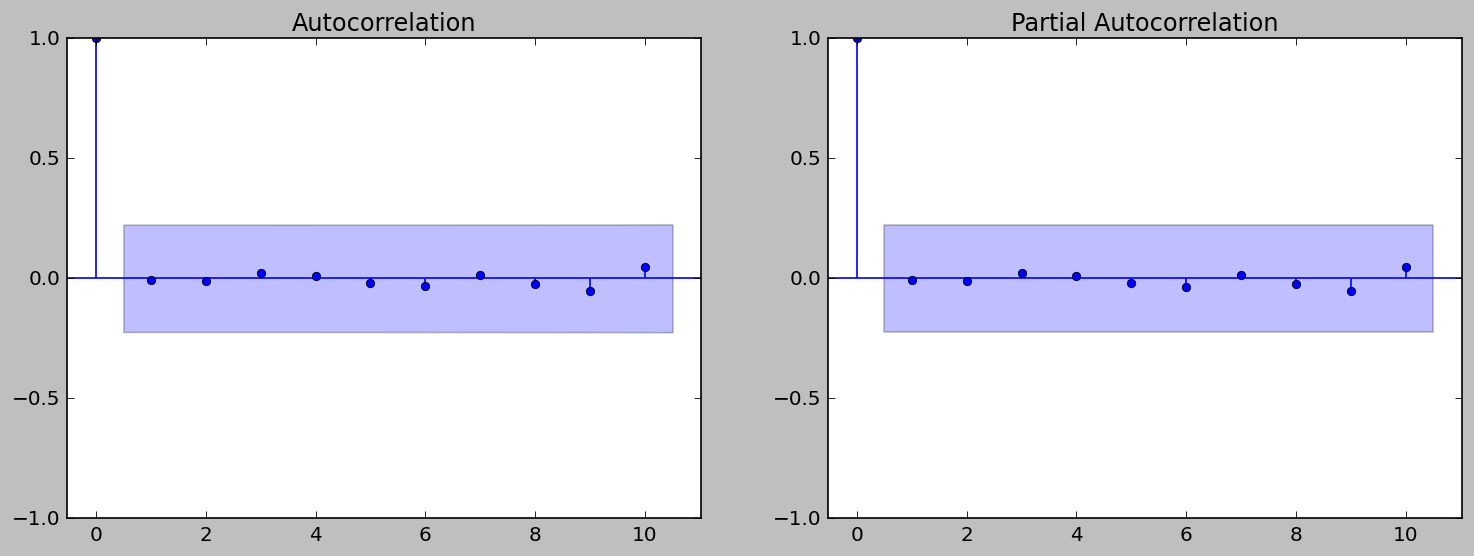

In [ ]:
# DIAGNOSTICO DE LOS RESIDUOS

plt.rcParams.update({'figure.figsize': (15, 5), 
                     'figure.dpi': 120})
fig, axes = plt.subplots(1, 
                         2, 
                         sharex=False)

plot_acf(model3_fit.resid, lags=10, ax=axes[0])
plot_pacf(model3_fit.resid, lags=10, ax=axes[1])

plt.show()
plt.close()

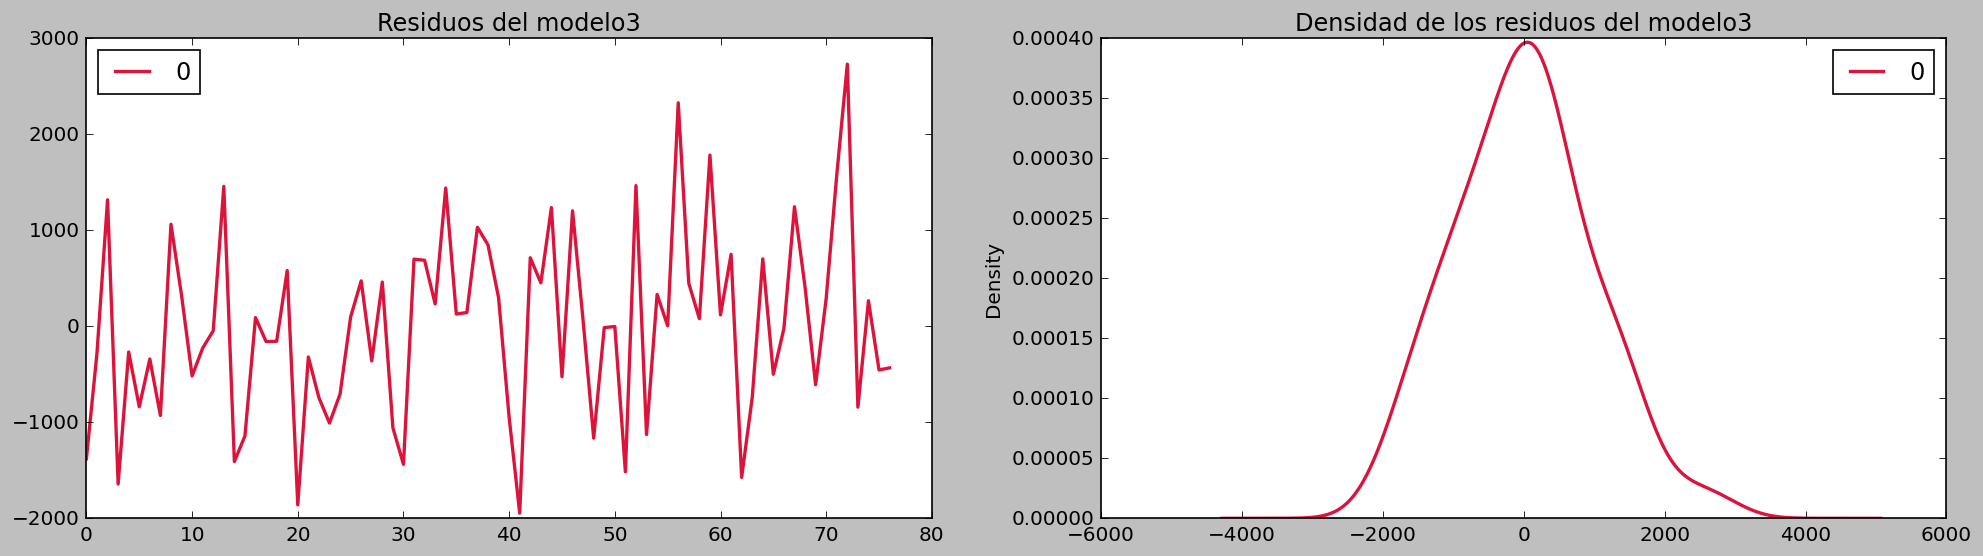

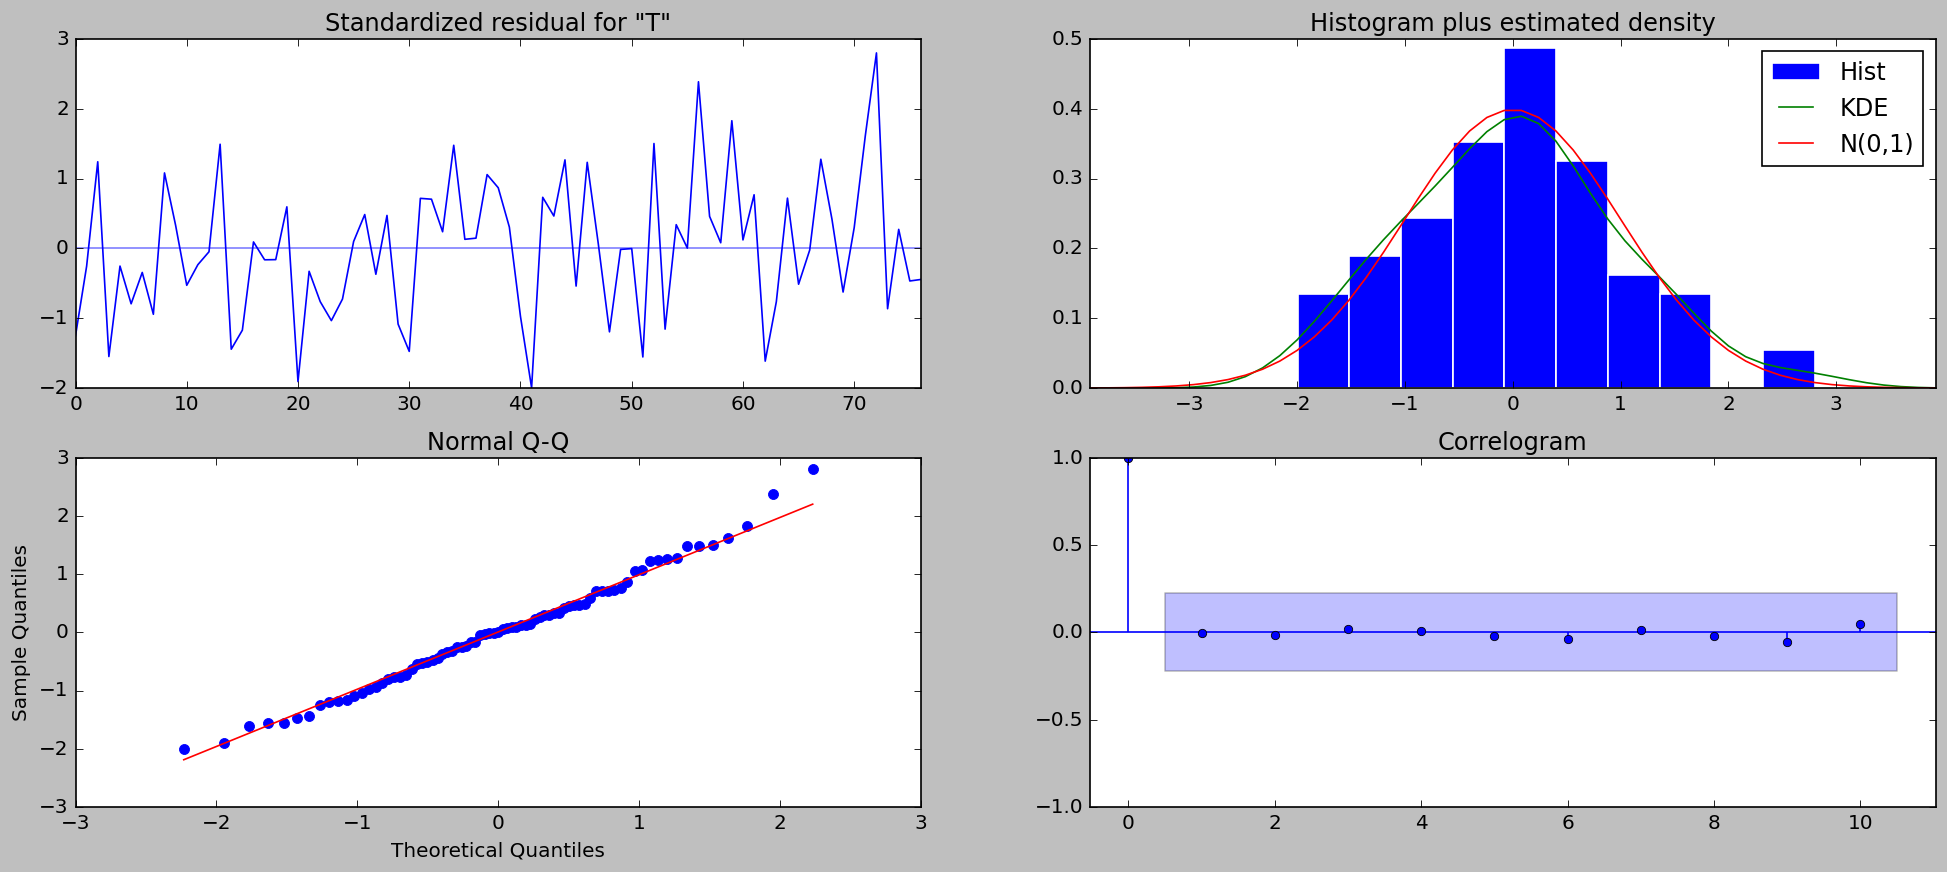

In [ ]:
#PLOT DE RESIDUOS DEL MODELO2

plt.rcParams.update({'figure.figsize': (20, 5),
                     'figure.dpi': 120})

residuals=pd.DataFrame(model3_fit.resid)
fig,ax=plt.subplots(1,2,figsize=(20,5))
residuals.plot(title= "Residuos del modelo3",ax=ax[0],color="crimson", lw=2)
residuals.plot(kind="kde",title= "Densidad de los residuos del modelo3",ax=ax[1],color="crimson", lw=2)
plt.show()

model3_fit.plot_diagnostics(figsize=(20, 8))
plt.show()
#los errores residuales parecen estar bien con una media igual a 0 y una varianza constante.

### 5.4 Evaluacion del modelo 4

In [ ]:
# TEST DE RUDIO BLANCO DE LOS RESIDUOS

import statsmodels.api as sm

sm.stats.acorr_ljungbox(model4_fit.resid, 
                        lags=[1], 
                        return_df=True)
# Ho: No hay autocorrelación en los residuos. RUIDO BLANCO
# H1: Hay autocorrelación en los residuos. NO RUIDO BLANCO
# Si el p-value es menor que 0.05, se rechaza la hipótesis nula de no autocorrelación. RUIDO BLANCO  
# Si el p-value es mayor que 0.05, no se rechaza la hipótesis nula de no autocorrelación. NO RUIDO BLANCO

print(sm.stats.acorr_ljungbox(model4_fit.resid, 
                        lags=[1], 
                        return_df=True))

if sm.stats.acorr_ljungbox(model4_fit.resid, lags=[1], return_df=True).iloc[0, 1] < 0.05:
    print("Se rechaza la hipótesis nula de no autocorrelación (No es ruido blanco).")
else:
    print("No se rechaza la hipótesis nula de no autocorrelación (Es ruido blanco).")

    lb_stat  lb_pvalue
1  0.000259   0.987159
No se rechaza la hipótesis nula de no autocorrelación (Es ruido blanco).


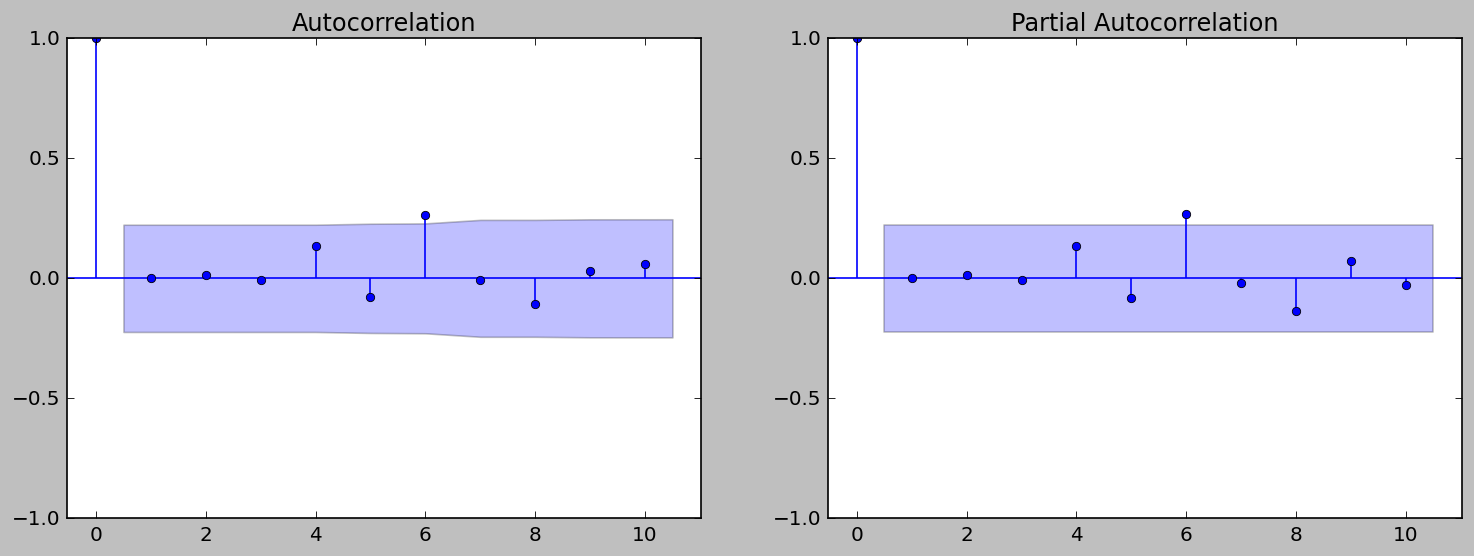

In [ ]:
# DIAGNOSTICO DE LOS RESIDUOS

plt.rcParams.update({'figure.figsize': (15, 5), 
                     'figure.dpi': 120})
fig, axes = plt.subplots(1, 
                         2, 
                         sharex=False)

plot_acf(model4_fit.resid, lags=10, ax=axes[0])
plot_pacf(model4_fit.resid, lags=10, ax=axes[1])

plt.show()
plt.close()

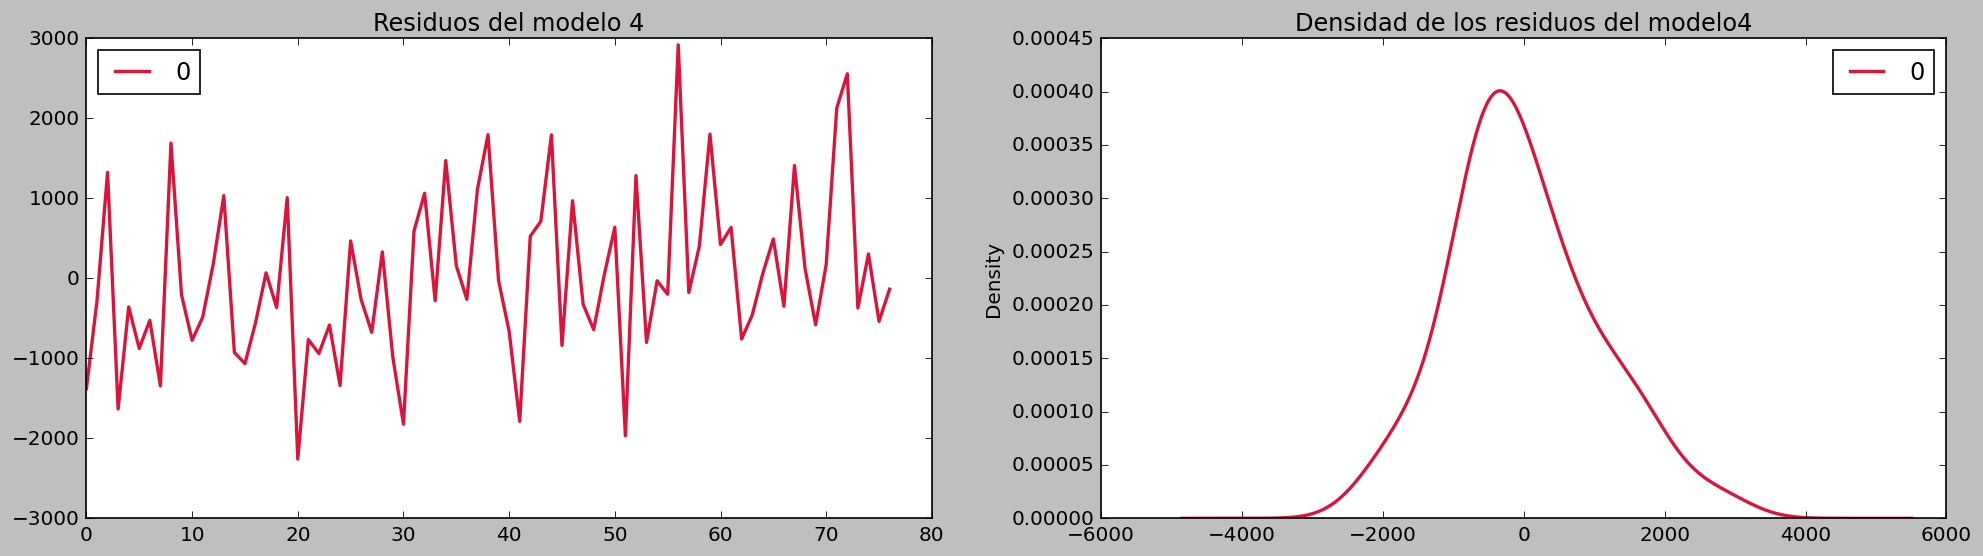

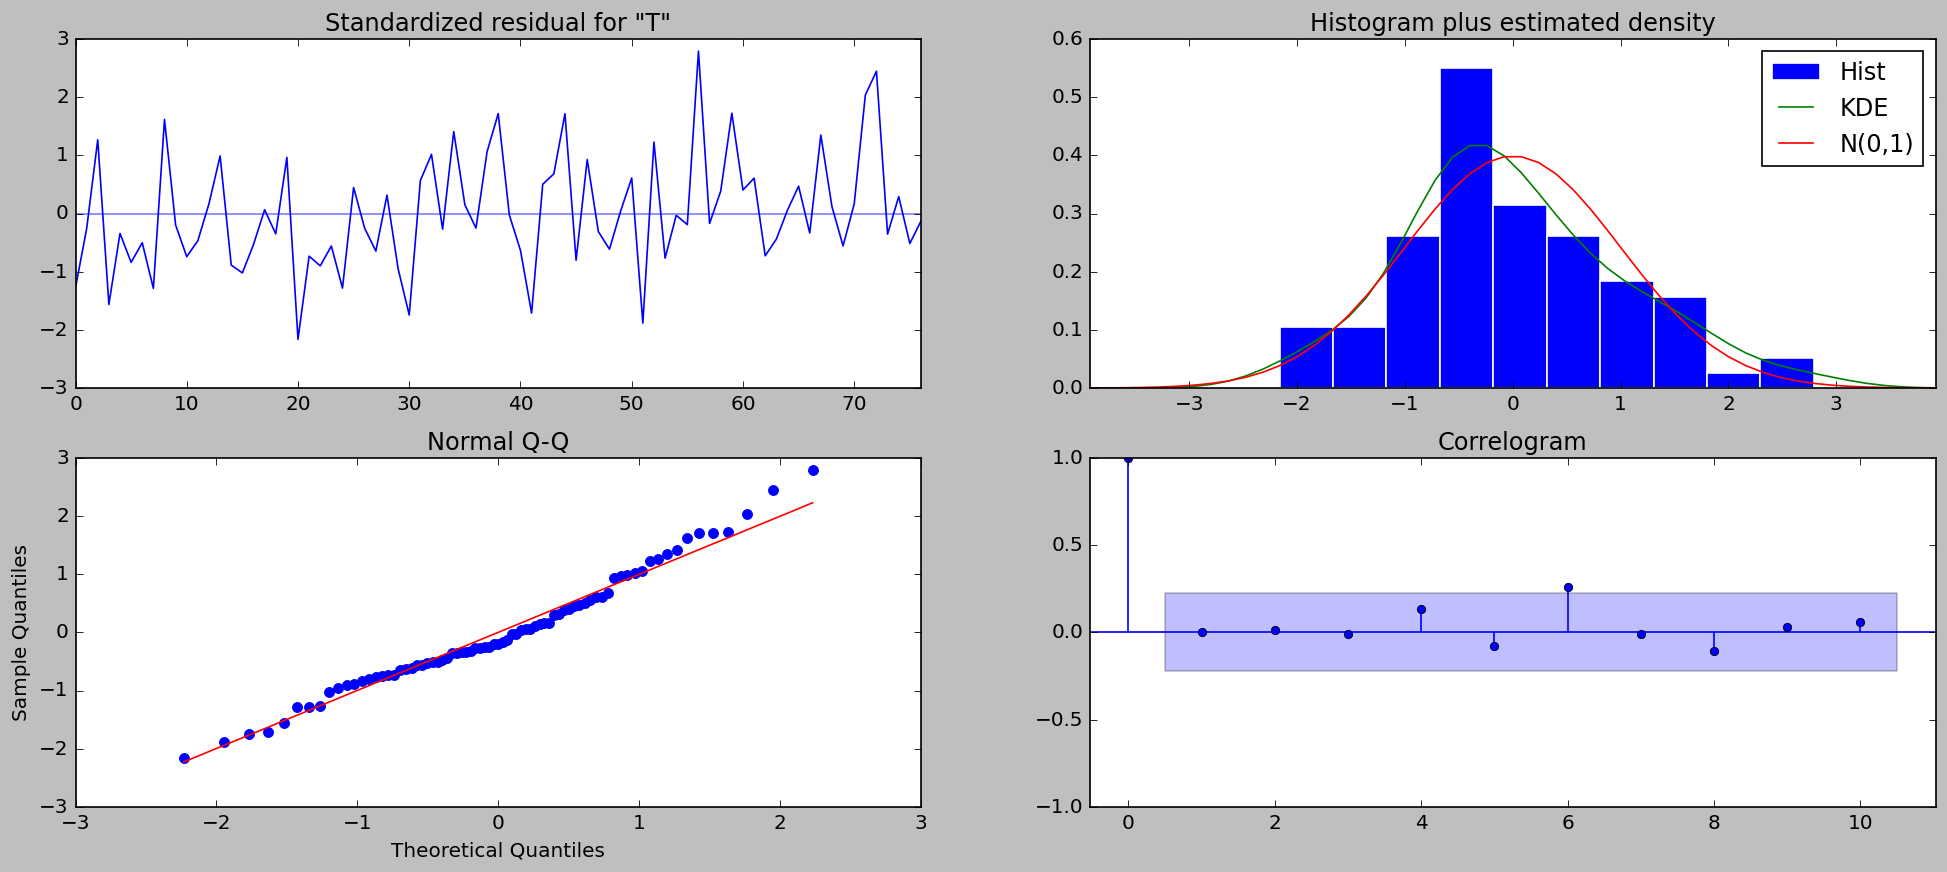

In [ ]:
#PLOT DE RESIDUOS DEL MODELO4

plt.rcParams.update({'figure.figsize': (20, 5),
                     'figure.dpi': 120})

residuals=pd.DataFrame(model4_fit.resid)
fig,ax=plt.subplots(1,2,figsize=(20,5))
residuals.plot(title= "Residuos del modelo 4",ax=ax[0],color="crimson", lw=2)
residuals.plot(kind="kde",title= "Densidad de los residuos del modelo4",ax=ax[1],color="crimson", lw=2)
plt.show()

model4_fit.plot_diagnostics(figsize=(20, 8))
plt.show()
#los errores residuales parecen estar bien con una media igual a 0 y una varianza constante.

## 6. FORECAST

### 6.1 Forecast del modelo 1

In [ ]:
# Forecast
forecast1 = model1_fit.forecast(steps=6)  # Adjust the number of steps as needed

# Crear un rango de fechas extendido para incluir los pronósticos
extended_dates1 = pd.date_range(start=x.iloc[0], periods=len(y) + len(forecast1), freq='M')

# Crear un DataFrame para combinar los valores originales, ajustados y pronosticados
df_combined1 = pd.DataFrame({
    "Fecha": extended_dates1,
    "Original": list(y) + [None] * len(forecast1),
    "Ajustado": list(model1_fit.fittedvalues) + [None] * len(forecast1),
    "Pronosticado": [None] * len(y) + list(forecast1)
})

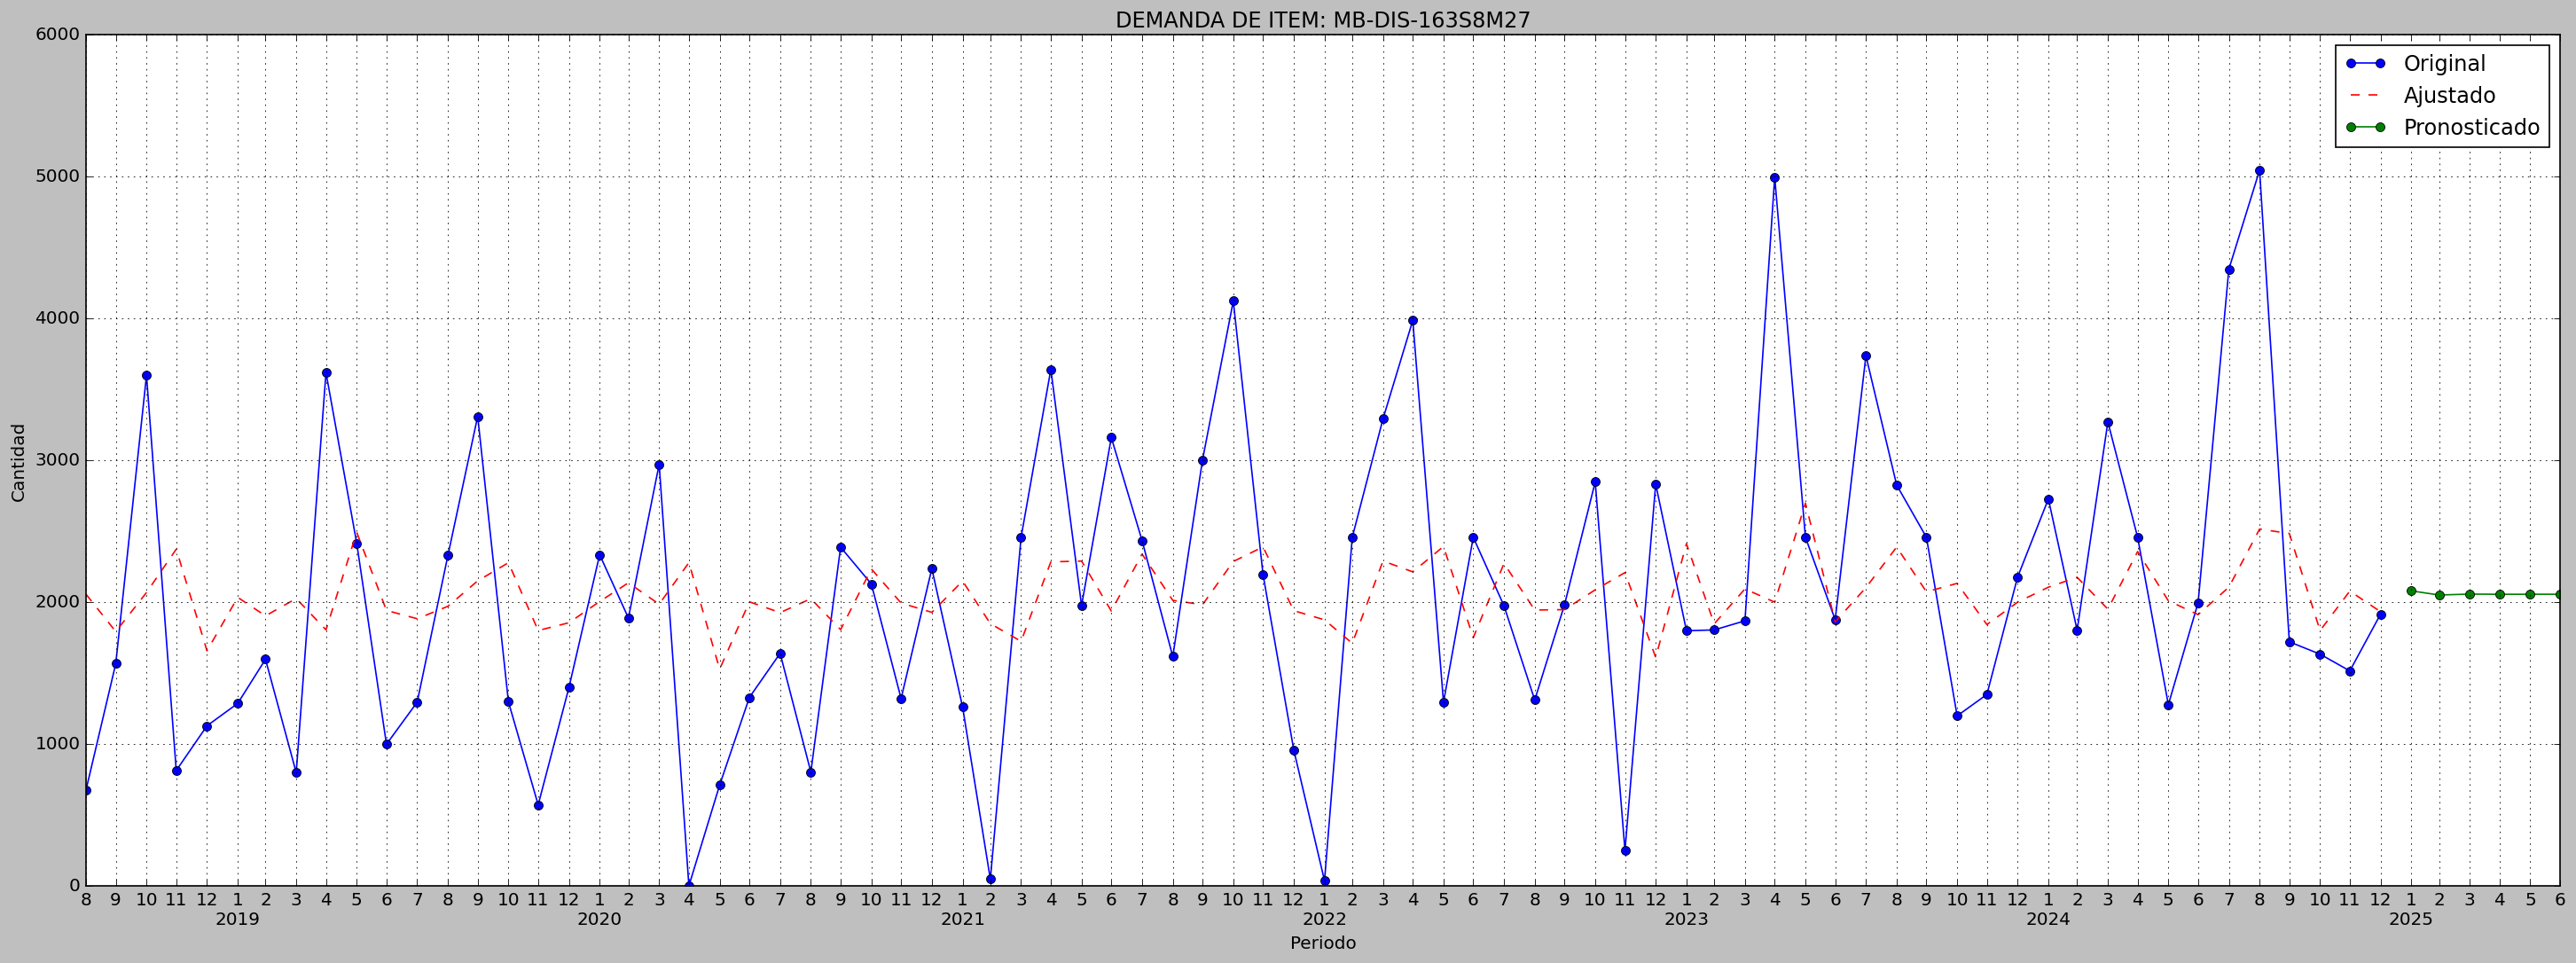

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(df_combined1["Fecha"], df_combined1["Original"], label="Original", color="blue", marker="o")
plt.plot(df_combined1["Fecha"], df_combined1["Ajustado"], label="Ajustado", color="red", linestyle="--")
plt.plot(df_combined1["Fecha"], df_combined1["Pronosticado"], label="Pronosticado", color="green", marker="o")
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=df_combined1["Fecha"].max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

### 6.2 Forescast del modelo 2

In [ ]:
# Forecast
forecast2 = model2_fit.forecast(steps=6)  # Adjust the number of steps as needed

# Crear un rango de fechas extendido para incluir los pronósticos
extended_dates2 = pd.date_range(start=x.iloc[0], periods=len(y) + len(forecast2), freq='M')

# Crear un DataFrame para combinar los valores originales, ajustados y pronosticados
df_combined2 = pd.DataFrame({
    "Fecha": extended_dates2,
    "Original": list(y) + [None] * len(forecast2),
    "Ajustado": list(model2_fit.fittedvalues) + [None] * len(forecast2),
    "Pronosticado": [None] * len(y) + list(forecast2)
})

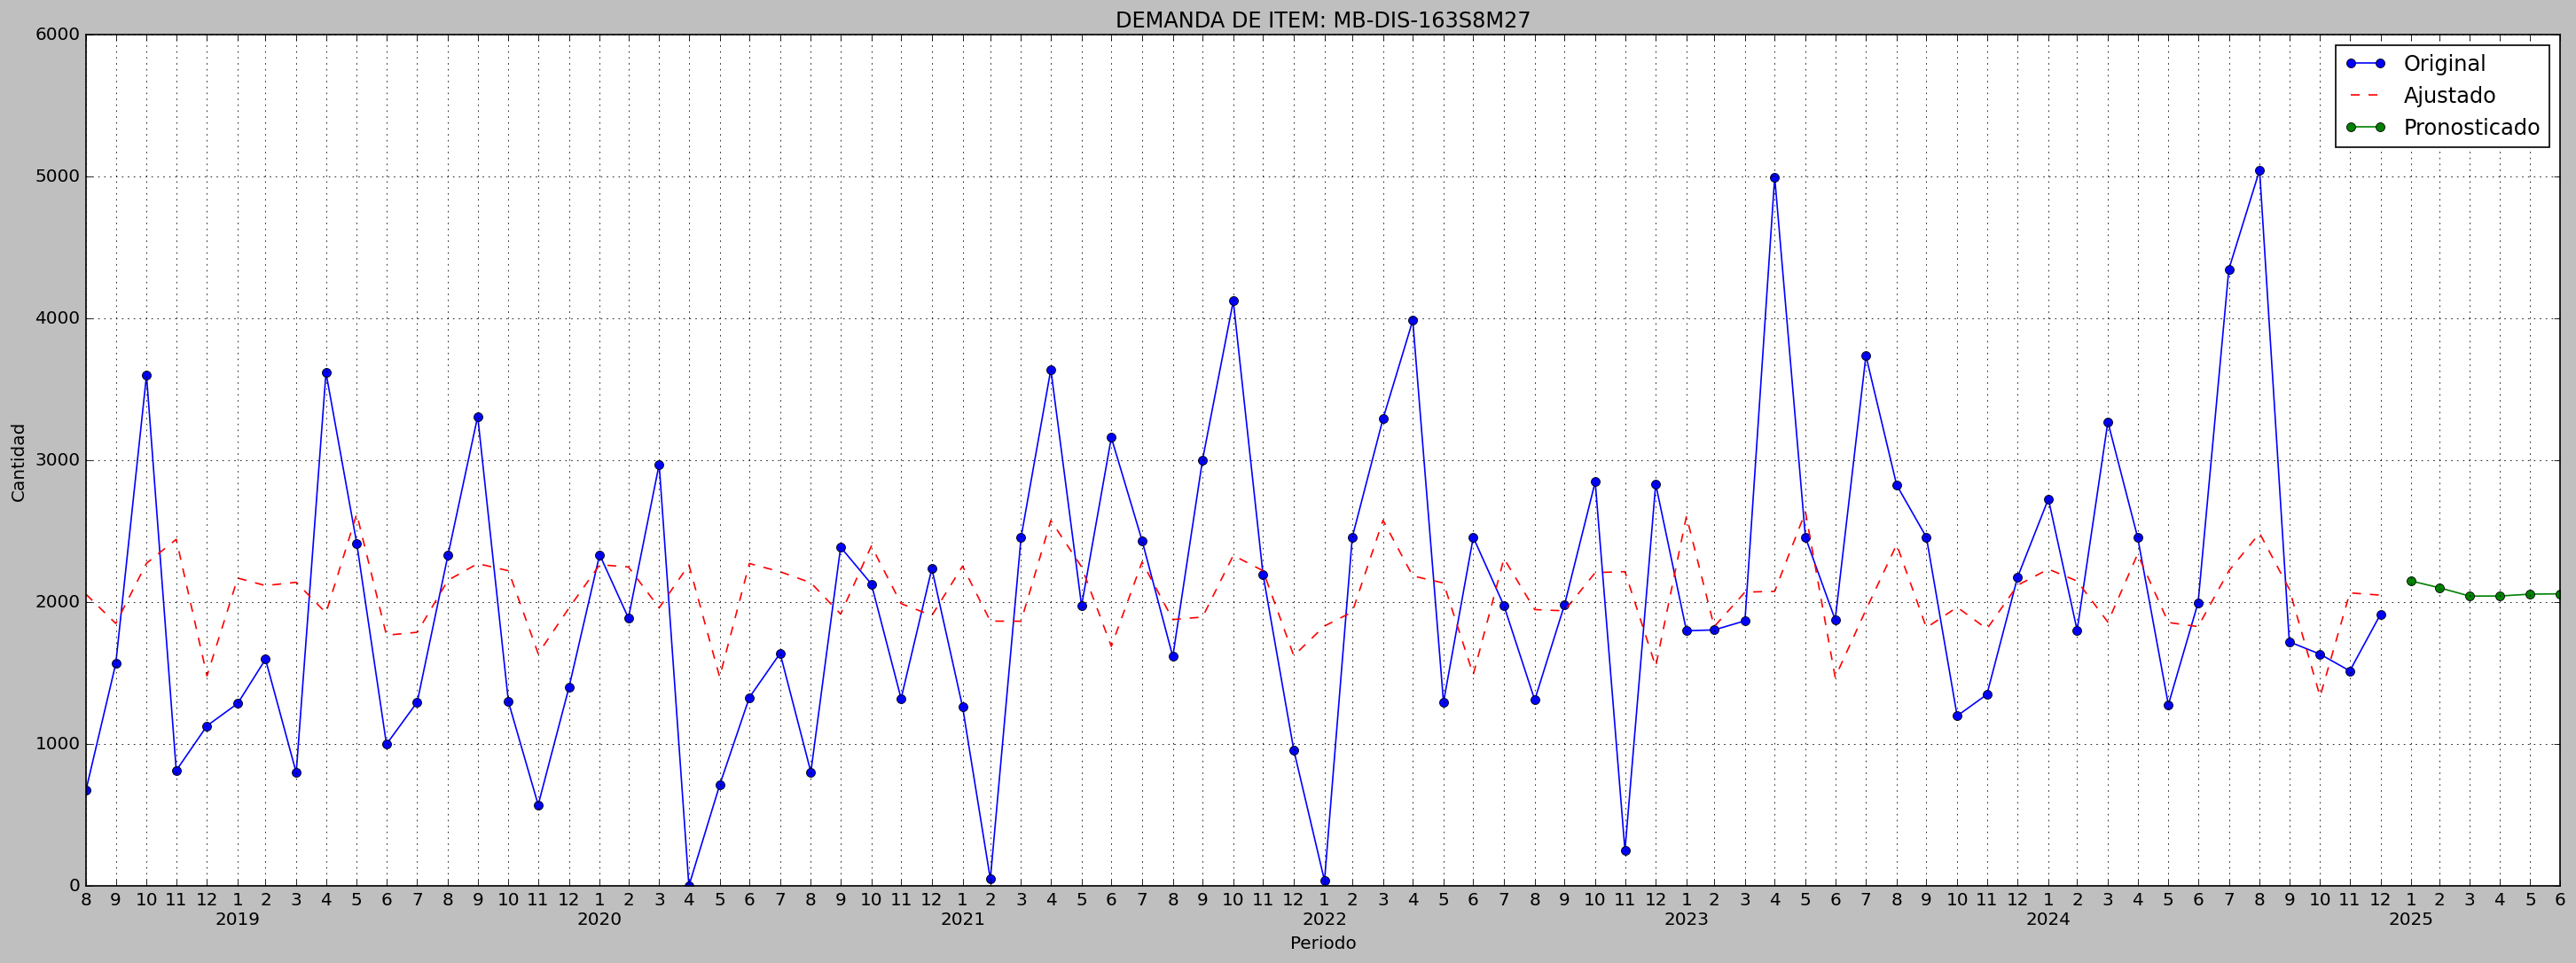

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(df_combined2["Fecha"], df_combined2["Original"], label="Original", color="blue", marker="o")
plt.plot(df_combined2["Fecha"], df_combined2["Ajustado"], label="Ajustado", color="red", linestyle="--")
plt.plot(df_combined2["Fecha"], df_combined2["Pronosticado"], label="Pronosticado", color="green", marker="o")
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=df_combined2["Fecha"].max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

### 6.3 Forescast del modelo 3

In [ ]:
# Forecast
forecast3 = model3_fit.forecast(steps=6)  # Adjust the number of steps as needed

# Crear un rango de fechas extendido para incluir los pronósticos
extended_dates3 = pd.date_range(start=x.iloc[0], periods=len(y) + len(forecast3), freq='M')

# Crear un DataFrame para combinar los valores originales, ajustados y pronosticados
df_combined3 = pd.DataFrame({
    "Fecha": extended_dates3,
    "Original": list(y) + [None] * len(forecast3),
    "Ajustado": list(model3_fit.fittedvalues) + [None] * len(forecast3),
    "Pronosticado": [None] * len(y) + list(forecast3)
})

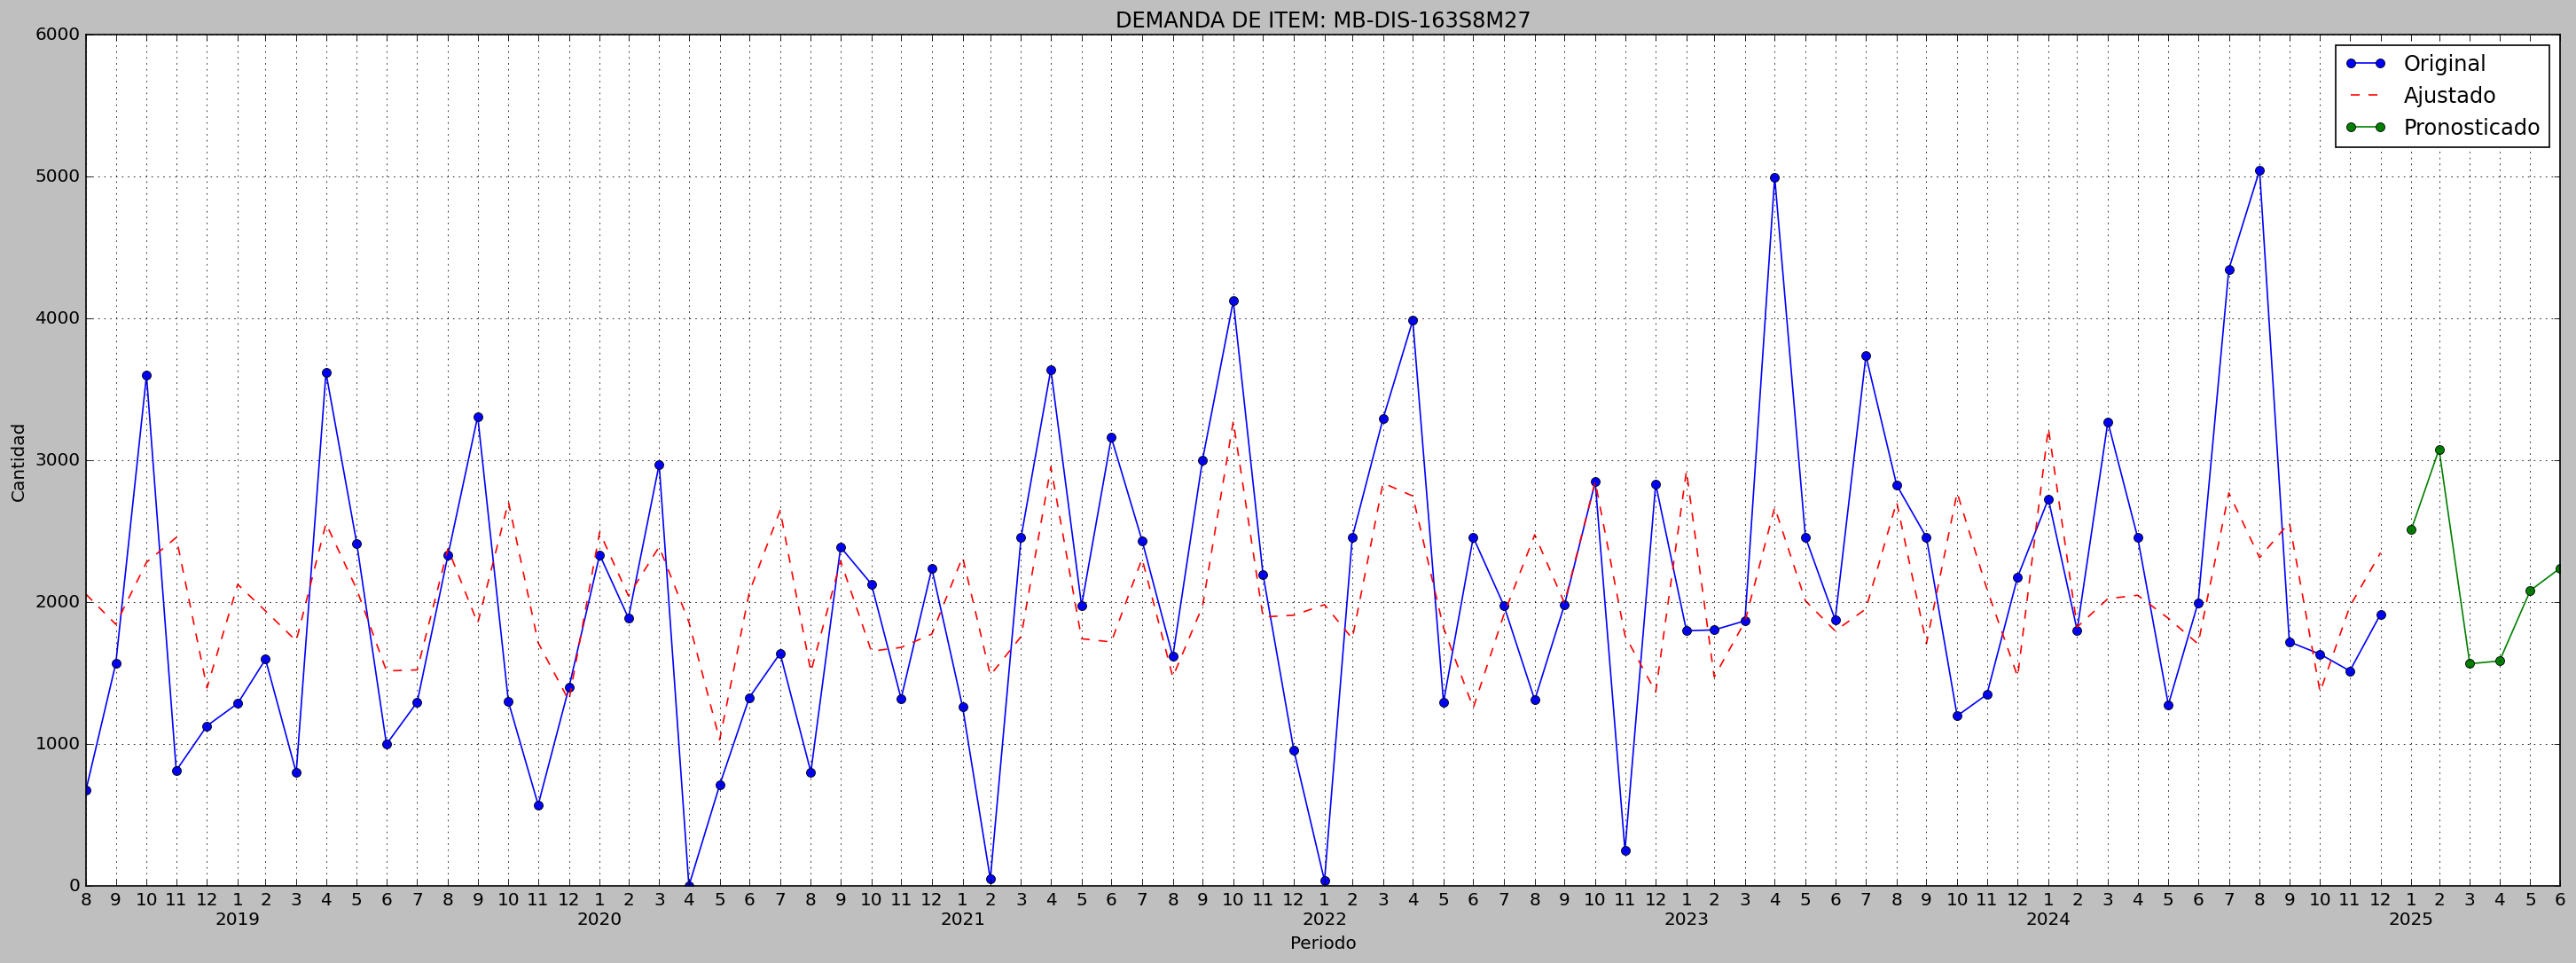

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(df_combined3["Fecha"], df_combined3["Original"], label="Original", color="blue", marker="o")
plt.plot(df_combined3["Fecha"], df_combined3["Ajustado"], label="Ajustado", color="red", linestyle="--")
plt.plot(df_combined3["Fecha"], df_combined3["Pronosticado"], label="Pronosticado", color="green", marker="o")
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=df_combined3["Fecha"].max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

### 6.4 Forescast del modelo 4

In [ ]:
# Forecast
forecast4 = model4_fit.forecast(steps=6)  # Adjust the number of steps as needed

# Crear un rango de fechas extendido para incluir los pronósticos
extended_dates4 = pd.date_range(start=x.iloc[0], periods=len(y) + len(forecast4), freq='M')

# Crear un DataFrame para combinar los valores originales, ajustados y pronosticados
df_combined4 = pd.DataFrame({
    "Fecha": extended_dates4,
    "Original": list(y) + [None] * len(forecast4),
    "Ajustado": list(model2_fit.fittedvalues) + [None] * len(forecast4),
    "Pronosticado": [None] * len(y) + list(forecast4)
})

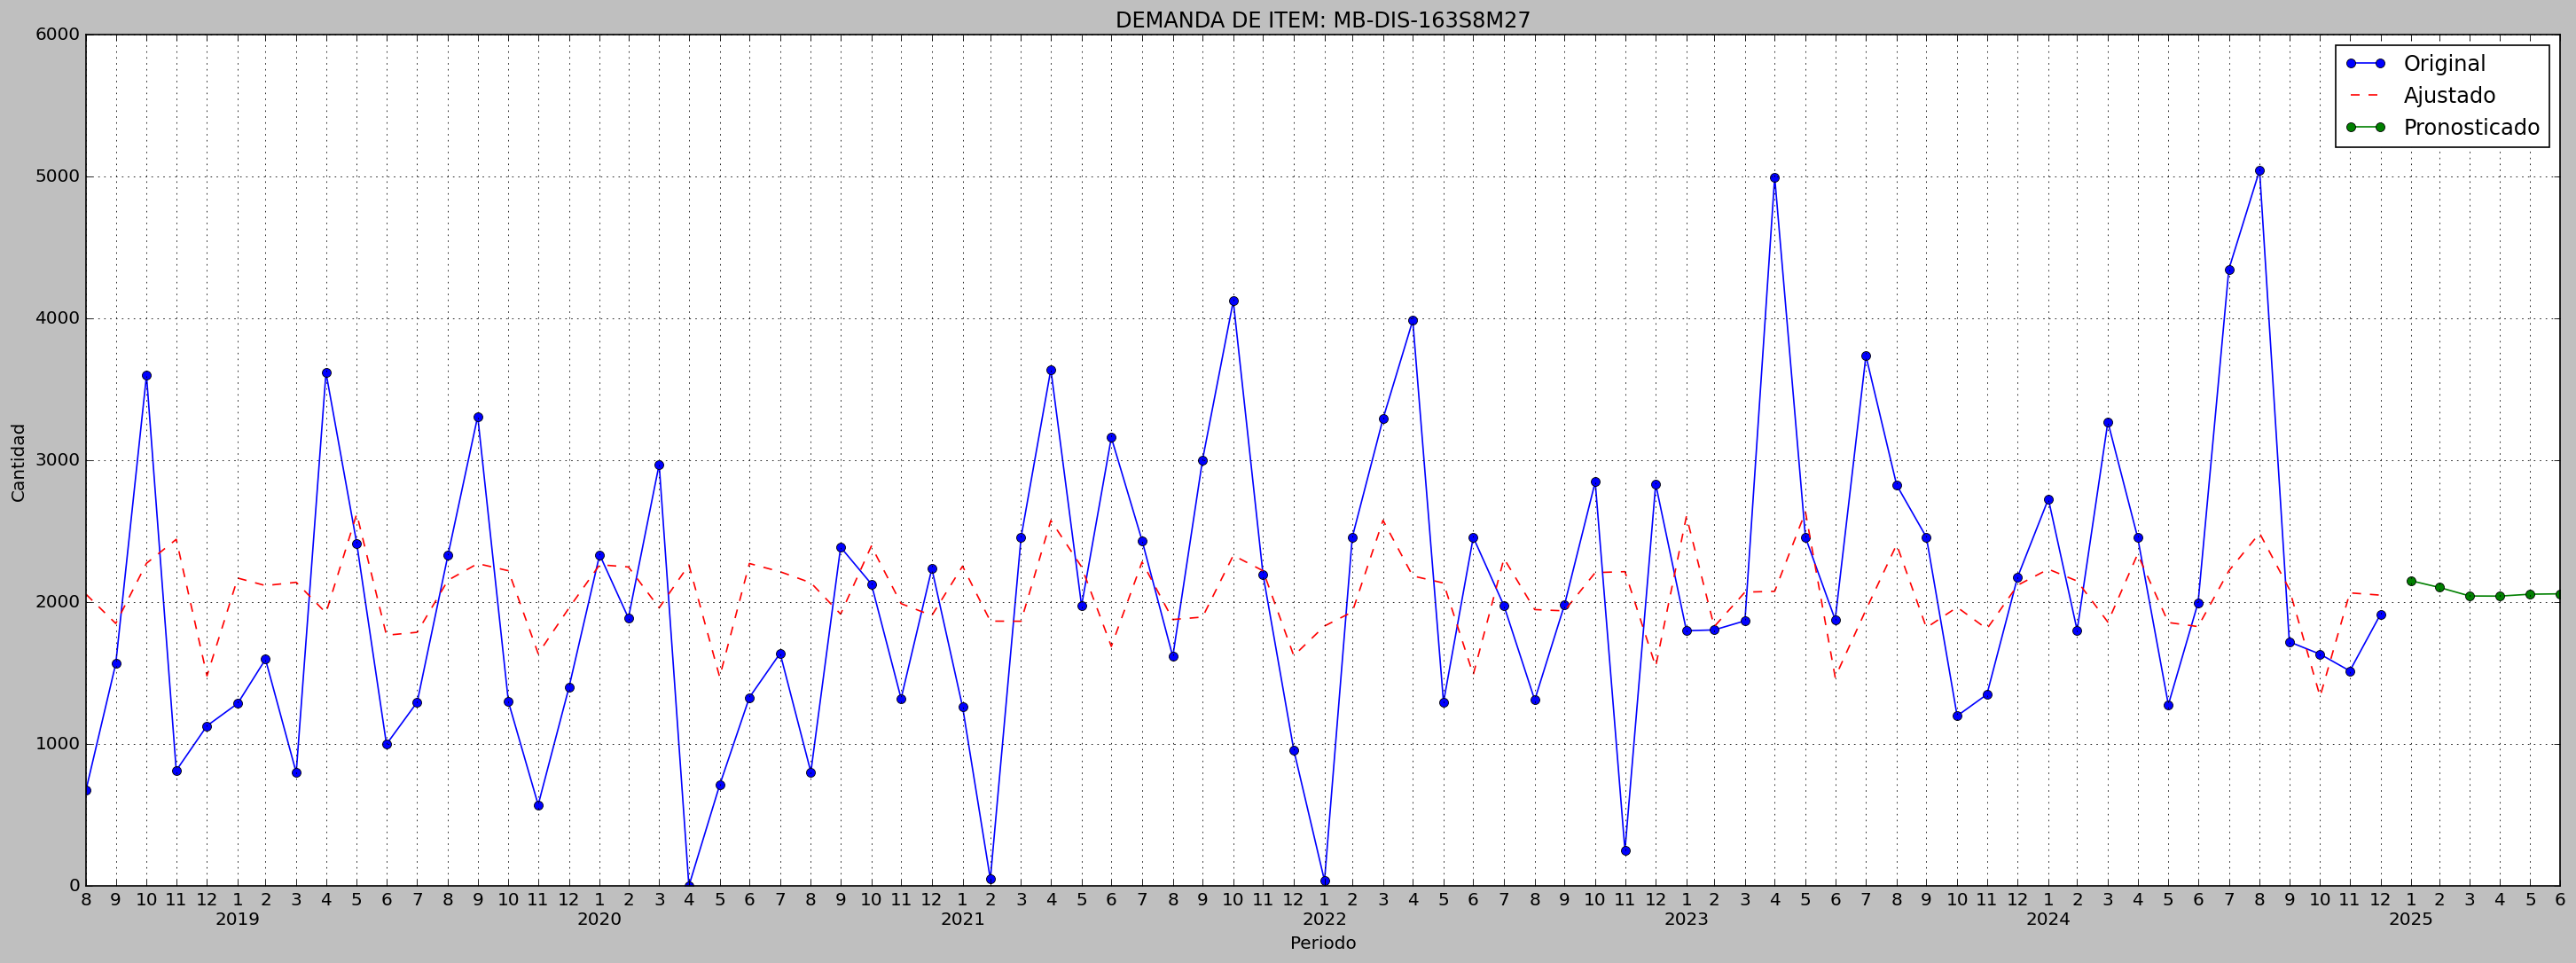

In [ ]:
# GRAFICO DE SERIE DE TIEMPO

# Crear un gráfico de serie de tiempo con meses y años
plt.figure(figsize=(30, 10))
plt.plot(df_combined4["Fecha"], df_combined4["Original"], label="Original", color="blue", marker="o")
plt.plot(df_combined4["Fecha"], df_combined4["Ajustado"], label="Ajustado", color="red", linestyle="--")
plt.plot(df_combined4["Fecha"], df_combined4["Pronosticado"], label="Pronosticado", color="green", marker="o")
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=df_combined4["Fecha"].max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero

# Configurar las etiquetas del eje x
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

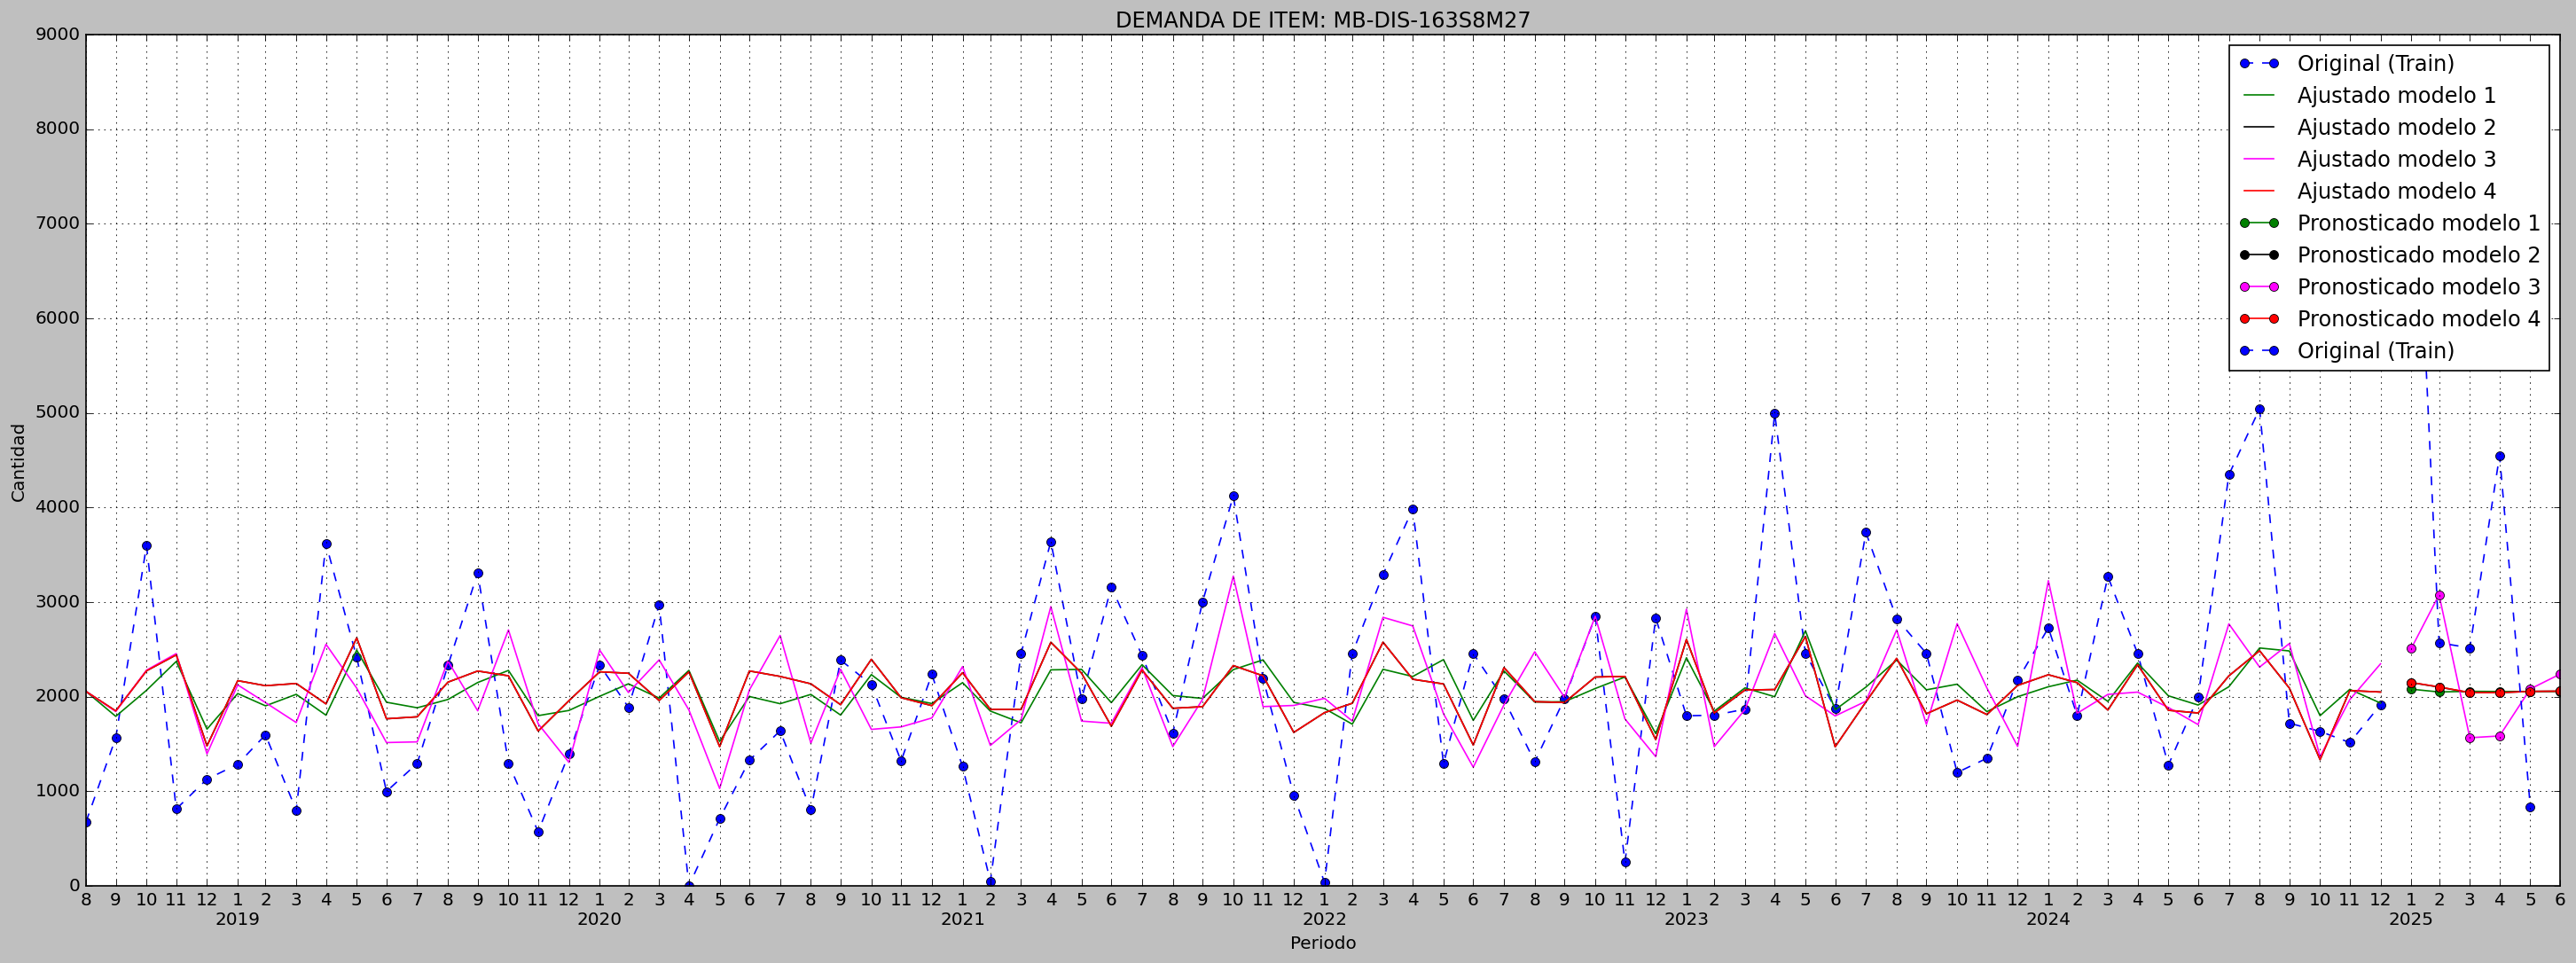

In [ ]:
# ...existing code...

# COMBINA LOS GRAFICOS DE LOS PRONOSTICOS DE LOS 4 MODELOS y el df test

plt.figure(figsize=(30, 10))

# Serie original (train)
plt.plot(df_combined1["Fecha"], df_combined1["Original"], label="Original (Train)", color="blue", marker="o", linestyle="--")

# Ajustados de los 4 modelos
plt.plot(df_combined1["Fecha"], df_combined1["Ajustado"], label="Ajustado modelo 1", color="green", linestyle="-")
plt.plot(df_combined2["Fecha"], df_combined2["Ajustado"], label="Ajustado modelo 2", color="black", linestyle="-")
plt.plot(df_combined3["Fecha"], df_combined3["Ajustado"], label="Ajustado modelo 3", color="Fuchsia", linestyle="-")
plt.plot(df_combined4["Fecha"], df_combined4["Ajustado"], label="Ajustado modelo 4", color="red", linestyle="-")

# Pronósticos de los 4 modelos
plt.plot(df_combined1["Fecha"], df_combined1["Pronosticado"], label="Pronosticado modelo 1", color="green", marker="o")
plt.plot(df_combined2["Fecha"], df_combined2["Pronosticado"], label="Pronosticado modelo 2", color="black", marker="o")
plt.plot(df_combined3["Fecha"], df_combined3["Pronosticado"], label="Pronosticado modelo 3", color="Fuchsia", marker="o")
plt.plot(df_combined4["Fecha"], df_combined4["Pronosticado"], label="Pronosticado modelo 4", color="red", marker="o")

# Datos reales del test set (línea y puntos)
if not df_test.empty:
    plt.plot(df_test["FECHA"], df_test["Total Cantidad"], label="Original (Train)", color="blue", marker="o", linestyle="--")
 
plt.title(f"DEMANDA DE ITEM: {df_filtered['ITEM'].iloc[0]}")
plt.xlabel("Periodo")
plt.ylabel("Cantidad")
plt.grid()

# Ajustar los ticks para mostrar meses y un año cada 12 meses
x_ticks = pd.date_range(start=x.min(), end=df_combined1["Fecha"].max(), freq='M')
month_labels = [f"{date.month}" for date in x_ticks]
year_labels = [f"{date.year}" if date.month == 1 else "" for date in x_ticks]  # Mostrar el año solo en enero
plt.xticks(ticks=x_ticks, labels=[f"{month}\n{year}" for month, year in zip(month_labels, year_labels)], rotation=0)

plt.legend()
plt.show()

In [ ]:
# COMBINAR TODOS LOS PRONOSTICOS DE LOS 4 MODELOS EN UN SOLO DATAFRAME
df_combined_all = pd.DataFrame({
    "Fecha": extended_dates1,
    "Original": list(y) + [None] * len(forecast1),
    "Ajustado_modelo1": list(model1_fit.fittedvalues) + [None] * len(forecast1),
    "Pronosticado_modelo1": [None] * len(y) + list(forecast1),
    "Ajustado_modelo2": list(model2_fit.fittedvalues) + [None] * len(forecast2),
    "Pronosticado_modelo2": [None] * len(y) + list(forecast2),
    "Ajustado_modelo3": list(model3_fit.fittedvalues) + [None] * len(forecast3),
    "Pronosticado_modelo3": [None] * len(y) + list(forecast3),
    "Ajustado_modelo4": list(model4_fit.fittedvalues) + [None] * len(forecast4),
    "Pronosticado_modelo4": [None] * len(y) + list(forecast4)
})
df_combined_all

Fecha  Original  Ajustado_modelo1  Pronosticado_modelo1  \
0  2018-08-31     676.0       2055.291589                   NaN   
1  2018-09-30    1566.0       1792.188052                   NaN   
2  2018-10-31    3598.0       2067.457037                   NaN   
3  2018-11-30     813.0       2372.937761                   NaN   
4  2018-12-31    1128.0       1656.866837                   NaN   
..        ...       ...               ...                   ...   
78 2025-02-28       NaN               NaN           2049.932539   
79 2025-03-31       NaN               NaN           2056.490303   
80 2025-04-30       NaN               NaN           2055.023460   
81 2025-05-31       NaN               NaN           2055.351564   
82 2025-06-30       NaN               NaN           2055.278174   

    Ajustado_modelo2  Pronosticado_modelo2  Ajustado_modelo3  \
0        2055.291756                   NaN       2055.293700   
1        1849.268366                   NaN       1843.486694   
2        2273.485137                   NaN       2280.386228   
3        2442.301605                   NaN       2455.545321   
4        1480.066121                   NaN       1395.290022   
..               ...                   ...               ...   
78               NaN           2101.622553               NaN   
79               NaN           2042.352064               NaN   
80               NaN           2042.946981               NaN   
81               NaN           2056.105935               NaN   
82               NaN           2058.146396               NaN   

    Pronosticado_modelo3  Ajustado_modelo4  Pronosticado_modelo4  
0                    NaN       2055.291625                   NaN  
1                    NaN       1849.248146                   NaN  
2                    NaN       2273.304513                   NaN  
3                    NaN       2446.152635                   NaN  
4                    NaN       1484.540679                   NaN  
..                   ...               ...                   ...  
78           3077.404842               NaN           2103.872288  
79           1565.679022               NaN           2043.042241  
80           1584.830280               NaN           2042.227072  
81           2081.616218               NaN           2055.634996  
82           2238.703126               NaN           2058.265971  

[83 rows x 10 columns]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:         Total Cantidad   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -647.311
Distribution:                  Normal   AIC:                           1302.62
Method:            Maximum Likelihood   BIC:                           1312.00
                                        No. Observations:                   77
Date:                Fri, May 16 2025   Df Residuals:                       76
Time:                        11:40:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          2055.2915    123.752     16.608  6.080e-62 [1.

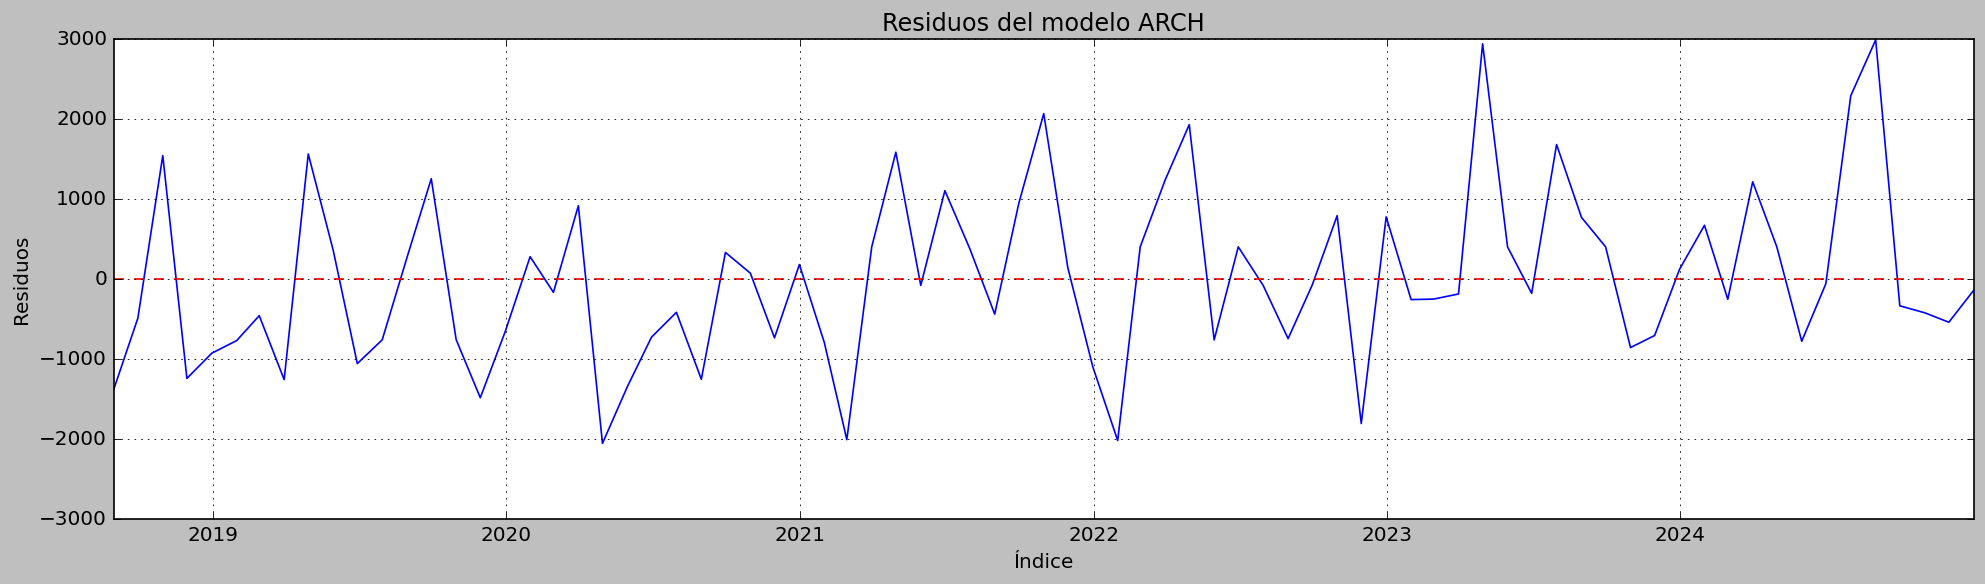

In [ ]:
# MODELO ARCH
from arch import arch_model
model5 = arch_model(y.dropna(),
                    vol='Garch', 
                    p=1, 
                    q=1, 
                    dist='Normal')
model5_fit = model5.fit(disp="off")
print(model5_fit.summary())

# GRAFICO DE RESIDUOS DEL MODELO ARCH
plt.figure(figsize=(20, 5))
plt.plot(x, model5_fit.resid)
plt.title("Residuos del modelo ARCH")
plt.xlabel("Índice")
plt.ylabel("Residuos")
plt.axhline(0, color='red', linestyle='--')
plt.grid()
plt.show()

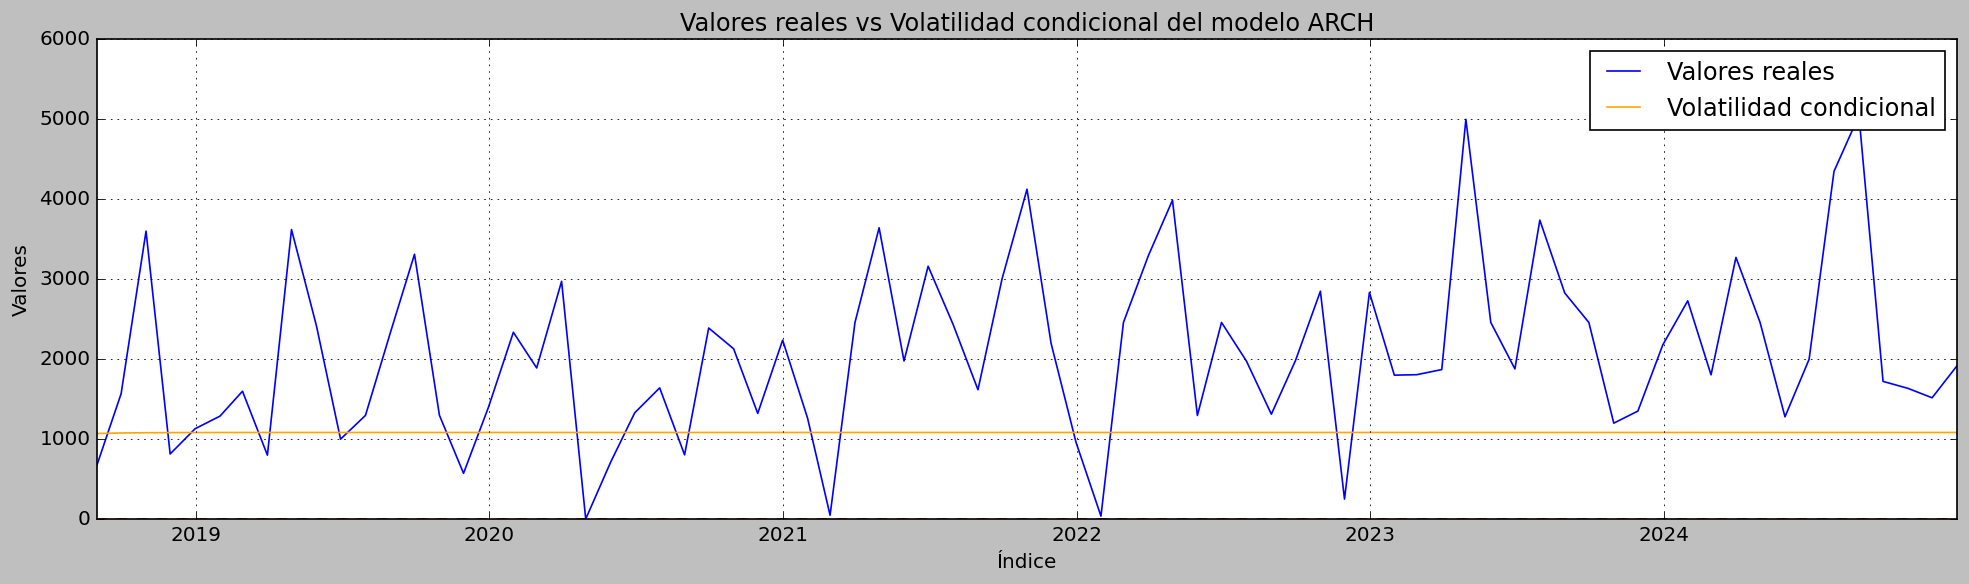

In [ ]:
# modelo ajustado y actuales del ARCH
plt.figure(figsize=(20, 5))
plt.plot(x, y, label='Valores reales', color='blue')
plt.plot(x, model5_fit.conditional_volatility, label='Volatilidad condicional', color='orange')
plt.title("Valores reales vs Volatilidad condicional del modelo ARCH")
plt.xlabel("Índice")
plt.ylabel("Valores")
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.grid()
plt.show()

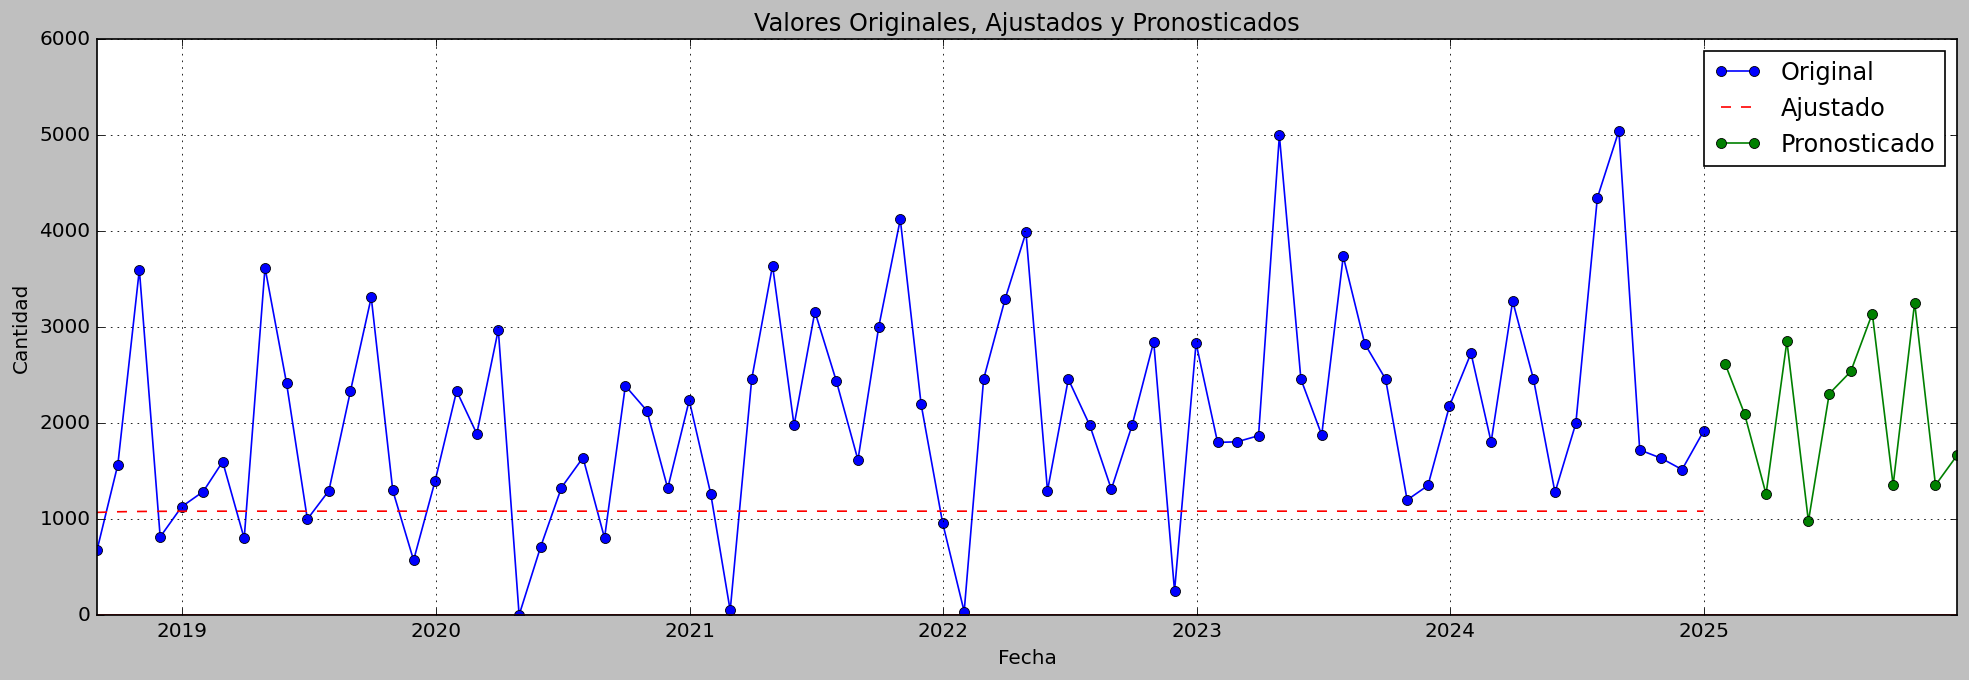

In [ ]:
# Forecast using simulate
simulated_forecast = model5.simulate(params=model5_fit.params, nobs=12)  # Generate 12-step forecast

# Crear un rango de fechas extendido para incluir los pronósticos
extended_dates = pd.date_range(start=x.iloc[0], periods=len(y) + len(simulated_forecast), freq='M')

# Crear un DataFrame para combinar los valores originales, ajustados y pronosticados
df_combined = pd.DataFrame({
    "Fecha": extended_dates,
    "Original": list(y) + [None] * len(simulated_forecast),
    "Ajustado": list(model5_fit.conditional_volatility) + [None] * len(simulated_forecast),
    "Pronosticado": [None] * len(y) + list(simulated_forecast["data"])
})

# Graficar los valores
plt.figure(figsize=(20, 6))
plt.plot(df_combined["Fecha"], df_combined["Original"], label="Original", color="blue", marker="o")
plt.plot(df_combined["Fecha"], df_combined["Ajustado"], label="Ajustado", color="red", linestyle="--")
plt.plot(df_combined["Fecha"], df_combined["Pronosticado"], label="Pronosticado", color="green", marker="o")
plt.title("Valores Originales, Ajustados y Pronosticados")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.axhline(0, color='red', linestyle='-')
plt.legend()
plt.grid()
plt.show()

# Simulación de procesos ARCH

Este cuaderno de Jupyter presenta simulaciones de procesos ARCH

In [ ]:
T = 1000                # número de observaciones
u = np.random.randn(T)  # ruido blanco
data = pd.DataFrame({'u':u})

Nsimul = 1000           # número de simulaciones de MonteCarlo

In [ ]:
    pip install pycm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys
print(sys.executable)

c:\Users\Ing Machine Learning\AppData\Local\anaconda3\python.exe


In [ ]:
!pip install pymc

  Using cached arviz-0.21.0-py3-none-any.whl.metadata (8.8 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 10.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 11.2 MB/s eta 0:00:00
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9228 sha256=5a1d55068e57d5897c085dc07c70ccc00c89d358c45cb5b0031f6d1781abdd5a
  Stored in directory: c:\users\ing machine learning\appdata\local\pip\cache\wheels\91\0c\f7

  DEPRECATION: Building 'cons' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'cons'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'logical-unification' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'logical-unification'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'etuples' using the legacy setup.py bdist_

In [ ]:
pip install pymc3

  Using cached pymc3-3.11.6-py3-none-any.whl.metadata (15 kB)
  Using cached deprecat-2.1.3-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached fastprogress-1.0.3-py3-none-any.whl.metadata (5.6 kB)
  Using cached numpy-1.22.1.zip (11.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "c:\Users\Ing Machine Learning\AppData\Local\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
        File "c:\Users\Ing Machine Learning\AppData\Local\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Ing Machine Learning\AppData\Local\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 137, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
        File "c:\Users\Ing Machine Learning\AppData\Local\anaconda3\Lib\site-p